<a href="https://colab.research.google.com/github/Soundarya43/HurricaneIanMLTechniques/blob/main/HurricaneIan2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**READ DATA**

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install osmnx geopandas matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.4/99.4 kB 3.8 MB/s eta 0:00:00


In [3]:
!pip install pytorch-tabnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 1.9 MB/s eta 0:00:00


In [4]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 40.8 MB/s eta 0:00:00


In [5]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.9/78.9 kB 6.4 MB/s eta 0:00:00


**Importing Packages**

In [6]:
# prompt: import os

import os
os.chdir('/content/drive/My Drive')
print(os.getcwd())

#dataframes
import pandas as pd
import numpy as np

#viz
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import folium

#openstreetmap
import osmnx as ox

#QGIS land cover data
import rasterio
from rasterio.plot import show
from shapely.geometry import Point
from rasterio.mask import mask
import pyproj
from pyproj import Proj, transform
from shapely.geometry import box
from matplotlib.colors import ListedColormap, BoundaryNorm

# Random Forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.utils.class_weight import compute_sample_weight
import statistics

#TabNet
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.model_selection import KFold
import optuna
from sklearn.metrics import mean_absolute_error, r2_score

#XGBoost
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV


/content/drive/My Drive


In [7]:
# Reading weather data from airport stations

KMLBcsv = '/content/drive/My Drive/HurricaneIan/KMLB_csv.csv'
KMLBini = pd.read_csv(KMLBcsv)
display(KMLBini.head())

KCOFcsv = '/content/drive/My Drive/HurricaneIan/KCOF_csv.csv'
KCOFini = pd.read_csv(KCOFcsv)
display(KCOFini.head())

KXMRcsv = '/content/drive/My Drive/HurricaneIan/KXMR_csv.csv'
KXMRini = pd.read_csv(KXMRcsv)
display(KXMRini.head())

KTIXcsv = '/content/drive/My Drive/HurricaneIan/KTIX_csv.csv'
KTIXini = pd.read_csv(KTIXcsv)
KTIXini.head()

KMLBini['Time'] = pd.to_datetime(KMLBini['Time'], utc=True)
KCOFini['Time'] = pd.to_datetime(KCOFini['Time'], utc=True)
KXMRini['Time'] = pd.to_datetime(KXMRini['Time'], utc=True)
KTIXini['Time'] = pd.to_datetime(KTIXini['Time'], utc=True)


,Station,Time,Temperature,Relative_Humidity,Wind_Speed,Wind_Direction,Pressure
0,KMLB,09/27/2022 00:00 UTC,78.8,83.6,6.91,180.0,29.86
1,KMLB,09/27/2022 00:05 UTC,77.0,88.7,8.06,170.0,29.86
2,KMLB,09/27/2022 00:10 UTC,78.8,83.6,6.91,160.0,29.86
3,KMLB,09/27/2022 00:15 UTC,78.8,83.6,6.91,150.0,29.86
4,KMLB,09/27/2022 00:20 UTC,78.8,83.6,6.91,150.0,29.86


,Station,Time,Temperature,Relative_Humidity,Wind_Speed,Wind_Direction,Pressure
0,KCOF,09/27/2022 00:55 UTC,80.42,98.83,6.91,180,29.88
1,KCOF,09/27/2022 01:55 UTC,79.52,98.83,5.75,190,29.89
2,KCOF,09/27/2022 02:55 UTC,79.34,98.83,3.45,160,29.89
3,KCOF,09/27/2022 03:55 UTC,79.34,98.83,4.60,200,29.90
4,KCOF,09/27/2022 04:55 UTC,78.80,98.83,3.45,190,29.88


,Station,Time,Temperature,Relative_Humidity,Wind_Speed,Wind_Direction,Pressure
0,KXMR,09/27/2022 00:55 UTC,80.60,81.73,6.91,170,29.87
1,KXMR,09/27/2022 01:55 UTC,78.98,88.79,0.00,0,29.88
2,KXMR,09/27/2022 02:55 UTC,78.80,88.78,0.00,0,29.89
3,KXMR,09/27/2022 03:55 UTC,78.98,87.73,3.45,260,29.89
4,KXMR,09/27/2022 04:55 UTC,78.44,86.66,4.60,260,29.88


In [8]:
# Data cleaning

#Fill missing values with average of 3 previous values
def fill_missing_with_avg(data, columns):
    for col in columns:
        data[col] = data[col].fillna(data[col].rolling(window=3, min_periods=1).mean())
    return data

columns_to_clean = ['Temperature', 'Relative_Humidity', 'Wind_Speed', 'Wind_Direction', 'Pressure']
dataframes = [KMLBini, KCOFini, KXMRini, KTIXini]
dataframe_names  = ['KMLB', 'KCOF', 'KXMR', 'KTIX']
cleaned_dataframes = {}

for i, df in enumerate(dataframes):
    df_cleaned = fill_missing_with_avg(df, columns_to_clean)
    df_bfilled = df_cleaned.bfill() #backfilling for rest
    cleaned_dataframes[dataframe_names[i]] = df_bfilled

#Creating cleaned dataframes
KMLB = cleaned_dataframes['KMLB']
KCOF = cleaned_dataframes['KCOF']
KXMR = cleaned_dataframes['KXMR']
KTIX = cleaned_dataframes['KTIX']

display(KMLB.describe())
display(KCOF.describe())
display(KXMR.describe())
display(KTIX.describe())




,Temperature,Relative_Humidity,Wind_Speed,Wind_Direction,Pressure
count,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000
mean,76.535714,89.273016,16.808899,130.327381,29.659082
std,3.741013,6.244188,10.722045,85.069584,0.230182
min,64.400000,74.020000,0.000000,0.000000,29.240000
25%,75.020000,83.600000,8.060000,70.000000,29.480000
50%,77.000000,88.700000,17.260000,110.000000,29.770000
75%,78.800000,94.160000,25.320000,200.000000,29.860000
max,82.940000,100.000000,43.730000,360.000000,29.910000


,Temperature,Relative_Humidity,Wind_Speed,Wind_Direction,Pressure
count,177.000000,177.000000,177.000000,177.000000,177.000000
mean,76.494576,98.933220,24.446158,147.231638,29.606836
std,4.091143,1.680747,12.085127,85.770025,0.215986
min,65.480000,94.160000,0.000000,0.000000,29.170000
25%,75.200000,98.820000,13.810000,80.000000,29.420000
50%,77.000000,98.840000,25.320000,120.000000,29.620000
75%,78.800000,100.000000,33.370000,220.000000,29.790000
max,83.120000,100.000000,47.180000,310.000000,29.910000


,Temperature,Relative_Humidity,Wind_Speed,Wind_Direction,Pressure
count,287.000000,287.000000,287.000000,287.000000,287.000000
mean,76.237979,91.412683,20.854425,147.038328,29.553972
std,3.173931,4.039220,10.693718,91.215233,0.233743
min,64.400000,73.770000,0.000000,0.000000,29.200000
25%,75.200000,88.780000,12.660000,90.000000,29.340000
50%,76.640000,93.980000,19.560000,120.000000,29.570000
75%,77.900000,94.160000,28.770000,195.000000,29.780000
max,82.400000,100.000000,50.640000,340.000000,29.900000


,Temperature,Relative_Humidity,Wind_Speed,Wind_Direction,Pressure
count,19.000000,19.000000,19.000000,19.000000,19.000000
mean,78.705263,82.210526,5.813684,112.105263,29.816316
std,5.707059,7.935164,5.404294,121.086697,0.123208
min,66.200000,66.040000,0.000000,0.000000,29.550000
25%,78.800000,78.820000,0.000000,0.000000,29.850000
50%,80.600000,83.710000,5.750000,100.000000,29.870000
75%,82.400000,88.370000,8.060000,125.000000,29.890000
max,84.200000,94.250000,17.260000,320.000000,29.900000


In [9]:
print(KCOF.isnull().sum())


Station              0
Time                 0
Temperature          0
Relative_Humidity    0
Wind_Speed           0
Wind_Direction       0
Pressure             0
dtype: int64


In [10]:
# Plotting weather station coordinates on map
stations = {
    'KCOF': [28.2395, -80.6075],
    'KXMR': [28.47, -80.57],
    'KMLB': [28.1013, -80.6451],
    'KTIX': [28.5134, -80.7988]
}

# Initialize a map centered on Florida
m = folium.Map(location=[28.5, -81.0], zoom_start=8)

# Add weather stations as markers
for station, coords in stations.items():
    folium.Marker(location=coords, popup=station, icon=folium.Icon(color='blue')).add_to(m)

# Read hurrican track LAT LON
ian_track_file = '/content/drive/My Drive/HurricaneIan/ian_track.csv'
ian_track = pd.read_csv(ian_track_file)
for _, row in ian_track.iterrows():
    folium.CircleMarker(
        location=[row['LAT'], row['LON']],
        radius=3,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.6
    ).add_to(m)

# Display the map with the hurricane track
m

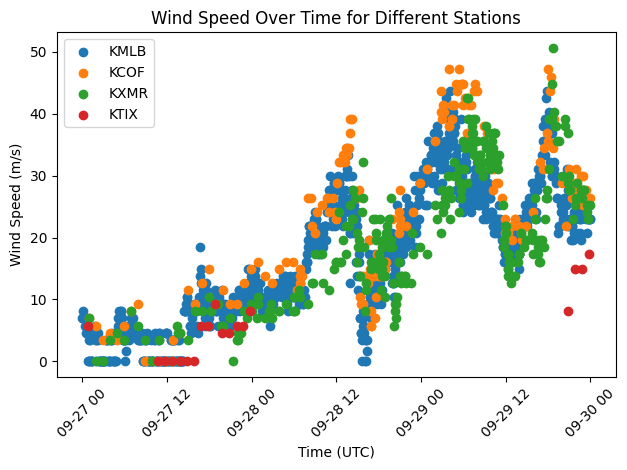

<ipython-input-11-10683e89bd69>:23: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  resampled = df['Wind_Speed'].resample('5T').agg(['mean', 'min', 'max']).dropna()
<ipython-input-11-10683e89bd69>:23: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  resampled = df['Wind_Speed'].resample('5T').agg(['mean', 'min', 'max']).dropna()
<ipython-input-11-10683e89bd69>:23: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  resampled = df['Wind_Speed'].resample('5T').agg(['mean', 'min', 'max']).dropna()
<ipython-input-11-10683e89bd69>:23: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  resampled = df['Wind_Speed'].resample('5T').agg(['mean', 'min', 'max']).dropna()


In [11]:
# Plotting Wind Speed Data from each weather station

plt.scatter(KMLB['Time'], KMLB['Wind_Speed'], label='KMLB', linewidth=1)
plt.scatter(KCOF['Time'], KCOF['Wind_Speed'], label='KCOF', linewidth=1)
plt.scatter(KXMR['Time'], KXMR['Wind_Speed'], label='KXMR', linewidth=1)
plt.scatter(KTIX['Time'], KTIX['Wind_Speed'], label='KTIX', linewidth=1)

# title and labels
plt.title('Wind Speed Over Time for Different Stations')
plt.xlabel('Time (UTC)')
plt.ylabel('Wind Speed (m/s)')
plt.legend()

# plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#Processing wind speed data to show min and max across different stations
def process_station_data(df):
    df.set_index('Time', inplace=True)
    # Resample to 5-minute intervals, calculating mean, min, and max
    resampled = df['Wind_Speed'].resample('5T').agg(['mean', 'min', 'max']).dropna()
    resampled.columns = ['Average_Wind_Speed', 'Min_Wind_Speed', 'Max_Wind_Speed']
    return resampled

KMLB_resampled = process_station_data(KMLB)
KCOF_resampled = process_station_data(KCOF)
KXMR_resampled = process_station_data(KXMR)
KTIX_resampled = process_station_data(KTIX)

combined_results = pd.concat([
    KMLB_resampled.rename(columns={'Average_Wind_Speed': 'KMLB_Avg', 'Min_Wind_Speed': 'KMLB_Min', 'Max_Wind_Speed': 'KMLB_Max'}),
    KCOF_resampled.rename(columns={'Average_Wind_Speed': 'KCOF_Avg', 'Min_Wind_Speed': 'KCOF_Min', 'Max_Wind_Speed': 'KCOF_Max'}),
    KXMR_resampled.rename(columns={'Average_Wind_Speed': 'KXMR_Avg', 'Min_Wind_Speed': 'KXMR_Min', 'Max_Wind_Speed': 'KXMR_Max'}),
    KTIX_resampled.rename(columns={'Average_Wind_Speed': 'KTIX_Avg', 'Min_Wind_Speed': 'KTIX_Min', 'Max_Wind_Speed': 'KTIX_Max'}),
], axis=1)

In [12]:
#What are the min and max speeds, after 5-min averaging

summary_df = pd.DataFrame({
    'Station': ['KMLB', 'KCOF', 'KXMR', 'KTIX'],
    'Min_Wind_Speed': [
        KMLB['Wind_Speed'].min(),
        KCOF['Wind_Speed'].min(),
        KXMR['Wind_Speed'].min(),
        KTIX['Wind_Speed'].min()
    ],
    'Max_Wind_Speed': [
        KMLB['Wind_Speed'].max(),
        KCOF['Wind_Speed'].max(),
        KXMR['Wind_Speed'].max(),
        KTIX['Wind_Speed'].max()
    ],
    'Average_Wind_Speed': [
        KMLB['Wind_Speed'].mean(),
        KCOF['Wind_Speed'].mean(),
        KXMR['Wind_Speed'].mean(),
        KTIX['Wind_Speed'].mean()
    ]
})

# Display the summary table
print(summary_df)

  Station  Min_Wind_Speed  Max_Wind_Speed  Average_Wind_Speed
0    KMLB             0.0           43.73           16.808899
1    KCOF             0.0           47.18           24.446158
2    KXMR             0.0           50.64           20.854425
3    KTIX             0.0           17.26            5.813684


The KCOF weather station Patrick Air Force Base Station read the highest wind speeds followed by Cape Canveral Air station. Both weather stations were close to the eye of the hurricane. Does the environment affect the wind speeds?


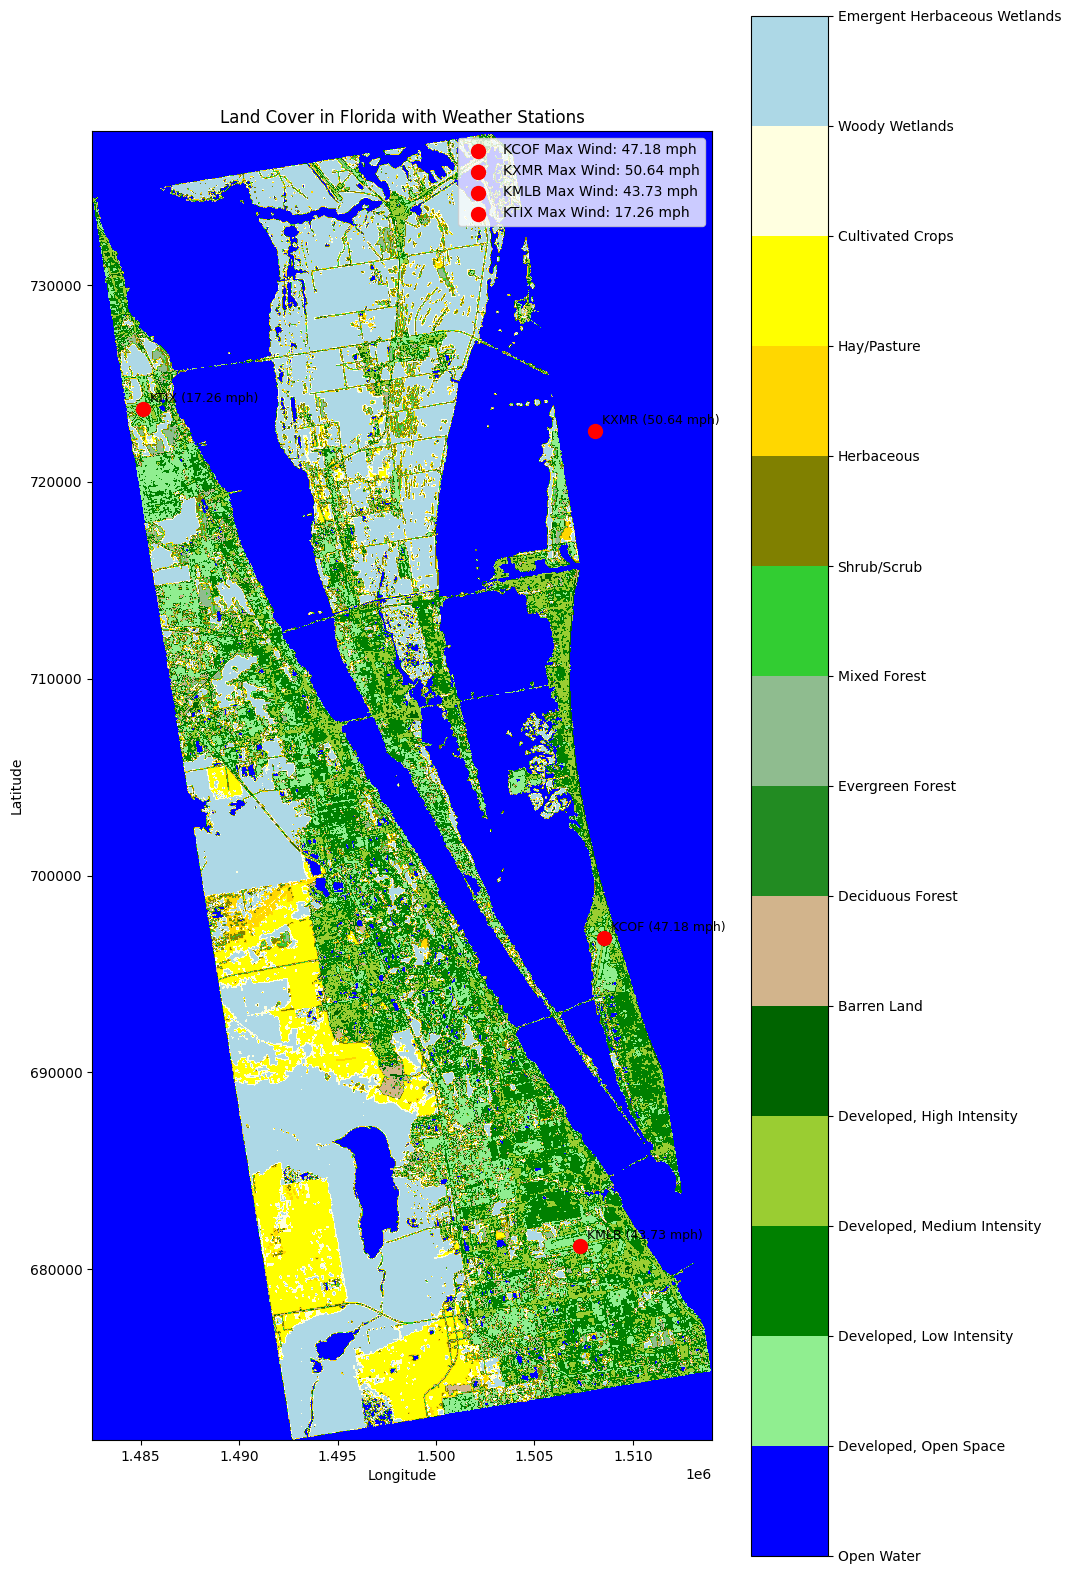

In [13]:
# Load the land cover raster data
raster_path = '/content/drive/My Drive/HurricaneIan/nlcd_2021_land_cover_l48_20230630.img'
with rasterio.open(raster_path) as src:
    # Get the CRS of the raster
    raster_crs = src.crs

    # Define the bounding box for Florida (in geographic coordinates)
    florida_bbox_wgs = box(-80.8076, 28.6122, -80.5887, 28.0345)

    # Create a GeoDataFrame for the bounding box and reproject
    florida_geom = gpd.GeoDataFrame(index=[0], crs='EPSG:4326', geometry=[florida_bbox_wgs])
    florida_geom = florida_geom.to_crs(raster_crs)  # Reproject to raster CRS

    # Mask the raster with the bounding box of Florida
    out_image, out_transform = mask(src, florida_geom.geometry, crop=True)

# Define land cover classes and their corresponding colors
legend_labels = {
    11: "Open Water",
    21: "Developed, Open Space",
    22: "Developed, Low Intensity",
    23: "Developed, Medium Intensity",
    24: "Developed, High Intensity",
    31: "Barren Land",
    41: "Deciduous Forest",
    42: "Evergreen Forest",
    43: "Mixed Forest",
    52: "Shrub/Scrub",
    71: "Herbaceous",
    81: "Hay/Pasture",
    82: "Cultivated Crops",
    90: "Woody Wetlands",
    95: "Emergent Herbaceous Wetlands",
}

# Define colors for the land cover types
cmap = ListedColormap([
    'blue',        # Open Water
    'lightgreen',  # Developed, Open Space
    'green',       # Developed, Low Intensity
    'yellowgreen', # Developed, Medium Intensity
    'darkgreen',   # Developed, High Intensity
    'tan',         # Barren Land
    'forestgreen', # Deciduous Forest
    'darkseagreen',# Evergreen Forest
    'limegreen',   # Mixed Forest
    'olive',       # Shrub/Scrub
    'gold',        # Herbaceous
    'yellow',      # Hay/Pasture
    'lightyellow', # Cultivated Crops
    'cyan',        # Woody Wetlands
    'lightblue'    # Emergent Herbaceous Wetlands
])

# Create boundaries for land cover types
boundaries = [11, 21, 22, 23, 24, 31, 41, 42, 43, 52, 71, 81, 82, 90, 95]
norm = BoundaryNorm(boundaries, cmap.N)

# Plot the masked region for Florida
fig, ax = plt.subplots(figsize=(10, 20))
show(out_image, ax=ax, transform=out_transform, cmap=cmap, norm=norm)

# Define weather stations and their max wind speeds
weather_stations = {
    'KCOF': (28.2395, -80.6075, 47.18),
    'KXMR': (28.47, -80.57, 50.64),
    'KMLB': (28.1013, -80.6451, 43.73),
    'KTIX': (28.5134, -80.7988, 17.26)
}

stations_gdf = gpd.GeoDataFrame(
    weather_stations.keys(),
    columns=['Station'],
    geometry=[gpd.points_from_xy([lon], [lat])[0] for lat, lon, _ in weather_stations.values()],
    crs='EPSG:4326'  # Define as WGS 84
)
stations_gdf = stations_gdf.to_crs(raster_crs)

# Plot the weather stations
for station, (lat, lon, wind_speed) in weather_stations.items():
    station_geom = stations_gdf.loc[stations_gdf['Station'] == station, 'geometry'].values[0]
    ax.scatter(station_geom.x, station_geom.y, color='red', marker='o', s=100,
               label=f'{station} Max Wind: {wind_speed} mph')
    ax.annotate(f'{station} ({wind_speed} mph)', xy=(station_geom.x, station_geom.y),
                xytext=(5, 5), textcoords='offset points', fontsize=9, color='black')

plt.title("Land Cover in Florida with Weather Stations")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Add a legend for the land cover types
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Add colorbar
cbar = plt.colorbar(sm, ticks=boundaries, ax=ax)
cbar.ax.set_yticklabels([legend_labels[i] for i in boundaries])

# Add a legend for weather stations
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc='upper right')

plt.show()

Correlating Weather Stations

Combined DataFrame:

Correlation Matrix:
             Temperature  Wind_Speed  Pressure
Temperature     1.000000   -0.181937  0.137234
Wind_Speed     -0.181937    1.000000 -0.726374
Pressure        0.137234   -0.726374  1.000000


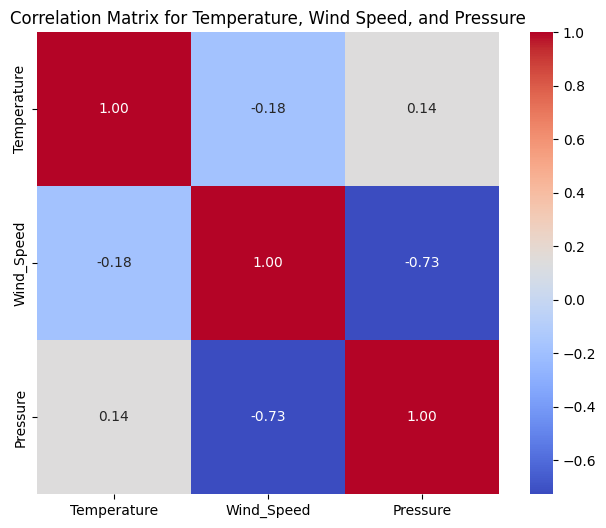


Correlations between stations:
Wind Speed (KMLB) & Wind Speed (KCOF): 0.91
Wind Speed (KMLB) & Wind Speed (KXMR): 0.76
Temperature (KMLB) & Pressure (KXMR): 0.84


In [14]:
# Combine the dataframes for correlation analysis
combined_df = pd.concat([KMLB, KCOF, KXMR], ignore_index=True)

# Display the combined DataFrame
print("Combined DataFrame:")
#print(combined_df)

# Calculate the correlation matrix
correlation_matrix = combined_df[['Temperature', 'Wind_Speed', 'Pressure']].corr()

# Display the correlation matrix
print("\nCorrelation Matrix:")
print(correlation_matrix)

# Plotting the correlation matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Matrix for Temperature, Wind Speed, and Pressure')
plt.show()

# Correlation between Wind Speed, Temperature, and Pressure between stations
wind_temp_corr = KMLB['Wind_Speed'].corr(KCOF['Wind_Speed'])
wind_pressure_corr = KMLB['Wind_Speed'].corr(KXMR['Wind_Speed'])
temp_pressure_corr = KMLB['Temperature'].corr(KXMR['Temperature'])

print("\nCorrelations between stations:")
print(f"Wind Speed (KMLB) & Wind Speed (KCOF): {wind_temp_corr:.2f}")
print(f"Wind Speed (KMLB) & Wind Speed (KXMR): {wind_pressure_corr:.2f}")
print(f"Temperature (KMLB) & Pressure (KXMR): {temp_pressure_corr:.2f}")

# **Random Forest Method**

Cross-validated RMSE: 3.0689756592443596
Train RMSE: 1.89
Test RMSE: 4.06


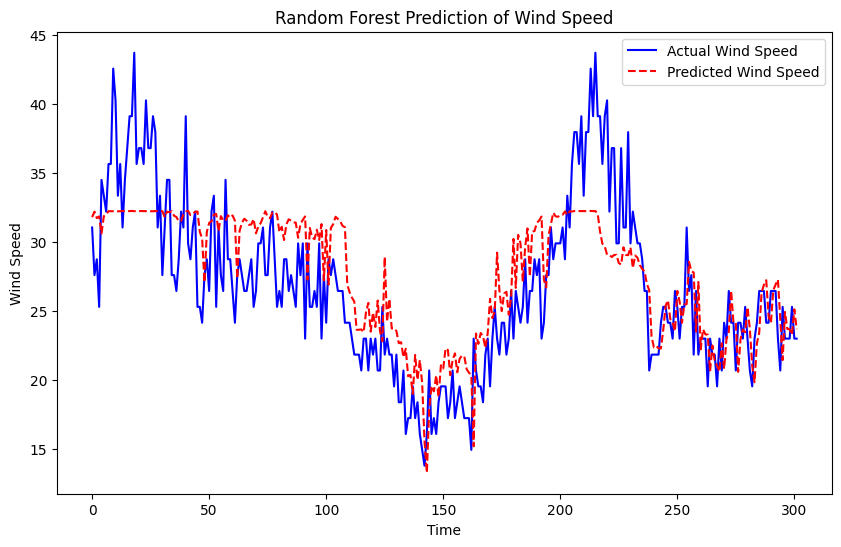

In [15]:
# With Manual Finetuning

# Create lagged features for time series
def create_lagged_features(df, lag=3):
    df_lagged = df.copy()
    for col in df.columns:
        for l in range(1, lag + 1):
            df_lagged[f'{col}_lag_{l}'] = df[col].shift(l)
    return df_lagged.dropna()

# Create lagged features
lagged_data = create_lagged_features(KMLB[['Temperature', 'Relative_Humidity', 'Wind_Speed', 'Pressure']], lag=3)

# Define the target variable (Wind Speed) and features (the rest)
X = lagged_data.drop(columns=['Wind_Speed'])  # Features
y = lagged_data['Wind_Speed']  # Target

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

# Initialize and train the Random Forest model
rf = RandomForestRegressor(n_estimators=500, max_depth=20, min_samples_split=30, random_state=65) # fine tune parameters
weights = compute_sample_weight(class_weight='balanced', y=y_train)
rf.fit(X_train, y_train)

# Make predictions
y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)
scores = cross_val_score(rf, X, y, cv=5, scoring='neg_root_mean_squared_error')
print("Cross-validated RMSE:", -scores.mean())


# Evaluate the model performance
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f'Train RMSE: {train_rmse:.2f}')
print(f'Test RMSE: {test_rmse:.2f}')

# Optionally, plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual Wind Speed', color='blue')
plt.plot(y_pred_test, label='Predicted Wind Speed', color='red', linestyle='dashed')
plt.legend()
plt.title('Random Forest Prediction of Wind Speed')
plt.xlabel('Time')
plt.ylabel('Wind Speed')
plt.show()

[I 2024-12-05 04:35:49,977] A new study created in memory with name: no-name-b6f932fc-8d88-42e3-9850-1656d8d59145
[I 2024-12-05 04:35:51,688] Trial 0 finished with value: 3.0431140170884903 and parameters: {'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 49}. Best is trial 0 with value: 3.0431140170884903.
[I 2024-12-05 04:35:57,726] Trial 1 finished with value: 2.9561852081932685 and parameters: {'n_estimators': 300, 'max_depth': 10, 'min_samples_split': 8}. Best is trial 1 with value: 2.9561852081932685.
[I 2024-12-05 04:35:58,816] Trial 2 finished with value: 3.0431140170884903 and parameters: {'n_estimators': 100, 'max_depth': 38, 'min_samples_split': 49}. Best is trial 1 with value: 2.9561852081932685.
[I 2024-12-05 04:36:00,641] Trial 3 finished with value: 2.9985957352810266 and parameters: {'n_estimators': 100, 'max_depth': 30, 'min_samples_split': 25}. Best is trial 1 with value: 2.9561852081932685.
[I 2024-12-05 04:36:04,219] Trial 4 finished with value: 2.94618126

Train RMSE: 1.45
Test RMSE: 4.67
Cross-validated RMSE: 3.0689756592443596


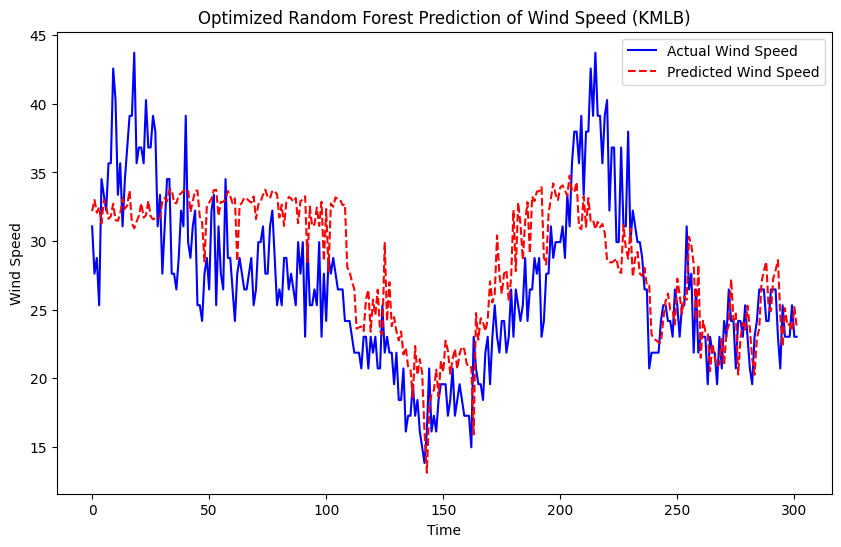

In [17]:
# Finetuned with Optuna
# Create lagged features for time series
def create_lagged_features(df, lag=3):
    df_lagged = df.copy()
    for col in df.columns:
        for l in range(1, lag + 1):
            df_lagged[f'{col}_lag_{l}'] = df[col].shift(l)
    return df_lagged.dropna()

# Create lagged features
lagged_data = create_lagged_features(KMLB[['Temperature', 'Relative_Humidity', 'Wind_Speed', 'Pressure']], lag=3)

# Define the target variable (Wind Speed) and features (the rest)
X = lagged_data.drop(columns=['Wind_Speed'])  # Features
y = lagged_data['Wind_Speed']  # Target

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

# Optuna objective function
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 500, step=100)
    max_depth = trial.suggest_int('max_depth', 5, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 50)

    # Initialize and train the Random Forest model
    rf = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        random_state=65
    )

    # Compute sample weights
    weights = compute_sample_weight(class_weight='balanced', y=y_train)
    rf.fit(X_train, y_train, sample_weight=weights)

    # Evaluate using cross-validation
    scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
    return -scores.mean()  # Minimize RMSE

# Create Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Train the model with best parameters
best_params = study.best_params
rf_best = RandomForestRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    random_state=65
)
rf_best.fit(X_train, y_train)

# Make predictions
y_pred_train = rf_best.predict(X_train)
y_pred_test = rf_best.predict(X_test)

# Evaluate the model performance
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f'Train RMSE: {train_rmse:.2f}')
print(f'Test RMSE: {test_rmse:.2f}')
print("Cross-validated RMSE:", -scores.mean())

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual Wind Speed', color='blue')
plt.plot(y_pred_test, label='Predicted Wind Speed', color='red', linestyle='dashed')
plt.legend()
plt.title('Optimized Random Forest Prediction of Wind Speed (KMLB)')
plt.xlabel('Time')
plt.ylabel('Wind Speed')
plt.show()


In [19]:
print("Using Optuna for Random Forest, the best parameters are:", best_params)

Using Optuna for Random Forest, the best parameters are: {'n_estimators': 100, 'max_depth': 42, 'min_samples_split': 11}


Cross-validated RMSE: 4.861166335120975
Train RMSE: 2.62
Test RMSE: 5.98


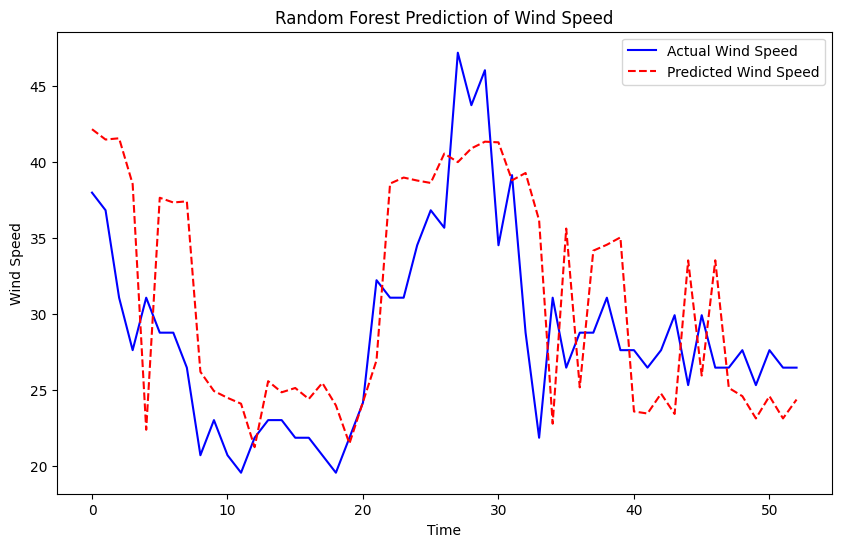

In [22]:
# Create lagged features for time series
def create_lagged_features(df, lag=3):
    df_lagged = df.copy()
    for col in df.columns:
        for l in range(1, lag + 1):
            df_lagged[f'{col}_lag_{l}'] = df[col].shift(l)
    return df_lagged.dropna()

# Create lagged features
lagged_data = create_lagged_features(KCOF[['Temperature', 'Relative_Humidity', 'Wind_Speed', 'Pressure']], lag=3)

# Define the target variable (Wind Speed) and features (the rest)
X = lagged_data.drop(columns=['Wind_Speed'])  # Features
y = lagged_data['Wind_Speed']  # Target

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

# Initialize and train the Random Forest model
rf = RandomForestRegressor(n_estimators=100, max_depth=42, min_samples_split=11, random_state=65) # fine tune parameters
weights = compute_sample_weight(class_weight='balanced', y=y_train)
rf.fit(X_train, y_train)

# Make predictions
y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)
scores = cross_val_score(rf, X, y, cv=5, scoring='neg_root_mean_squared_error')
print("Cross-validated RMSE:", -scores.mean())


# Evaluate the model performance
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f'Train RMSE: {train_rmse:.2f}')
print(f'Test RMSE: {test_rmse:.2f}')

# Optionally, plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual Wind Speed', color='blue')
plt.plot(y_pred_test, label='Predicted Wind Speed', color='red', linestyle='dashed')
plt.legend()
plt.title('Random Forest Prediction of Wind Speed')
plt.xlabel('Time')
plt.ylabel('Wind Speed')
plt.show()

Cross-validated RMSE: 4.5093515555480534
Train RMSE: 2.16
Test RMSE: 6.86


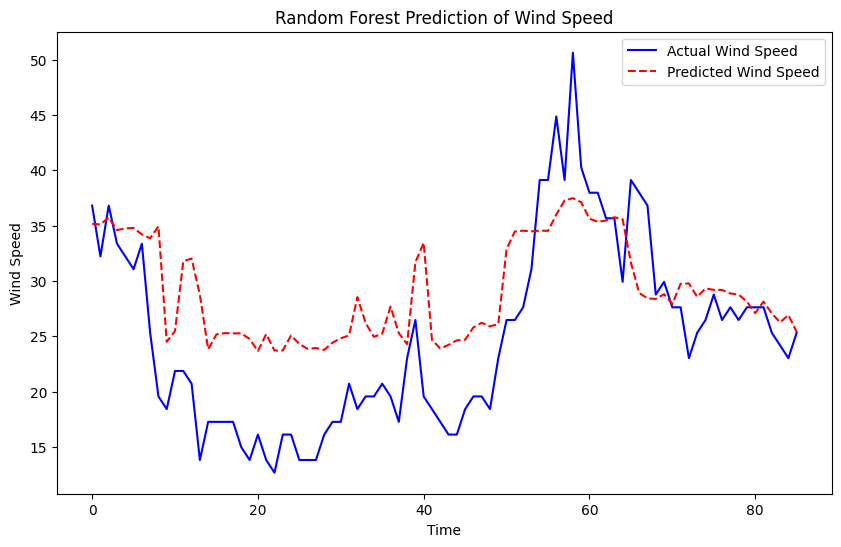

In [23]:
# Create lagged features for time series
def create_lagged_features(df, lag=3):
    df_lagged = df.copy()
    for col in df.columns:
        for l in range(1, lag + 1):
            df_lagged[f'{col}_lag_{l}'] = df[col].shift(l)
    return df_lagged.dropna()

# Create lagged features
lagged_data = create_lagged_features(KXMR[['Temperature', 'Relative_Humidity', 'Wind_Speed', 'Pressure']], lag=3)

# Define the target variable (Wind Speed) and features (the rest)
X = lagged_data.drop(columns=['Wind_Speed'])  # Features
y = lagged_data['Wind_Speed']  # Target

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

# Initialize and train the Random Forest model
rf = RandomForestRegressor(n_estimators=100, max_depth=42, min_samples_split=11, random_state=65) # fine tune parameters
weights = compute_sample_weight(class_weight='balanced', y=y_train)
rf.fit(X_train, y_train)

# Make predictions
y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)
scores = cross_val_score(rf, X, y, cv=5, scoring='neg_root_mean_squared_error')
print("Cross-validated RMSE:", -scores.mean())


# Evaluate the model performance
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f'Train RMSE: {train_rmse:.2f}')
print(f'Test RMSE: {test_rmse:.2f}')

# Optionally, plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual Wind Speed', color='blue')
plt.plot(y_pred_test, label='Predicted Wind Speed', color='red', linestyle='dashed')
plt.legend()
plt.title('Random Forest Prediction of Wind Speed')
plt.xlabel('Time')
plt.ylabel('Wind Speed')
plt.show()

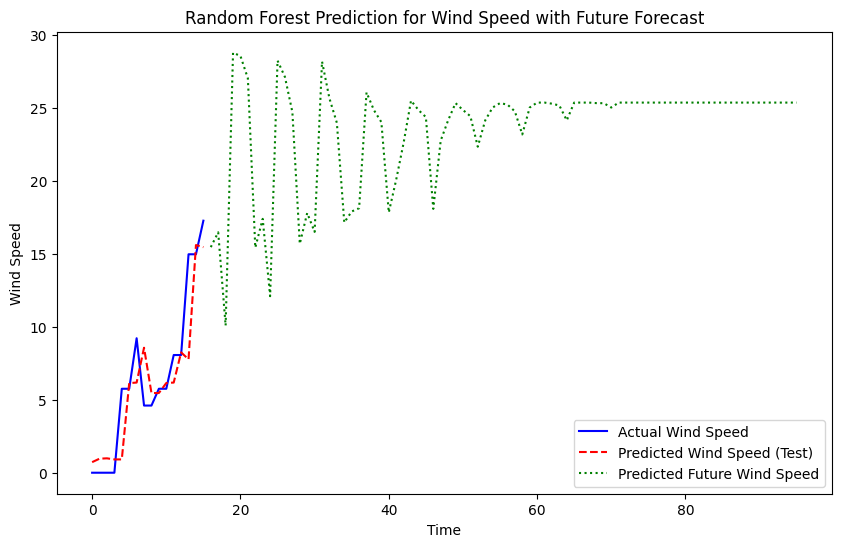

Train RMSE: 2.40
Test RMSE: 2.64
Cross-validated RMSE: 3.2256697594867965
Mean Wind Speed for KTIX:  23.589372705993195


In [ ]:
# Prediction KTIX wind speed data using KMLB and KCOF
# Create lagged features
def create_lagged_features(df, lag=3):
    df_lagged = df.copy()
    for col in df.columns:
        for l in range(1, lag + 1):
            df_lagged[f'{col}_lag_{l}'] = df[col].shift(l)
    return df_lagged.dropna()

# Prepare the training datasets
lagged_kmlb = create_lagged_features(KMLB[['Temperature', 'Relative_Humidity', 'Wind_Speed', 'Pressure']], lag=3)
lagged_kcof = create_lagged_features(KCOF[['Temperature', 'Relative_Humidity', 'Wind_Speed', 'Pressure']], lag=3)
#lagged_kxmr = create_lagged_features(KXMR[['Temperature', 'Relative_Humidity', 'Wind_Speed', 'Pressure']], lag=3)

# Combine the training datasets
training_data = pd.concat([lagged_kmlb, lagged_kcof, ])

# Define training features and target
X_train = training_data.drop(columns=['Wind_Speed'])  # Features
y_train = training_data['Wind_Speed']  # Target

# Prepare the test dataset (KTIX)
lagged_ktix = create_lagged_features(KTIX[['Temperature', 'Relative_Humidity', 'Wind_Speed', 'Pressure']], lag=3)
X_test = lagged_ktix.drop(columns=['Wind_Speed'])  # Features
y_test = lagged_ktix['Wind_Speed']  # Target

# Initialize and train the Random Forest model
rf = RandomForestRegressor(n_estimators=1000, max_depth=50, min_samples_split=50, random_state=65)
weights = compute_sample_weight(class_weight='balanced', y=y_train)
rf.fit(X_train, y_train)

# Make predictions
y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)

# Number of future time steps to predict
future_steps = 80

# Number of future time steps to predict
future_steps = 80

# Get the original feature names
feature_names = X_test.columns

# Prepare initial input for prediction (last row of the test dataset)
last_lagged_data = X_test.iloc[-1, :].values.reshape(1, -1)

# Convert to a DataFrame with valid feature names
last_lagged_df = pd.DataFrame(last_lagged_data, columns=feature_names)

# Initialize a list to store predictions
future_predictions = []

# Iterative prediction
for _ in range(future_steps):
    # Predict the next time step
    next_prediction = rf.predict(last_lagged_df)[0]
    future_predictions.append(next_prediction)

    # Update input for the next prediction
    # Shift the lagged features and insert the new prediction
    new_input = np.roll(last_lagged_df.values, shift=-1, axis=1)
    new_input[0, -1] = next_prediction  # Replace the last feature with the new prediction

    # Update the DataFrame with valid feature names
    last_lagged_df = pd.DataFrame(new_input, columns=feature_names)

# Create a time axis for plotting
future_time_axis = np.arange(len(y_test), len(y_test) + future_steps)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual Wind Speed', color='blue')
plt.plot(np.arange(len(y_test)), y_pred_test, label='Predicted Wind Speed (Test)', color='red', linestyle='dashed')
plt.plot(future_time_axis, future_predictions, label='Predicted Future Wind Speed', color='green', linestyle='dotted')
plt.legend()
plt.title('Random Forest Prediction for Wind Speed with Future Forecast')
plt.xlabel('Time')
plt.ylabel('Wind Speed')
plt.show()


# Evaluate the model performance
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f'Train RMSE: {train_rmse:.2f}')
print(f'Test RMSE: {test_rmse:.2f}')

# Cross-validated RMSE
scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
print("Cross-validated RMSE:", -scores.mean())

print('Mean Wind Speed for KTIX: ', statistics.mean(future_predictions))

[I 2024-12-05 04:46:09,939] A new study created in memory with name: no-name-ef4880f6-ccac-4aa1-86b8-9804678d4703
[I 2024-12-05 04:46:18,358] Trial 0 finished with value: 3.036038917330823 and parameters: {'n_estimators': 300, 'max_depth': 45, 'min_samples_split': 48}. Best is trial 0 with value: 3.036038917330823.
[I 2024-12-05 04:46:20,713] Trial 1 finished with value: 3.003492686394897 and parameters: {'n_estimators': 100, 'max_depth': 23, 'min_samples_split': 30}. Best is trial 1 with value: 3.003492686394897.
[I 2024-12-05 04:46:31,501] Trial 2 finished with value: 2.9667086412799732 and parameters: {'n_estimators': 500, 'max_depth': 12, 'min_samples_split': 25}. Best is trial 2 with value: 2.9667086412799732.
[I 2024-12-05 04:46:34,891] Trial 3 finished with value: 3.1736085694365035 and parameters: {'n_estimators': 100, 'max_depth': 28, 'min_samples_split': 9}. Best is trial 2 with value: 2.9667086412799732.
[I 2024-12-05 04:46:37,000] Trial 4 finished with value: 2.997848199477

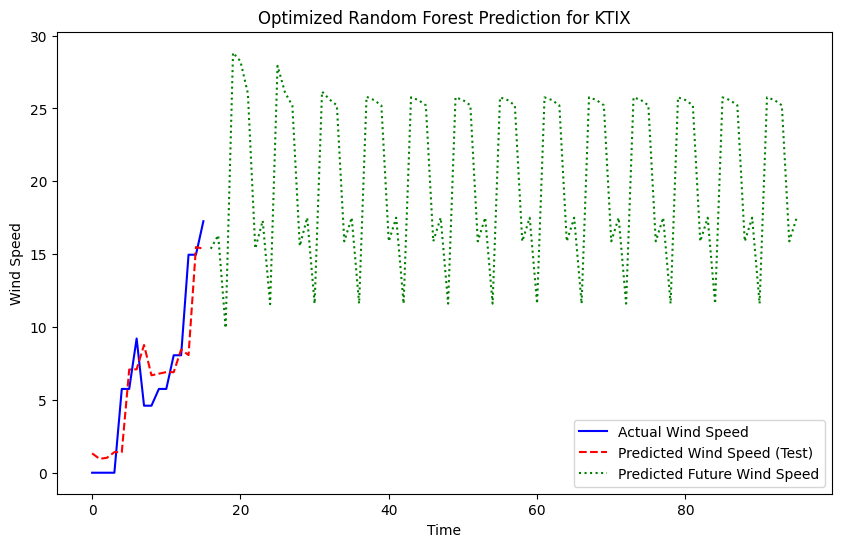

Train RMSE: 2.41
Test RMSE: 2.59
Cross-validated RMSE: 2.950203479971121
Mean Wind Speed for KTIX: 20.23165540450915


In [24]:
#Optuna + Random Forest for predicting KTIX WIND SPEED

# Function to create lagged features
def create_lagged_features(df, lag=3):
    df_lagged = df.copy()
    for col in df.columns:
        for l in range(1, lag + 1):
            df_lagged[f'{col}_lag_{l}'] = df[col].shift(l)
    return df_lagged.dropna()

# Prepare the training datasets
lagged_kmlb = create_lagged_features(KMLB[['Temperature', 'Relative_Humidity', 'Wind_Speed', 'Pressure']], lag=3)
lagged_kcof = create_lagged_features(KCOF[['Temperature', 'Relative_Humidity', 'Wind_Speed', 'Pressure']], lag=3)

# Combine the training datasets
training_data = pd.concat([lagged_kmlb, lagged_kcof])

# Define training features and target
X_train = training_data.drop(columns=['Wind_Speed'])  # Features
y_train = training_data['Wind_Speed']  # Target

# Prepare the test dataset (KTIX)
lagged_ktix = create_lagged_features(KTIX[['Temperature', 'Relative_Humidity', 'Wind_Speed', 'Pressure']], lag=3)
X_test = lagged_ktix.drop(columns=['Wind_Speed'])  # Features
y_test = lagged_ktix['Wind_Speed']  # Target

# Optuna objective function
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 500, step=100)
    max_depth = trial.suggest_int('max_depth', 5, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 50)

    rf = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        random_state=65
    )

    weights = compute_sample_weight(class_weight='balanced', y=y_train)
    rf.fit(X_train, y_train, sample_weight=weights)

    scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
    return -scores.mean()

# Optimize hyperparameters with Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Use the best parameters for the final model
best_params = study.best_params

rf_optimized = RandomForestRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    random_state=65
)

# Train with the best parameters
rf_optimized.fit(X_train, y_train)

# Predictions for test set
y_pred_test = rf_optimized.predict(X_test)

# Future predictions
future_steps = 80
feature_names = X_test.columns
last_lagged_data = X_test.iloc[-1, :].values.reshape(1, -1)
last_lagged_df = pd.DataFrame(last_lagged_data, columns=feature_names)
future_predictions = []

for _ in range(future_steps):
    next_prediction = rf_optimized.predict(last_lagged_df)[0]
    future_predictions.append(next_prediction)
    new_input = np.roll(last_lagged_df.values, shift=-1, axis=1)
    new_input[0, -1] = next_prediction
    last_lagged_df = pd.DataFrame(new_input, columns=feature_names)

# Plot results
future_time_axis = np.arange(len(y_test), len(y_test) + future_steps)

plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual Wind Speed', color='blue')
plt.plot(np.arange(len(y_test)), y_pred_test, label='Predicted Wind Speed (Test)', color='red', linestyle='dashed')
plt.plot(future_time_axis, future_predictions, label='Predicted Future Wind Speed', color='green', linestyle='dotted')
plt.legend()
plt.title('Optimized Random Forest Prediction for KTIX')
plt.xlabel('Time')
plt.ylabel('Wind Speed')
plt.show()

# Evaluation
train_rmse = np.sqrt(mean_squared_error(y_train, rf_optimized.predict(X_train)))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(f'Train RMSE: {train_rmse:.2f}')
print(f'Test RMSE: {test_rmse:.2f}')

# Cross-validation score
scores = cross_val_score(rf_optimized, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
print("Cross-validated RMSE:", -scores.mean())

# Mean of future predictions
print('Mean Wind Speed for KTIX:', statistics.mean(future_predictions))

In [25]:
print(max(future_predictions))

28.822709448124332


# **TABNET**

In [ ]:
# Load data
weather_data = pd.read_csv('/content/drive/My Drive/HurricaneIan/KMLB_csv.csv')

# Convert Time column to datetime
weather_data['Time'] = pd.to_datetime(weather_data['Time'], format='%m/%d/%Y %H:%M UTC')

# Sort by Time for proper time series alignment
weather_data = weather_data.sort_values(by='Time')
weather_data.dropna(inplace=True)

# Filter data for KMLB station
kmlb_data = weather_data[weather_data['Station'] == 'KMLB']

# Select features and target
features = ['Temperature', 'Relative_Humidity', 'Wind_Direction', 'Pressure']
target = 'Wind_Speed'

X = kmlb_data[features].values
y = kmlb_data[target].values

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Convert data to numpy arrays for TabNet
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

# Initialize TabNet Regressor
tabnet = TabNetRegressor()
# Reshape y_train and y_test to 2D arrays
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# Continue with TabNet fitting and prediction
tabnet.fit(
    X_train, y_train,
    max_epochs=100,
    patience=10,
    batch_size=256,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)

# Predict and evaluate
y_pred = tabnet.predict(X_test)

# Convert predictions back to 1D for comparison
y_pred = y_pred.flatten()

# Display results
results = {
    "Actual Wind Speed": y_test,
    "Predicted Wind Speed": y_pred.flatten()
}



/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 209.45187|  0:00:01s
epoch 1  | loss: 168.11622|  0:00:02s
epoch 2  | loss: 135.01244|  0:00:02s
epoch 3  | loss: 106.33517|  0:00:02s
epoch 4  | loss: 76.11931|  0:00:02s
epoch 5  | loss: 52.43822|  0:00:02s
epoch 6  | loss: 34.16032|  0:00:02s
epoch 7  | loss: 23.79893|  0:00:02s
epoch 8  | loss: 18.39726|  0:00:02s
epoch 9  | loss: 18.80214|  0:00:02s
epoch 10 | loss: 17.41866|  0:00:02s
epoch 11 | loss: 15.07389|  0:00:02s
epoch 12 | loss: 11.02766|  0:00:02s
epoch 13 | loss: 11.17632|  0:00:02s
epoch 14 | loss: 11.59902|  0:00:02s
epoch 15 | loss: 9.24508 |  0:00:02s
epoch 16 | loss: 9.35482 |  0:00:03s
epoch 17 | loss: 10.4206 |  0:00:03s
epoch 18 | loss: 9.63249 |  0:00:03s
epoch 19 | loss: 10.36673|  0:00:03s
epoch 20 | loss: 9.65634 |  0:00:03s
epoch 21 | loss: 9.96089 |  0:00:03s
epoch 22 | loss: 9.23934 |  0:00:03s
epoch 23 | loss: 10.93976|  0:00:03s
epoch 24 | loss: 8.05297 |  0:00:03s
epoch 25 | loss: 8.09835 |  0:00:03s
epoch 26 | loss: 9.54542 |  0:00:0

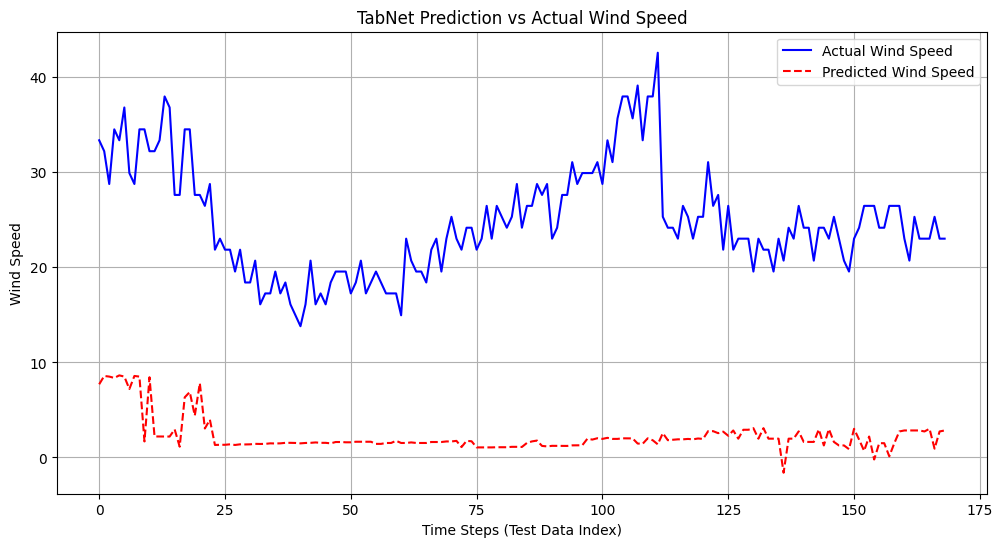

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.flatten(), label="Actual Wind Speed", color="blue")
plt.plot(y_pred, label="Predicted Wind Speed", color="red", linestyle="--")
plt.title("TabNet Prediction vs Actual Wind Speed")
plt.xlabel("Time Steps (Test Data Index)")
plt.ylabel("Wind Speed")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

Mean Absolute Error (MAE): 22.62
Root Mean Squared Error (RMSE): 23.23
R² Score: -15.32


Feature: Temperature, Importance: 0.1500
Feature: Relative_Humidity, Importance: 0.1238
Feature: Wind_Direction, Importance: 0.2507
Feature: Pressure, Importance: 0.4755


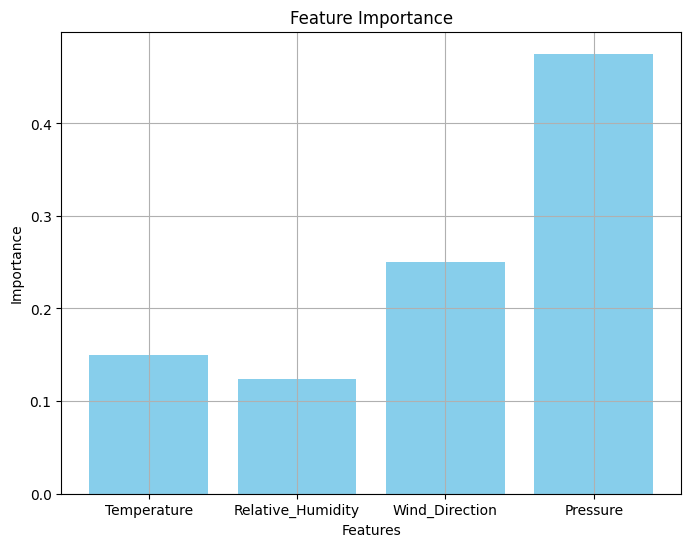

In [ ]:
# Get feature importance
feature_importances = tabnet.feature_importances_

# Display feature importance
for i, feature in enumerate(features):
    print(f"Feature: {feature}, Importance: {feature_importances[i]:.4f}")

# Plot feature importance
plt.figure(figsize=(8, 6))
plt.bar(features, feature_importances, color='skyblue')
plt.title("Feature Importance")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.grid(True)
plt.show()

In [ ]:
def objective(trial):
    # Define hyperparameters to tune
    n_d = trial.suggest_int('n_d', 8, 64, step=8)  # Number of decision steps
    n_a = trial.suggest_int('n_a', 8, 64, step=8)  # Number of attention steps
    n_steps = trial.suggest_int('n_steps', 3, 10)  # Total steps in the network
    gamma = trial.suggest_float('gamma', 1.0, 2.0)  # Regularization strength
    lambda_sparse = trial.suggest_float('lambda_sparse', 0.0001, 0.01, log=True)  # Sparsity regularization
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.2, step=0.01)  # Learning rate
    n_shared = trial.suggest_int('n_shared', 1, 5)  # Shared Gated Linear Units
    n_independent = trial.suggest_int('n_independent', 1, 5)  # Independent Gated Linear Units

    # Initialize TabNet model with trial hyperparameters
    tabnet = TabNetRegressor(
        n_d=n_d,
        n_a=n_a,
        n_steps=n_steps,
        gamma=gamma,
        lambda_sparse=lambda_sparse,
        n_shared=n_shared,
        n_independent=n_independent
    )

    # Train TabNet
    tabnet.fit(
        X_train, y_train,
        max_epochs=100,
        patience=10,
        batch_size=256,
        virtual_batch_size=128,
        num_workers=0,
        drop_last=False
    )

    # Predict on test data
    y_pred = tabnet.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    return rmse  # Optuna minimizes this score

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Print the best trial
print("Best Trial:")
print(f"  Value: {study.best_trial.value}")
print(f"  Params: {study.best_trial.params}")


[I 2024-12-01 03:32:53,461] A new study created in memory with name: no-name-33f294d1-f033-4c2a-922c-5cd5deefd035
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 358.87577|  0:00:01s
epoch 1  | loss: 84.87086|  0:00:01s
epoch 2  | loss: 37.33472|  0:00:02s
epoch 3  | loss: 20.24142|  0:00:02s
epoch 4  | loss: 14.94755|  0:00:02s
epoch 5  | loss: 12.95445|  0:00:03s
epoch 6  | loss: 12.20989|  0:00:03s
epoch 7  | loss: 12.08398|  0:00:03s
epoch 8  | loss: 16.95077|  0:00:03s
epoch 9  | loss: 20.03731|  0:00:03s
epoch 10 | loss: 12.2779 |  0:00:04s
epoch 11 | loss: 10.85963|  0:00:04s
epoch 12 | loss: 9.62388 |  0:00:04s
epoch 13 | loss: 10.3139 |  0:00:04s
epoch 14 | loss: 9.04448 |  0:00:04s
epoch 15 | loss: 13.81621|  0:00:05s
epoch 16 | loss: 15.66038|  0:00:05s
epoch 17 | loss: 13.48361|  0:00:05s
epoch 18 | loss: 9.83585 |  0:00:05s
epoch 19 | loss: 10.12048|  0:00:05s
epoch 20 | loss: 11.13229|  0:00:06s
epoch 21 | loss: 10.03356|  0:00:06s
epoch 22 | loss: 9.34041 |  0:00:06s
epoch 23 | loss: 8.76991 |  0:00:06s
epoch 24 | loss: 8.07161 |  0:00:07s
epoch 25 | loss: 7.69643 |  0:00:07s
epoch 26 | loss: 7.3422  |  0:00:07s


[I 2024-12-01 03:33:17,791] Trial 0 finished with value: 19.773040771484375 and parameters: {'n_d': 32, 'n_a': 8, 'n_steps': 10, 'gamma': 1.200336839822735, 'lambda_sparse': 0.00034076078334620166, 'learning_rate': 0.2, 'n_shared': 2, 'n_independent': 3}. Best is trial 0 with value: 19.773040771484375.


epoch 99 | loss: 6.16421 |  0:00:24s


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 207.25728|  0:00:00s
epoch 1  | loss: 151.70344|  0:00:00s
epoch 2  | loss: 95.68708|  0:00:00s
epoch 3  | loss: 40.154  |  0:00:00s
epoch 4  | loss: 18.52251|  0:00:00s
epoch 5  | loss: 25.62105|  0:00:00s
epoch 6  | loss: 32.19579|  0:00:00s
epoch 7  | loss: 22.31484|  0:00:01s
epoch 8  | loss: 17.27013|  0:00:01s
epoch 9  | loss: 14.93099|  0:00:01s
epoch 10 | loss: 13.75149|  0:00:01s
epoch 11 | loss: 13.74996|  0:00:01s
epoch 12 | loss: 14.55189|  0:00:01s
epoch 13 | loss: 12.01372|  0:00:02s
epoch 14 | loss: 11.59168|  0:00:02s
epoch 15 | loss: 9.55645 |  0:00:02s
epoch 16 | loss: 9.37522 |  0:00:02s
epoch 17 | loss: 10.73832|  0:00:02s
epoch 18 | loss: 9.00928 |  0:00:03s
epoch 19 | loss: 8.12554 |  0:00:03s
epoch 20 | loss: 10.94614|  0:00:03s
epoch 21 | loss: 9.7861  |  0:00:03s
epoch 22 | loss: 10.50777|  0:00:03s
epoch 23 | loss: 8.0024  |  0:00:04s
epoch 24 | loss: 7.78089 |  0:00:04s
epoch 25 | loss: 7.7654  |  0:00:04s
epoch 26 | loss: 8.75309 |  0:00:04s

[I 2024-12-01 03:33:32,031] Trial 1 finished with value: 8.927281379699707 and parameters: {'n_d': 16, 'n_a': 16, 'n_steps': 3, 'gamma': 1.3195980802133889, 'lambda_sparse': 0.0003947690885126945, 'learning_rate': 0.04, 'n_shared': 5, 'n_independent': 5}. Best is trial 1 with value: 8.927281379699707.


epoch 99 | loss: 5.88588 |  0:00:14s


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 280.33371|  0:00:00s
epoch 1  | loss: 65.31381|  0:00:00s
epoch 2  | loss: 35.99368|  0:00:01s
epoch 3  | loss: 32.18413|  0:00:01s
epoch 4  | loss: 30.62114|  0:00:02s
epoch 5  | loss: 18.70193|  0:00:02s
epoch 6  | loss: 18.16465|  0:00:03s
epoch 7  | loss: 16.2168 |  0:00:03s
epoch 8  | loss: 18.49963|  0:00:04s
epoch 9  | loss: 17.0835 |  0:00:04s
epoch 10 | loss: 20.17414|  0:00:05s
epoch 11 | loss: 17.4123 |  0:00:05s
epoch 12 | loss: 14.22051|  0:00:05s
epoch 13 | loss: 12.28323|  0:00:06s
epoch 14 | loss: 14.13527|  0:00:06s
epoch 15 | loss: 15.23078|  0:00:06s
epoch 16 | loss: 14.64428|  0:00:07s
epoch 17 | loss: 13.59907|  0:00:07s
epoch 18 | loss: 15.11211|  0:00:07s
epoch 19 | loss: 17.17697|  0:00:08s
epoch 20 | loss: 12.47137|  0:00:08s
epoch 21 | loss: 14.65151|  0:00:09s
epoch 22 | loss: 13.96547|  0:00:09s
epoch 23 | loss: 13.58128|  0:00:09s
epoch 24 | loss: 9.27083 |  0:00:10s
epoch 25 | loss: 9.81369 |  0:00:10s
epoch 26 | loss: 10.14049|  0:00:10s


[I 2024-12-01 03:34:12,555] Trial 2 finished with value: 19.321243286132812 and parameters: {'n_d': 56, 'n_a': 8, 'n_steps': 10, 'gamma': 1.20988368845903, 'lambda_sparse': 0.00018649149004283614, 'learning_rate': 0.19, 'n_shared': 5, 'n_independent': 5}. Best is trial 1 with value: 8.927281379699707.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 117.05473|  0:00:00s
epoch 1  | loss: 42.43592|  0:00:00s
epoch 2  | loss: 34.96048|  0:00:00s
epoch 3  | loss: 33.03006|  0:00:01s
epoch 4  | loss: 27.72907|  0:00:01s
epoch 5  | loss: 24.1149 |  0:00:01s
epoch 6  | loss: 36.54871|  0:00:01s
epoch 7  | loss: 22.88768|  0:00:02s
epoch 8  | loss: 20.69905|  0:00:02s
epoch 9  | loss: 19.22384|  0:00:02s
epoch 10 | loss: 16.8061 |  0:00:03s
epoch 11 | loss: 17.45601|  0:00:03s
epoch 12 | loss: 11.25789|  0:00:03s
epoch 13 | loss: 12.23647|  0:00:04s
epoch 14 | loss: 12.18179|  0:00:04s
epoch 15 | loss: 12.68958|  0:00:04s
epoch 16 | loss: 10.52516|  0:00:04s
epoch 17 | loss: 12.77322|  0:00:05s
epoch 18 | loss: 13.26437|  0:00:05s
epoch 19 | loss: 10.5299 |  0:00:05s
epoch 20 | loss: 12.2751 |  0:00:05s
epoch 21 | loss: 12.68349|  0:00:05s
epoch 22 | loss: 13.50186|  0:00:06s
epoch 23 | loss: 11.49781|  0:00:06s
epoch 24 | loss: 12.33863|  0:00:06s
epoch 25 | loss: 12.39151|  0:00:06s
epoch 26 | loss: 10.01957|  0:00:07s


[I 2024-12-01 03:34:36,914] Trial 3 finished with value: 20.454906463623047 and parameters: {'n_d': 24, 'n_a': 32, 'n_steps': 10, 'gamma': 1.649366056751478, 'lambda_sparse': 0.00036147268207163815, 'learning_rate': 0.2, 'n_shared': 1, 'n_independent': 4}. Best is trial 1 with value: 8.927281379699707.


epoch 99 | loss: 7.72979 |  0:00:24s


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 206.76883|  0:00:00s
epoch 1  | loss: 111.6705|  0:00:00s
epoch 2  | loss: 56.22269|  0:00:00s
epoch 3  | loss: 28.95204|  0:00:00s
epoch 4  | loss: 21.90929|  0:00:00s
epoch 5  | loss: 17.2824 |  0:00:00s
epoch 6  | loss: 15.55959|  0:00:00s
epoch 7  | loss: 16.76575|  0:00:00s
epoch 8  | loss: 15.60793|  0:00:00s
epoch 9  | loss: 14.20843|  0:00:00s
epoch 10 | loss: 14.23088|  0:00:00s
epoch 11 | loss: 15.45893|  0:00:01s
epoch 12 | loss: 11.89676|  0:00:01s
epoch 13 | loss: 10.0674 |  0:00:01s
epoch 14 | loss: 10.00821|  0:00:01s
epoch 15 | loss: 9.97933 |  0:00:01s
epoch 16 | loss: 11.44368|  0:00:01s
epoch 17 | loss: 8.92922 |  0:00:01s
epoch 18 | loss: 9.67338 |  0:00:01s
epoch 19 | loss: 8.81713 |  0:00:01s
epoch 20 | loss: 8.12022 |  0:00:01s
epoch 21 | loss: 8.25751 |  0:00:01s
epoch 22 | loss: 7.94432 |  0:00:02s
epoch 23 | loss: 8.32037 |  0:00:02s
epoch 24 | loss: 7.30907 |  0:00:02s
epoch 25 | loss: 6.88919 |  0:00:02s
epoch 26 | loss: 6.70948 |  0:00:02s


[I 2024-12-01 03:34:46,966] Trial 4 finished with value: 19.329349517822266 and parameters: {'n_d': 16, 'n_a': 56, 'n_steps': 4, 'gamma': 1.8070508725758812, 'lambda_sparse': 0.0001769421969281083, 'learning_rate': 0.13, 'n_shared': 1, 'n_independent': 3}. Best is trial 1 with value: 8.927281379699707.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 131.09041|  0:00:00s
epoch 1  | loss: 29.00382|  0:00:00s
epoch 2  | loss: 20.07185|  0:00:00s
epoch 3  | loss: 13.70817|  0:00:00s
epoch 4  | loss: 15.25116|  0:00:00s
epoch 5  | loss: 14.64494|  0:00:00s
epoch 6  | loss: 13.81333|  0:00:00s
epoch 7  | loss: 12.56732|  0:00:01s
epoch 8  | loss: 11.21652|  0:00:01s
epoch 9  | loss: 10.36242|  0:00:01s
epoch 10 | loss: 11.19061|  0:00:01s
epoch 11 | loss: 11.87739|  0:00:01s
epoch 12 | loss: 12.36515|  0:00:01s
epoch 13 | loss: 9.45491 |  0:00:01s
epoch 14 | loss: 9.88949 |  0:00:01s
epoch 15 | loss: 9.36878 |  0:00:02s
epoch 16 | loss: 10.93288|  0:00:02s
epoch 17 | loss: 10.41372|  0:00:02s
epoch 18 | loss: 11.38676|  0:00:02s
epoch 19 | loss: 10.37895|  0:00:02s
epoch 20 | loss: 11.28463|  0:00:02s
epoch 21 | loss: 10.92023|  0:00:02s
epoch 22 | loss: 11.07141|  0:00:02s
epoch 23 | loss: 10.33456|  0:00:03s
epoch 24 | loss: 12.13936|  0:00:03s
epoch 25 | loss: 10.85494|  0:00:03s
epoch 26 | loss: 9.30684 |  0:00:03s


[I 2024-12-01 03:35:00,829] Trial 5 finished with value: 18.69951820373535 and parameters: {'n_d': 40, 'n_a': 40, 'n_steps': 4, 'gamma': 1.7516778701561866, 'lambda_sparse': 0.0002673780219192285, 'learning_rate': 0.06999999999999999, 'n_shared': 4, 'n_independent': 3}. Best is trial 1 with value: 8.927281379699707.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 178.05279|  0:00:00s
epoch 1  | loss: 89.12473|  0:00:00s
epoch 2  | loss: 52.86722|  0:00:00s
epoch 3  | loss: 31.37325|  0:00:00s
epoch 4  | loss: 26.75316|  0:00:00s
epoch 5  | loss: 22.45167|  0:00:01s
epoch 6  | loss: 19.36292|  0:00:01s
epoch 7  | loss: 17.23603|  0:00:01s
epoch 8  | loss: 19.75601|  0:00:01s
epoch 9  | loss: 18.65007|  0:00:01s
epoch 10 | loss: 17.51502|  0:00:01s
epoch 11 | loss: 19.95328|  0:00:01s
epoch 12 | loss: 19.09579|  0:00:02s
epoch 13 | loss: 19.50305|  0:00:02s
epoch 14 | loss: 18.08075|  0:00:02s
epoch 15 | loss: 19.7368 |  0:00:02s
epoch 16 | loss: 18.37988|  0:00:02s
epoch 17 | loss: 14.71548|  0:00:02s
epoch 18 | loss: 13.75007|  0:00:03s
epoch 19 | loss: 15.75563|  0:00:03s
epoch 20 | loss: 13.33796|  0:00:03s
epoch 21 | loss: 13.60586|  0:00:03s
epoch 22 | loss: 13.84319|  0:00:03s
epoch 23 | loss: 14.2575 |  0:00:03s
epoch 24 | loss: 13.12455|  0:00:04s
epoch 25 | loss: 11.57929|  0:00:04s
epoch 26 | loss: 10.02733|  0:00:04s


[I 2024-12-01 03:35:18,531] Trial 6 finished with value: 21.235044479370117 and parameters: {'n_d': 24, 'n_a': 48, 'n_steps': 4, 'gamma': 1.6109333102647052, 'lambda_sparse': 0.00015314067579910799, 'learning_rate': 0.04, 'n_shared': 5, 'n_independent': 5}. Best is trial 1 with value: 8.927281379699707.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 192.30359|  0:00:00s
epoch 1  | loss: 33.12831|  0:00:00s
epoch 2  | loss: 24.47093|  0:00:00s
epoch 3  | loss: 21.35962|  0:00:00s
epoch 4  | loss: 16.86895|  0:00:01s
epoch 5  | loss: 16.07223|  0:00:01s
epoch 6  | loss: 14.83252|  0:00:01s
epoch 7  | loss: 21.31809|  0:00:01s
epoch 8  | loss: 15.14183|  0:00:02s
epoch 9  | loss: 15.66619|  0:00:02s
epoch 10 | loss: 11.5006 |  0:00:02s
epoch 11 | loss: 11.49396|  0:00:02s
epoch 12 | loss: 11.3363 |  0:00:03s
epoch 13 | loss: 9.21573 |  0:00:03s
epoch 14 | loss: 10.39573|  0:00:03s
epoch 15 | loss: 10.96646|  0:00:03s
epoch 16 | loss: 8.33475 |  0:00:04s
epoch 17 | loss: 8.29362 |  0:00:04s
epoch 18 | loss: 10.17914|  0:00:04s
epoch 19 | loss: 10.39342|  0:00:05s
epoch 20 | loss: 9.32955 |  0:00:05s
epoch 21 | loss: 9.01371 |  0:00:05s
epoch 22 | loss: 8.4404  |  0:00:06s
epoch 23 | loss: 7.66769 |  0:00:06s
epoch 24 | loss: 9.06408 |  0:00:06s
epoch 25 | loss: 9.27428 |  0:00:07s
epoch 26 | loss: 9.06695 |  0:00:07s


[I 2024-12-01 03:35:43,526] Trial 7 finished with value: 20.91078758239746 and parameters: {'n_d': 56, 'n_a': 8, 'n_steps': 8, 'gamma': 1.0957175410299986, 'lambda_sparse': 0.0015845176276825877, 'learning_rate': 0.12, 'n_shared': 3, 'n_independent': 4}. Best is trial 1 with value: 8.927281379699707.


epoch 99 | loss: 5.69806 |  0:00:24s


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 152.07617|  0:00:00s
epoch 1  | loss: 31.5616 |  0:00:00s
epoch 2  | loss: 26.38904|  0:00:00s
epoch 3  | loss: 18.84578|  0:00:01s
epoch 4  | loss: 20.44131|  0:00:01s
epoch 5  | loss: 26.46428|  0:00:01s
epoch 6  | loss: 18.09153|  0:00:01s
epoch 7  | loss: 14.46153|  0:00:02s
epoch 8  | loss: 14.7236 |  0:00:02s
epoch 9  | loss: 13.08946|  0:00:02s
epoch 10 | loss: 11.96568|  0:00:03s
epoch 11 | loss: 14.74227|  0:00:03s
epoch 12 | loss: 15.54137|  0:00:03s
epoch 13 | loss: 10.72123|  0:00:03s
epoch 14 | loss: 11.80935|  0:00:04s
epoch 15 | loss: 11.60062|  0:00:04s
epoch 16 | loss: 12.99427|  0:00:04s
epoch 17 | loss: 10.46937|  0:00:04s
epoch 18 | loss: 9.17434 |  0:00:05s
epoch 19 | loss: 10.17368|  0:00:05s
epoch 20 | loss: 10.27648|  0:00:06s
epoch 21 | loss: 10.89822|  0:00:06s
epoch 22 | loss: 10.50524|  0:00:06s
epoch 23 | loss: 8.52926 |  0:00:07s
epoch 24 | loss: 9.25305 |  0:00:07s
epoch 25 | loss: 10.03496|  0:00:07s
epoch 26 | loss: 8.30214 |  0:00:08s


[I 2024-12-01 03:36:13,473] Trial 8 finished with value: 25.345420837402344 and parameters: {'n_d': 32, 'n_a': 64, 'n_steps': 10, 'gamma': 1.0528170472534772, 'lambda_sparse': 0.005482137290368799, 'learning_rate': 0.04, 'n_shared': 4, 'n_independent': 3}. Best is trial 1 with value: 8.927281379699707.


epoch 99 | loss: 5.53076 |  0:00:29s


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 265.06555|  0:00:00s
epoch 1  | loss: 144.07085|  0:00:00s
epoch 2  | loss: 72.9681 |  0:00:00s
epoch 3  | loss: 39.66209|  0:00:00s
epoch 4  | loss: 20.73505|  0:00:00s
epoch 5  | loss: 14.79649|  0:00:00s
epoch 6  | loss: 14.24383|  0:00:00s
epoch 7  | loss: 15.47841|  0:00:00s
epoch 8  | loss: 13.59141|  0:00:00s
epoch 9  | loss: 14.70638|  0:00:01s
epoch 10 | loss: 18.22584|  0:00:01s
epoch 11 | loss: 13.05107|  0:00:01s
epoch 12 | loss: 16.24091|  0:00:01s
epoch 13 | loss: 13.06475|  0:00:01s
epoch 14 | loss: 11.0733 |  0:00:01s
epoch 15 | loss: 10.27633|  0:00:01s
epoch 16 | loss: 11.63489|  0:00:01s
epoch 17 | loss: 12.40088|  0:00:01s
epoch 18 | loss: 10.86973|  0:00:01s
epoch 19 | loss: 11.17366|  0:00:02s
epoch 20 | loss: 10.08512|  0:00:02s
epoch 21 | loss: 11.5813 |  0:00:02s
epoch 22 | loss: 10.46635|  0:00:02s
epoch 23 | loss: 9.56679 |  0:00:02s
epoch 24 | loss: 9.97064 |  0:00:02s
epoch 25 | loss: 9.56209 |  0:00:02s
epoch 26 | loss: 10.13783|  0:00:02s

[I 2024-12-01 03:36:24,827] Trial 9 finished with value: 25.199501037597656 and parameters: {'n_d': 24, 'n_a': 24, 'n_steps': 4, 'gamma': 1.7191763457484468, 'lambda_sparse': 0.0019299907956657288, 'learning_rate': 0.2, 'n_shared': 4, 'n_independent': 1}. Best is trial 1 with value: 8.927281379699707.


epoch 99 | loss: 7.15655 |  0:00:11s


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 133.00851|  0:00:00s
epoch 1  | loss: 90.08241|  0:00:00s
epoch 2  | loss: 49.27987|  0:00:00s
epoch 3  | loss: 37.17675|  0:00:00s
epoch 4  | loss: 26.55039|  0:00:00s
epoch 5  | loss: 20.58772|  0:00:00s
epoch 6  | loss: 18.89745|  0:00:00s
epoch 7  | loss: 14.62143|  0:00:00s
epoch 8  | loss: 13.22348|  0:00:01s
epoch 9  | loss: 10.67793|  0:00:01s
epoch 10 | loss: 13.79843|  0:00:01s
epoch 11 | loss: 10.23388|  0:00:01s
epoch 12 | loss: 10.60352|  0:00:01s
epoch 13 | loss: 10.22571|  0:00:01s
epoch 14 | loss: 10.67731|  0:00:01s
epoch 15 | loss: 12.11428|  0:00:01s
epoch 16 | loss: 12.31368|  0:00:02s
epoch 17 | loss: 12.40782|  0:00:02s
epoch 18 | loss: 11.50133|  0:00:02s
epoch 19 | loss: 10.8138 |  0:00:02s
epoch 20 | loss: 12.19725|  0:00:02s
epoch 21 | loss: 10.17214|  0:00:02s
epoch 22 | loss: 10.07715|  0:00:02s
epoch 23 | loss: 10.43422|  0:00:02s
epoch 24 | loss: 9.76782 |  0:00:03s
epoch 25 | loss: 10.98959|  0:00:03s
epoch 26 | loss: 9.15847 |  0:00:03s


[I 2024-12-01 03:36:38,286] Trial 10 finished with value: 18.79572105407715 and parameters: {'n_d': 8, 'n_a': 24, 'n_steps': 6, 'gamma': 1.3958607970790244, 'lambda_sparse': 0.0006218820709363107, 'learning_rate': 0.01, 'n_shared': 3, 'n_independent': 1}. Best is trial 1 with value: 8.927281379699707.


epoch 98 | loss: 6.08394 |  0:00:13s
epoch 99 | loss: 6.39286 |  0:00:13s


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 144.1763|  0:00:00s
epoch 1  | loss: 44.54291|  0:00:00s
epoch 2  | loss: 31.81481|  0:00:00s
epoch 3  | loss: 26.56859|  0:00:00s
epoch 4  | loss: 23.38987|  0:00:00s
epoch 5  | loss: 21.94695|  0:00:00s
epoch 6  | loss: 21.87811|  0:00:00s
epoch 7  | loss: 20.58608|  0:00:00s
epoch 8  | loss: 16.50801|  0:00:00s
epoch 9  | loss: 14.76822|  0:00:00s
epoch 10 | loss: 13.93562|  0:00:01s
epoch 11 | loss: 12.26935|  0:00:01s
epoch 12 | loss: 11.30283|  0:00:01s
epoch 13 | loss: 12.27662|  0:00:01s
epoch 14 | loss: 11.39162|  0:00:01s
epoch 15 | loss: 12.2406 |  0:00:01s
epoch 16 | loss: 12.1892 |  0:00:01s
epoch 17 | loss: 10.98827|  0:00:01s
epoch 18 | loss: 12.09701|  0:00:01s
epoch 19 | loss: 11.05694|  0:00:01s
epoch 20 | loss: 11.51656|  0:00:01s
epoch 21 | loss: 10.14341|  0:00:02s
epoch 22 | loss: 9.75539 |  0:00:02s
epoch 23 | loss: 11.42776|  0:00:02s
epoch 24 | loss: 9.16258 |  0:00:02s
epoch 25 | loss: 10.53236|  0:00:02s
epoch 26 | loss: 8.56357 |  0:00:02s
e

[I 2024-12-01 03:36:48,842] Trial 11 finished with value: 17.55791664123535 and parameters: {'n_d': 48, 'n_a': 40, 'n_steps': 3, 'gamma': 1.9604566806114767, 'lambda_sparse': 0.0006747461263701649, 'learning_rate': 0.08, 'n_shared': 4, 'n_independent': 2}. Best is trial 1 with value: 8.927281379699707.


epoch 98 | loss: 6.5782  |  0:00:10s
epoch 99 | loss: 7.06777 |  0:00:10s


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 157.76194|  0:00:00s
epoch 1  | loss: 43.67705|  0:00:00s
epoch 2  | loss: 19.0972 |  0:00:00s
epoch 3  | loss: 16.22277|  0:00:00s
epoch 4  | loss: 18.46042|  0:00:00s
epoch 5  | loss: 14.49215|  0:00:00s
epoch 6  | loss: 16.56143|  0:00:00s
epoch 7  | loss: 14.56066|  0:00:00s
epoch 8  | loss: 10.5935 |  0:00:01s
epoch 9  | loss: 9.2303  |  0:00:01s
epoch 10 | loss: 10.0487 |  0:00:01s
epoch 11 | loss: 9.8809  |  0:00:01s
epoch 12 | loss: 12.94132|  0:00:01s
epoch 13 | loss: 9.68192 |  0:00:01s
epoch 14 | loss: 10.76023|  0:00:01s
epoch 15 | loss: 9.75361 |  0:00:01s
epoch 16 | loss: 8.41316 |  0:00:01s
epoch 17 | loss: 8.67067 |  0:00:01s
epoch 18 | loss: 8.55875 |  0:00:02s
epoch 19 | loss: 9.35782 |  0:00:02s
epoch 20 | loss: 8.81337 |  0:00:02s
epoch 21 | loss: 8.86132 |  0:00:02s
epoch 22 | loss: 8.63474 |  0:00:02s
epoch 23 | loss: 7.50907 |  0:00:02s
epoch 24 | loss: 8.766   |  0:00:02s
epoch 25 | loss: 7.84619 |  0:00:02s
epoch 26 | loss: 8.62337 |  0:00:02s


[I 2024-12-01 03:37:00,299] Trial 12 finished with value: 37.024749755859375 and parameters: {'n_d': 48, 'n_a': 24, 'n_steps': 3, 'gamma': 1.9492504810595914, 'lambda_sparse': 0.0008525965975566982, 'learning_rate': 0.08, 'n_shared': 5, 'n_independent': 2}. Best is trial 1 with value: 8.927281379699707.


epoch 99 | loss: 6.27232 |  0:00:11s


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 126.21351|  0:00:00s
epoch 1  | loss: 49.07707|  0:00:00s
epoch 2  | loss: 27.12137|  0:00:00s
epoch 3  | loss: 26.92503|  0:00:00s
epoch 4  | loss: 19.72072|  0:00:01s
epoch 5  | loss: 16.81381|  0:00:01s
epoch 6  | loss: 14.36706|  0:00:01s
epoch 7  | loss: 14.55656|  0:00:01s
epoch 8  | loss: 14.60259|  0:00:01s
epoch 9  | loss: 12.90629|  0:00:01s
epoch 10 | loss: 14.44024|  0:00:02s
epoch 11 | loss: 15.00762|  0:00:02s
epoch 12 | loss: 14.51314|  0:00:02s
epoch 13 | loss: 14.45787|  0:00:02s
epoch 14 | loss: 13.09689|  0:00:02s
epoch 15 | loss: 14.66947|  0:00:02s
epoch 16 | loss: 11.74077|  0:00:02s
epoch 17 | loss: 15.89391|  0:00:03s
epoch 18 | loss: 14.78191|  0:00:03s
epoch 19 | loss: 13.00618|  0:00:03s
epoch 20 | loss: 12.34633|  0:00:03s
epoch 21 | loss: 8.38485 |  0:00:03s
epoch 22 | loss: 11.08263|  0:00:03s
epoch 23 | loss: 8.61912 |  0:00:04s
epoch 24 | loss: 9.04666 |  0:00:04s
epoch 25 | loss: 8.10426 |  0:00:04s
epoch 26 | loss: 8.98007 |  0:00:04s


[I 2024-12-01 03:37:17,843] Trial 13 finished with value: 20.889619827270508 and parameters: {'n_d': 64, 'n_a': 40, 'n_steps': 6, 'gamma': 1.4471211947694287, 'lambda_sparse': 0.0005787736537345085, 'learning_rate': 0.09, 'n_shared': 4, 'n_independent': 2}. Best is trial 1 with value: 8.927281379699707.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 180.29358|  0:00:00s
epoch 1  | loss: 124.41225|  0:00:00s
epoch 2  | loss: 85.49629|  0:00:00s
epoch 3  | loss: 56.37983|  0:00:00s
epoch 4  | loss: 38.44962|  0:00:00s
epoch 5  | loss: 25.81914|  0:00:00s
epoch 6  | loss: 19.69268|  0:00:00s
epoch 7  | loss: 19.95671|  0:00:00s
epoch 8  | loss: 18.80465|  0:00:00s
epoch 9  | loss: 18.64536|  0:00:01s
epoch 10 | loss: 20.54772|  0:00:01s
epoch 11 | loss: 13.74707|  0:00:01s
epoch 12 | loss: 13.61106|  0:00:01s
epoch 13 | loss: 12.1177 |  0:00:01s
epoch 14 | loss: 12.44753|  0:00:01s
epoch 15 | loss: 10.30629|  0:00:01s
epoch 16 | loss: 13.10829|  0:00:01s
epoch 17 | loss: 11.58479|  0:00:01s
epoch 18 | loss: 11.21033|  0:00:01s
epoch 19 | loss: 10.75374|  0:00:02s
epoch 20 | loss: 10.43381|  0:00:02s
epoch 21 | loss: 9.73266 |  0:00:02s
epoch 22 | loss: 11.55544|  0:00:02s
epoch 23 | loss: 10.10875|  0:00:02s
epoch 24 | loss: 8.73841 |  0:00:02s
epoch 25 | loss: 8.58562 |  0:00:02s
epoch 26 | loss: 10.26927|  0:00:02s

[I 2024-12-01 03:37:29,682] Trial 14 finished with value: 18.235721588134766 and parameters: {'n_d': 8, 'n_a': 32, 'n_steps': 3, 'gamma': 1.992955081081316, 'lambda_sparse': 0.002868443875674404, 'learning_rate': 0.05, 'n_shared': 5, 'n_independent': 2}. Best is trial 1 with value: 8.927281379699707.


epoch 98 | loss: 6.79788 |  0:00:11s
epoch 99 | loss: 6.65288 |  0:00:11s


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 228.53388|  0:00:00s
epoch 1  | loss: 72.98015|  0:00:00s
epoch 2  | loss: 37.83907|  0:00:00s
epoch 3  | loss: 32.49036|  0:00:00s
epoch 4  | loss: 24.82284|  0:00:00s
epoch 5  | loss: 19.61364|  0:00:01s
epoch 6  | loss: 17.33768|  0:00:01s
epoch 7  | loss: 12.56357|  0:00:01s
epoch 8  | loss: 11.61967|  0:00:01s
epoch 9  | loss: 14.21936|  0:00:01s
epoch 10 | loss: 13.41996|  0:00:01s
epoch 11 | loss: 11.10619|  0:00:02s
epoch 12 | loss: 10.32544|  0:00:02s
epoch 13 | loss: 10.40161|  0:00:02s
epoch 14 | loss: 12.18727|  0:00:02s
epoch 15 | loss: 10.45869|  0:00:02s
epoch 16 | loss: 9.6396  |  0:00:02s
epoch 17 | loss: 8.49919 |  0:00:03s
epoch 18 | loss: 10.26657|  0:00:03s
epoch 19 | loss: 8.82552 |  0:00:03s
epoch 20 | loss: 8.13279 |  0:00:03s
epoch 21 | loss: 9.21577 |  0:00:03s
epoch 22 | loss: 8.06698 |  0:00:03s
epoch 23 | loss: 8.92964 |  0:00:04s
epoch 24 | loss: 7.81354 |  0:00:04s
epoch 25 | loss: 9.36226 |  0:00:04s
epoch 26 | loss: 12.84159|  0:00:04s


[I 2024-12-01 03:37:48,079] Trial 15 finished with value: 19.20967674255371 and parameters: {'n_d': 40, 'n_a': 16, 'n_steps': 5, 'gamma': 1.3926704809783026, 'lambda_sparse': 0.0012051017847271959, 'learning_rate': 0.01, 'n_shared': 4, 'n_independent': 4}. Best is trial 1 with value: 8.927281379699707.


epoch 99 | loss: 6.38524 |  0:00:18s


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 119.34819|  0:00:00s
epoch 1  | loss: 47.509  |  0:00:00s
epoch 2  | loss: 27.0387 |  0:00:00s
epoch 3  | loss: 22.08161|  0:00:01s
epoch 4  | loss: 22.02424|  0:00:01s
epoch 5  | loss: 19.99233|  0:00:01s
epoch 6  | loss: 14.64448|  0:00:01s
epoch 7  | loss: 14.37237|  0:00:02s
epoch 8  | loss: 14.40585|  0:00:02s
epoch 9  | loss: 22.11489|  0:00:02s
epoch 10 | loss: 13.739  |  0:00:02s
epoch 11 | loss: 13.9011 |  0:00:03s
epoch 12 | loss: 11.92315|  0:00:03s
epoch 13 | loss: 14.0795 |  0:00:03s
epoch 14 | loss: 13.8253 |  0:00:03s
epoch 15 | loss: 10.80461|  0:00:04s
epoch 16 | loss: 10.3309 |  0:00:04s
epoch 17 | loss: 8.83514 |  0:00:04s
epoch 18 | loss: 10.27455|  0:00:04s
epoch 19 | loss: 11.05393|  0:00:05s
epoch 20 | loss: 9.79131 |  0:00:05s
epoch 21 | loss: 8.98764 |  0:00:05s
epoch 22 | loss: 10.30381|  0:00:06s
epoch 23 | loss: 8.48201 |  0:00:06s
epoch 24 | loss: 8.11109 |  0:00:07s
epoch 25 | loss: 8.60698 |  0:00:07s
epoch 26 | loss: 8.93694 |  0:00:07s


[I 2024-12-01 03:38:16,092] Trial 16 finished with value: 17.64790153503418 and parameters: {'n_d': 48, 'n_a': 48, 'n_steps': 8, 'gamma': 1.2752864573929814, 'lambda_sparse': 0.009501544378326418, 'learning_rate': 0.14, 'n_shared': 3, 'n_independent': 5}. Best is trial 1 with value: 8.927281379699707.


epoch 99 | loss: 5.75036 |  0:00:27s


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 182.77154|  0:00:00s
epoch 1  | loss: 97.09583|  0:00:00s
epoch 2  | loss: 59.32533|  0:00:00s
epoch 3  | loss: 32.17632|  0:00:00s
epoch 4  | loss: 17.23801|  0:00:00s
epoch 5  | loss: 16.43508|  0:00:00s
epoch 6  | loss: 14.90886|  0:00:00s
epoch 7  | loss: 14.14558|  0:00:00s
epoch 8  | loss: 11.64495|  0:00:00s
epoch 9  | loss: 10.18563|  0:00:00s
epoch 10 | loss: 10.75869|  0:00:00s
epoch 11 | loss: 11.04716|  0:00:00s
epoch 12 | loss: 12.15804|  0:00:00s
epoch 13 | loss: 10.29769|  0:00:01s
epoch 14 | loss: 9.79448 |  0:00:01s
epoch 15 | loss: 10.64884|  0:00:01s
epoch 16 | loss: 9.54593 |  0:00:01s
epoch 17 | loss: 9.38325 |  0:00:01s
epoch 18 | loss: 7.89387 |  0:00:01s
epoch 19 | loss: 9.11523 |  0:00:01s
epoch 20 | loss: 8.8282  |  0:00:01s
epoch 21 | loss: 8.34519 |  0:00:01s
epoch 22 | loss: 9.85528 |  0:00:01s
epoch 23 | loss: 7.86522 |  0:00:01s
epoch 24 | loss: 7.70165 |  0:00:01s
epoch 25 | loss: 9.08459 |  0:00:01s
epoch 26 | loss: 8.34679 |  0:00:02s


[I 2024-12-01 03:38:24,779] Trial 17 finished with value: 20.4344425201416 and parameters: {'n_d': 16, 'n_a': 48, 'n_steps': 3, 'gamma': 1.5587919173945628, 'lambda_sparse': 0.0006024076923259386, 'learning_rate': 0.16, 'n_shared': 2, 'n_independent': 2}. Best is trial 1 with value: 8.927281379699707.


epoch 99 | loss: 7.777   |  0:00:08s


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 136.88463|  0:00:00s
epoch 1  | loss: 45.89018|  0:00:00s
epoch 2  | loss: 33.39922|  0:00:00s
epoch 3  | loss: 29.31357|  0:00:00s
epoch 4  | loss: 19.75709|  0:00:00s
epoch 5  | loss: 17.98191|  0:00:01s
epoch 6  | loss: 18.05629|  0:00:01s
epoch 7  | loss: 16.46612|  0:00:01s
epoch 8  | loss: 14.86865|  0:00:01s
epoch 9  | loss: 13.5999 |  0:00:01s
epoch 10 | loss: 13.44911|  0:00:02s
epoch 11 | loss: 11.03152|  0:00:02s
epoch 12 | loss: 12.50678|  0:00:02s
epoch 13 | loss: 11.36117|  0:00:02s
epoch 14 | loss: 11.03011|  0:00:02s
epoch 15 | loss: 9.7156  |  0:00:03s
epoch 16 | loss: 8.7621  |  0:00:03s
epoch 17 | loss: 13.11786|  0:00:03s
epoch 18 | loss: 9.19075 |  0:00:03s
epoch 19 | loss: 10.47537|  0:00:03s
epoch 20 | loss: 10.63901|  0:00:03s
epoch 21 | loss: 10.57474|  0:00:04s
epoch 22 | loss: 9.77948 |  0:00:04s
epoch 23 | loss: 7.94795 |  0:00:04s
epoch 24 | loss: 10.73922|  0:00:04s
epoch 25 | loss: 9.5027  |  0:00:04s
epoch 26 | loss: 12.30225|  0:00:05s


[I 2024-12-01 03:38:44,642] Trial 18 finished with value: 18.76010513305664 and parameters: {'n_d': 48, 'n_a': 16, 'n_steps': 5, 'gamma': 1.3040202891023516, 'lambda_sparse': 0.00010444296755052932, 'learning_rate': 0.09999999999999999, 'n_shared': 5, 'n_independent': 4}. Best is trial 1 with value: 8.927281379699707.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 101.56154|  0:00:00s
epoch 1  | loss: 44.61135|  0:00:00s
epoch 2  | loss: 26.84901|  0:00:00s
epoch 3  | loss: 29.93615|  0:00:00s
epoch 4  | loss: 22.05976|  0:00:00s
epoch 5  | loss: 18.94582|  0:00:00s
epoch 6  | loss: 21.93826|  0:00:01s
epoch 7  | loss: 17.53374|  0:00:01s
epoch 8  | loss: 17.48778|  0:00:01s
epoch 9  | loss: 34.5477 |  0:00:01s
epoch 10 | loss: 28.59048|  0:00:01s
epoch 11 | loss: 18.50931|  0:00:01s
epoch 12 | loss: 14.09131|  0:00:02s
epoch 13 | loss: 12.63681|  0:00:02s
epoch 14 | loss: 14.65796|  0:00:02s
epoch 15 | loss: 13.77677|  0:00:02s
epoch 16 | loss: 12.91079|  0:00:02s
epoch 17 | loss: 9.38891 |  0:00:02s
epoch 18 | loss: 9.81985 |  0:00:03s
epoch 19 | loss: 12.18006|  0:00:03s
epoch 20 | loss: 10.26349|  0:00:03s
epoch 21 | loss: 10.34598|  0:00:03s
epoch 22 | loss: 10.75712|  0:00:04s
epoch 23 | loss: 11.03953|  0:00:04s
epoch 24 | loss: 13.35006|  0:00:04s
epoch 25 | loss: 14.83226|  0:00:04s
epoch 26 | loss: 9.85104 |  0:00:04s


[I 2024-12-01 03:39:02,105] Trial 19 finished with value: 17.725120544433594 and parameters: {'n_d': 64, 'n_a': 32, 'n_steps': 8, 'gamma': 1.8734791166094897, 'lambda_sparse': 0.00045656194344104926, 'learning_rate': 0.060000000000000005, 'n_shared': 3, 'n_independent': 1}. Best is trial 1 with value: 8.927281379699707.


epoch 99 | loss: 9.42302 |  0:00:17s


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 221.04074|  0:00:00s
epoch 1  | loss: 121.01482|  0:00:00s
epoch 2  | loss: 72.35421|  0:00:00s
epoch 3  | loss: 38.90655|  0:00:00s
epoch 4  | loss: 22.57883|  0:00:00s
epoch 5  | loss: 18.86689|  0:00:01s
epoch 6  | loss: 13.13947|  0:00:01s
epoch 7  | loss: 11.90472|  0:00:01s
epoch 8  | loss: 11.45376|  0:00:01s
epoch 9  | loss: 12.85143|  0:00:01s
epoch 10 | loss: 13.08648|  0:00:02s
epoch 11 | loss: 12.3168 |  0:00:02s
epoch 12 | loss: 11.65818|  0:00:02s
epoch 13 | loss: 11.66365|  0:00:02s
epoch 14 | loss: 12.92911|  0:00:02s
epoch 15 | loss: 13.17966|  0:00:02s
epoch 16 | loss: 11.03302|  0:00:03s
epoch 17 | loss: 9.5752  |  0:00:03s
epoch 18 | loss: 9.63093 |  0:00:03s
epoch 19 | loss: 11.22805|  0:00:03s
epoch 20 | loss: 10.00959|  0:00:03s
epoch 21 | loss: 11.24869|  0:00:03s
epoch 22 | loss: 13.1514 |  0:00:03s
epoch 23 | loss: 10.603  |  0:00:04s
epoch 24 | loss: 10.08428|  0:00:04s
epoch 25 | loss: 9.56861 |  0:00:04s
epoch 26 | loss: 9.38178 |  0:00:04s

[I 2024-12-01 03:39:17,978] Trial 20 finished with value: 11.848410606384277 and parameters: {'n_d': 16, 'n_a': 64, 'n_steps': 5, 'gamma': 1.514079221889406, 'lambda_sparse': 0.002957972973385254, 'learning_rate': 0.03, 'n_shared': 4, 'n_independent': 2}. Best is trial 1 with value: 8.927281379699707.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 221.38025|  0:00:00s
epoch 1  | loss: 132.81013|  0:00:00s
epoch 2  | loss: 70.32999|  0:00:00s
epoch 3  | loss: 43.66012|  0:00:00s
epoch 4  | loss: 34.22856|  0:00:00s
epoch 5  | loss: 24.83762|  0:00:00s
epoch 6  | loss: 23.12923|  0:00:01s
epoch 7  | loss: 18.87479|  0:00:01s
epoch 8  | loss: 18.82084|  0:00:01s
epoch 9  | loss: 16.24725|  0:00:01s
epoch 10 | loss: 17.63424|  0:00:01s
epoch 11 | loss: 12.53811|  0:00:01s
epoch 12 | loss: 14.50425|  0:00:01s
epoch 13 | loss: 14.01753|  0:00:02s
epoch 14 | loss: 13.56544|  0:00:02s
epoch 15 | loss: 13.46592|  0:00:02s
epoch 16 | loss: 11.84802|  0:00:02s
epoch 17 | loss: 13.28771|  0:00:02s
epoch 18 | loss: 11.16104|  0:00:02s
epoch 19 | loss: 11.23972|  0:00:02s
epoch 20 | loss: 10.01603|  0:00:03s
epoch 21 | loss: 11.08344|  0:00:03s
epoch 22 | loss: 12.07502|  0:00:03s
epoch 23 | loss: 11.8921 |  0:00:03s
epoch 24 | loss: 8.88234 |  0:00:03s
epoch 25 | loss: 7.99947 |  0:00:03s
epoch 26 | loss: 9.19848 |  0:00:03s

[I 2024-12-01 03:39:33,389] Trial 21 finished with value: 22.734291076660156 and parameters: {'n_d': 16, 'n_a': 64, 'n_steps': 5, 'gamma': 1.5048467366056975, 'lambda_sparse': 0.0030838038145548693, 'learning_rate': 0.02, 'n_shared': 4, 'n_independent': 2}. Best is trial 1 with value: 8.927281379699707.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 190.24693|  0:00:00s
epoch 1  | loss: 127.30567|  0:00:00s
epoch 2  | loss: 83.68374|  0:00:00s
epoch 3  | loss: 56.05696|  0:00:00s
epoch 4  | loss: 33.88471|  0:00:00s
epoch 5  | loss: 22.71313|  0:00:00s
epoch 6  | loss: 16.55109|  0:00:00s
epoch 7  | loss: 17.45622|  0:00:00s
epoch 8  | loss: 14.98535|  0:00:00s
epoch 9  | loss: 15.29531|  0:00:00s
epoch 10 | loss: 14.60102|  0:00:01s
epoch 11 | loss: 16.7527 |  0:00:01s
epoch 12 | loss: 14.90135|  0:00:01s
epoch 13 | loss: 16.68668|  0:00:01s
epoch 14 | loss: 13.6143 |  0:00:01s
epoch 15 | loss: 12.14377|  0:00:01s
epoch 16 | loss: 11.58631|  0:00:01s
epoch 17 | loss: 11.09768|  0:00:01s
epoch 18 | loss: 11.23085|  0:00:01s
epoch 19 | loss: 10.05616|  0:00:01s
epoch 20 | loss: 9.71846 |  0:00:01s
epoch 21 | loss: 9.8881  |  0:00:02s
epoch 22 | loss: 11.09124|  0:00:02s
epoch 23 | loss: 8.48258 |  0:00:02s
epoch 24 | loss: 8.67467 |  0:00:02s
epoch 25 | loss: 8.98952 |  0:00:02s
epoch 26 | loss: 8.14969 |  0:00:02s

[I 2024-12-01 03:39:43,192] Trial 22 finished with value: 15.349371910095215 and parameters: {'n_d': 8, 'n_a': 56, 'n_steps': 3, 'gamma': 1.3319600986098632, 'lambda_sparse': 0.0008331002098836249, 'learning_rate': 0.05, 'n_shared': 4, 'n_independent': 2}. Best is trial 1 with value: 8.927281379699707.


epoch 99 | loss: 6.0047  |  0:00:09s


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 188.54799|  0:00:00s
epoch 1  | loss: 96.76492|  0:00:00s
epoch 2  | loss: 59.0489 |  0:00:00s
epoch 3  | loss: 38.60741|  0:00:00s
epoch 4  | loss: 30.90754|  0:00:00s
epoch 5  | loss: 25.33065|  0:00:01s
epoch 6  | loss: 23.25458|  0:00:01s
epoch 7  | loss: 17.99858|  0:00:01s
epoch 8  | loss: 16.61667|  0:00:01s
epoch 9  | loss: 16.54033|  0:00:02s
epoch 10 | loss: 12.09   |  0:00:02s
epoch 11 | loss: 11.26885|  0:00:02s
epoch 12 | loss: 10.90704|  0:00:02s
epoch 13 | loss: 11.18384|  0:00:02s
epoch 14 | loss: 10.83929|  0:00:02s
epoch 15 | loss: 9.5971  |  0:00:03s
epoch 16 | loss: 10.34819|  0:00:03s
epoch 17 | loss: 8.04207 |  0:00:03s
epoch 18 | loss: 9.68801 |  0:00:03s
epoch 19 | loss: 10.0762 |  0:00:03s
epoch 20 | loss: 11.09292|  0:00:03s
epoch 21 | loss: 9.52164 |  0:00:03s
epoch 22 | loss: 7.85828 |  0:00:04s
epoch 23 | loss: 7.84991 |  0:00:04s
epoch 24 | loss: 8.42416 |  0:00:04s
epoch 25 | loss: 7.83461 |  0:00:04s
epoch 26 | loss: 9.52501 |  0:00:04s


[I 2024-12-01 03:39:58,719] Trial 23 finished with value: 22.728736877441406 and parameters: {'n_d': 8, 'n_a': 56, 'n_steps': 5, 'gamma': 1.3311014200783355, 'lambda_sparse': 0.0011154586523379477, 'learning_rate': 0.03, 'n_shared': 5, 'n_independent': 1}. Best is trial 1 with value: 8.927281379699707.


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 232.35489|  0:00:00s
epoch 1  | loss: 122.87525|  0:00:00s
epoch 2  | loss: 61.66915|  0:00:01s
epoch 3  | loss: 25.00728|  0:00:01s
epoch 4  | loss: 20.38066|  0:00:01s
epoch 5  | loss: 15.19788|  0:00:01s
epoch 6  | loss: 13.54395|  0:00:01s
epoch 7  | loss: 15.54835|  0:00:02s
epoch 8  | loss: 14.05438|  0:00:02s
epoch 9  | loss: 17.52798|  0:00:02s
epoch 10 | loss: 13.27607|  0:00:02s
epoch 11 | loss: 16.22826|  0:00:02s
epoch 12 | loss: 13.16338|  0:00:03s
epoch 13 | loss: 14.9763 |  0:00:03s
epoch 14 | loss: 12.68755|  0:00:03s
epoch 15 | loss: 10.29311|  0:00:03s
epoch 16 | loss: 12.50097|  0:00:03s
epoch 17 | loss: 11.30357|  0:00:04s
epoch 18 | loss: 11.46629|  0:00:04s
epoch 19 | loss: 12.98552|  0:00:04s
epoch 20 | loss: 12.91179|  0:00:04s
epoch 21 | loss: 11.49976|  0:00:04s
epoch 22 | loss: 15.95397|  0:00:05s
epoch 23 | loss: 10.73115|  0:00:05s
epoch 24 | loss: 10.26227|  0:00:05s
epoch 25 | loss: 9.80738 |  0:00:05s
epoch 26 | loss: 10.70243|  0:00:05s

[I 2024-12-01 03:40:20,688] Trial 24 finished with value: 21.327739715576172 and parameters: {'n_d': 16, 'n_a': 56, 'n_steps': 7, 'gamma': 1.1652589680534415, 'lambda_sparse': 0.0030445665335998777, 'learning_rate': 0.060000000000000005, 'n_shared': 5, 'n_independent': 2}. Best is trial 1 with value: 8.927281379699707.


epoch 99 | loss: 6.48295 |  0:00:21s


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 206.98401|  0:00:00s
epoch 1  | loss: 144.46205|  0:00:00s
epoch 2  | loss: 94.91413|  0:00:00s
epoch 3  | loss: 55.50799|  0:00:00s
epoch 4  | loss: 36.72654|  0:00:00s
epoch 5  | loss: 21.70507|  0:00:00s
epoch 6  | loss: 13.98868|  0:00:00s
epoch 7  | loss: 14.71405|  0:00:01s
epoch 8  | loss: 11.56215|  0:00:01s
epoch 9  | loss: 13.55346|  0:00:01s
epoch 10 | loss: 17.11335|  0:00:01s
epoch 11 | loss: 13.54655|  0:00:01s
epoch 12 | loss: 17.02839|  0:00:01s
epoch 13 | loss: 12.81736|  0:00:01s
epoch 14 | loss: 12.83196|  0:00:01s
epoch 15 | loss: 10.45836|  0:00:02s
epoch 16 | loss: 9.08551 |  0:00:02s
epoch 17 | loss: 8.4157  |  0:00:02s
epoch 18 | loss: 9.73006 |  0:00:02s
epoch 19 | loss: 10.73017|  0:00:02s
epoch 20 | loss: 9.66594 |  0:00:02s
epoch 21 | loss: 9.83945 |  0:00:03s
epoch 22 | loss: 9.61347 |  0:00:03s
epoch 23 | loss: 11.63143|  0:00:03s
epoch 24 | loss: 9.87987 |  0:00:03s
epoch 25 | loss: 8.85047 |  0:00:03s
epoch 26 | loss: 8.54819 |  0:00:03s

[I 2024-12-01 03:40:34,809] Trial 25 finished with value: 22.60102653503418 and parameters: {'n_d': 8, 'n_a': 64, 'n_steps': 4, 'gamma': 1.4708227189300767, 'lambda_sparse': 0.0017598495668366368, 'learning_rate': 0.03, 'n_shared': 4, 'n_independent': 3}. Best is trial 1 with value: 8.927281379699707.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 176.92357|  0:00:00s
epoch 1  | loss: 70.91196|  0:00:00s
epoch 2  | loss: 29.96873|  0:00:00s
epoch 3  | loss: 18.53959|  0:00:00s
epoch 4  | loss: 16.5951 |  0:00:00s
epoch 5  | loss: 12.85278|  0:00:00s
epoch 6  | loss: 12.19549|  0:00:00s
epoch 7  | loss: 11.0625 |  0:00:00s
epoch 8  | loss: 11.08646|  0:00:00s
epoch 9  | loss: 11.89345|  0:00:00s
epoch 10 | loss: 9.06109 |  0:00:00s
epoch 11 | loss: 9.66595 |  0:00:00s
epoch 12 | loss: 10.09779|  0:00:00s
epoch 13 | loss: 10.26429|  0:00:01s
epoch 14 | loss: 9.39708 |  0:00:01s
epoch 15 | loss: 9.2035  |  0:00:01s
epoch 16 | loss: 8.87306 |  0:00:01s
epoch 17 | loss: 9.92388 |  0:00:01s
epoch 18 | loss: 8.49081 |  0:00:01s
epoch 19 | loss: 9.00489 |  0:00:01s
epoch 20 | loss: 8.65357 |  0:00:01s
epoch 21 | loss: 8.21974 |  0:00:01s
epoch 22 | loss: 7.8192  |  0:00:01s
epoch 23 | loss: 7.69106 |  0:00:01s
epoch 24 | loss: 8.62411 |  0:00:01s
epoch 25 | loss: 9.07217 |  0:00:01s
epoch 26 | loss: 6.93688 |  0:00:01s


[I 2024-12-01 03:40:43,349] Trial 26 finished with value: 14.91280460357666 and parameters: {'n_d': 24, 'n_a': 56, 'n_steps': 3, 'gamma': 1.3807197082453622, 'lambda_sparse': 0.0008799314852048574, 'learning_rate': 0.04, 'n_shared': 3, 'n_independent': 1}. Best is trial 1 with value: 8.927281379699707.


epoch 97 | loss: 6.22144 |  0:00:08s
epoch 98 | loss: 5.70671 |  0:00:08s
epoch 99 | loss: 5.62752 |  0:00:08s


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 139.40701|  0:00:00s
epoch 1  | loss: 53.61787|  0:00:00s
epoch 2  | loss: 36.61744|  0:00:00s
epoch 3  | loss: 28.3858 |  0:00:00s
epoch 4  | loss: 24.11467|  0:00:00s
epoch 5  | loss: 17.29582|  0:00:00s
epoch 6  | loss: 17.70459|  0:00:00s
epoch 7  | loss: 15.01768|  0:00:00s
epoch 8  | loss: 13.863  |  0:00:00s
epoch 9  | loss: 11.17747|  0:00:01s
epoch 10 | loss: 12.37729|  0:00:01s
epoch 11 | loss: 11.80347|  0:00:01s
epoch 12 | loss: 9.73504 |  0:00:01s
epoch 13 | loss: 9.46136 |  0:00:01s
epoch 14 | loss: 12.96368|  0:00:01s
epoch 15 | loss: 9.36331 |  0:00:01s
epoch 16 | loss: 10.15038|  0:00:01s
epoch 17 | loss: 8.72705 |  0:00:01s
epoch 18 | loss: 10.33485|  0:00:02s
epoch 19 | loss: 10.57265|  0:00:02s
epoch 20 | loss: 9.51323 |  0:00:02s
epoch 21 | loss: 10.41579|  0:00:02s
epoch 22 | loss: 8.64049 |  0:00:02s
epoch 23 | loss: 8.95964 |  0:00:02s
epoch 24 | loss: 9.17247 |  0:00:02s
epoch 25 | loss: 9.11184 |  0:00:02s
epoch 26 | loss: 8.51198 |  0:00:02s


[I 2024-12-01 03:40:55,048] Trial 27 finished with value: 25.060100555419922 and parameters: {'n_d': 24, 'n_a': 64, 'n_steps': 6, 'gamma': 1.5561627722289952, 'lambda_sparse': 0.004279538372441549, 'learning_rate': 0.03, 'n_shared': 2, 'n_independent': 1}. Best is trial 1 with value: 8.927281379699707.


epoch 98 | loss: 6.59424 |  0:00:11s
epoch 99 | loss: 7.05324 |  0:00:11s


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 103.31318|  0:00:00s
epoch 1  | loss: 46.22002|  0:00:00s
epoch 2  | loss: 24.70424|  0:00:00s
epoch 3  | loss: 21.16549|  0:00:00s
epoch 4  | loss: 12.54256|  0:00:00s
epoch 5  | loss: 11.6727 |  0:00:00s
epoch 6  | loss: 12.3288 |  0:00:01s
epoch 7  | loss: 11.45555|  0:00:01s
epoch 8  | loss: 12.38318|  0:00:01s
epoch 9  | loss: 11.79565|  0:00:01s
epoch 10 | loss: 11.10667|  0:00:01s
epoch 11 | loss: 8.6741  |  0:00:01s
epoch 12 | loss: 9.02422 |  0:00:01s
epoch 13 | loss: 9.37036 |  0:00:02s
epoch 14 | loss: 9.61562 |  0:00:02s
epoch 15 | loss: 8.08535 |  0:00:02s
epoch 16 | loss: 8.92247 |  0:00:02s
epoch 17 | loss: 8.46401 |  0:00:02s
epoch 18 | loss: 8.2073  |  0:00:02s
epoch 19 | loss: 8.65056 |  0:00:02s
epoch 20 | loss: 8.75896 |  0:00:03s
epoch 21 | loss: 7.58717 |  0:00:03s
epoch 22 | loss: 9.8817  |  0:00:03s
epoch 23 | loss: 8.40181 |  0:00:03s
epoch 24 | loss: 8.22016 |  0:00:03s
epoch 25 | loss: 9.16466 |  0:00:03s
epoch 26 | loss: 7.59545 |  0:00:04s


[I 2024-12-01 03:41:10,896] Trial 28 finished with value: 22.083087921142578 and parameters: {'n_d': 32, 'n_a': 48, 'n_steps': 7, 'gamma': 1.423177197607986, 'lambda_sparse': 0.008592370871817589, 'learning_rate': 0.01, 'n_shared': 3, 'n_independent': 1}. Best is trial 1 with value: 8.927281379699707.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 211.67872|  0:00:00s
epoch 1  | loss: 140.91269|  0:00:00s
epoch 2  | loss: 88.70085|  0:00:00s
epoch 3  | loss: 50.37499|  0:00:00s
epoch 4  | loss: 27.96337|  0:00:00s
epoch 5  | loss: 18.96284|  0:00:00s
epoch 6  | loss: 19.39883|  0:00:00s
epoch 7  | loss: 17.74121|  0:00:00s
epoch 8  | loss: 15.69726|  0:00:00s
epoch 9  | loss: 13.21003|  0:00:00s
epoch 10 | loss: 11.88035|  0:00:00s
epoch 11 | loss: 11.45664|  0:00:00s
epoch 12 | loss: 9.8003  |  0:00:01s
epoch 13 | loss: 11.08237|  0:00:01s
epoch 14 | loss: 12.12878|  0:00:01s
epoch 15 | loss: 9.72736 |  0:00:01s
epoch 16 | loss: 9.39029 |  0:00:01s
epoch 17 | loss: 9.99238 |  0:00:01s
epoch 18 | loss: 8.26781 |  0:00:01s
epoch 19 | loss: 10.50242|  0:00:01s
epoch 20 | loss: 11.31258|  0:00:01s
epoch 21 | loss: 9.89043 |  0:00:01s
epoch 22 | loss: 9.37588 |  0:00:01s
epoch 23 | loss: 8.48928 |  0:00:01s
epoch 24 | loss: 10.32728|  0:00:01s
epoch 25 | loss: 8.99328 |  0:00:02s
epoch 26 | loss: 8.21659 |  0:00:02s

[I 2024-12-01 03:41:18,842] Trial 29 finished with value: 26.565128326416016 and parameters: {'n_d': 16, 'n_a': 16, 'n_steps': 4, 'gamma': 1.2183253334774589, 'lambda_sparse': 0.0002881117303513931, 'learning_rate': 0.060000000000000005, 'n_shared': 2, 'n_independent': 1}. Best is trial 1 with value: 8.927281379699707.


epoch 98 | loss: 6.18145 |  0:00:07s
epoch 99 | loss: 6.043   |  0:00:07s


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 175.67532|  0:00:00s
epoch 1  | loss: 57.47263|  0:00:00s
epoch 2  | loss: 24.30739|  0:00:00s
epoch 3  | loss: 24.595  |  0:00:00s
epoch 4  | loss: 14.33317|  0:00:00s
epoch 5  | loss: 20.48609|  0:00:00s
epoch 6  | loss: 12.67489|  0:00:01s
epoch 7  | loss: 13.58618|  0:00:01s
epoch 8  | loss: 12.8023 |  0:00:01s
epoch 9  | loss: 13.06099|  0:00:01s
epoch 10 | loss: 14.1894 |  0:00:01s
epoch 11 | loss: 12.58769|  0:00:01s
epoch 12 | loss: 11.96447|  0:00:02s
epoch 13 | loss: 12.40294|  0:00:02s
epoch 14 | loss: 12.33528|  0:00:02s
epoch 15 | loss: 12.25294|  0:00:02s
epoch 16 | loss: 9.6015  |  0:00:02s
epoch 17 | loss: 10.14667|  0:00:02s
epoch 18 | loss: 11.13356|  0:00:03s
epoch 19 | loss: 10.14942|  0:00:03s
epoch 20 | loss: 9.64129 |  0:00:03s
epoch 21 | loss: 11.46873|  0:00:03s
epoch 22 | loss: 10.39893|  0:00:03s
epoch 23 | loss: 9.89668 |  0:00:03s
epoch 24 | loss: 11.29765|  0:00:03s
epoch 25 | loss: 9.50339 |  0:00:03s
epoch 26 | loss: 9.39923 |  0:00:04s


[I 2024-12-01 03:41:31,425] Trial 30 finished with value: 19.00960922241211 and parameters: {'n_d': 32, 'n_a': 56, 'n_steps': 3, 'gamma': 1.1421298487389908, 'lambda_sparse': 0.0004026633347864562, 'learning_rate': 0.09999999999999999, 'n_shared': 3, 'n_independent': 5}. Best is trial 1 with value: 8.927281379699707.


epoch 98 | loss: 7.48759 |  0:00:12s
epoch 99 | loss: 7.70714 |  0:00:12s


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 168.03882|  0:00:00s
epoch 1  | loss: 82.3207 |  0:00:00s
epoch 2  | loss: 33.45286|  0:00:00s
epoch 3  | loss: 22.66649|  0:00:00s
epoch 4  | loss: 19.00173|  0:00:00s
epoch 5  | loss: 15.50119|  0:00:00s
epoch 6  | loss: 16.18818|  0:00:00s
epoch 7  | loss: 12.98457|  0:00:00s
epoch 8  | loss: 11.53763|  0:00:00s
epoch 9  | loss: 12.44934|  0:00:00s
epoch 10 | loss: 9.44886 |  0:00:01s
epoch 11 | loss: 10.79724|  0:00:01s
epoch 12 | loss: 10.12996|  0:00:01s
epoch 13 | loss: 8.8211  |  0:00:01s
epoch 14 | loss: 8.29405 |  0:00:01s
epoch 15 | loss: 10.14346|  0:00:01s
epoch 16 | loss: 9.39826 |  0:00:01s
epoch 17 | loss: 10.22797|  0:00:01s
epoch 18 | loss: 9.54323 |  0:00:01s
epoch 19 | loss: 9.21357 |  0:00:02s
epoch 20 | loss: 8.89873 |  0:00:02s
epoch 21 | loss: 9.68022 |  0:00:02s
epoch 22 | loss: 7.86111 |  0:00:02s
epoch 23 | loss: 9.02126 |  0:00:02s
epoch 24 | loss: 8.10932 |  0:00:02s
epoch 25 | loss: 8.32019 |  0:00:02s
epoch 26 | loss: 7.53172 |  0:00:02s


[I 2024-12-01 03:41:41,041] Trial 31 finished with value: 21.541824340820312 and parameters: {'n_d': 16, 'n_a': 56, 'n_steps': 3, 'gamma': 1.3441117668721942, 'lambda_sparse': 0.0009999453905714438, 'learning_rate': 0.05, 'n_shared': 3, 'n_independent': 2}. Best is trial 1 with value: 8.927281379699707.


epoch 98 | loss: 5.82564 |  0:00:09s
epoch 99 | loss: 6.61545 |  0:00:09s


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 212.67265|  0:00:00s
epoch 1  | loss: 122.26002|  0:00:00s
epoch 2  | loss: 85.16193|  0:00:00s
epoch 3  | loss: 57.46094|  0:00:00s
epoch 4  | loss: 34.72789|  0:00:00s
epoch 5  | loss: 22.0892 |  0:00:00s
epoch 6  | loss: 20.75916|  0:00:00s
epoch 7  | loss: 16.65002|  0:00:00s
epoch 8  | loss: 15.43198|  0:00:01s
epoch 9  | loss: 15.22831|  0:00:01s
epoch 10 | loss: 14.81701|  0:00:01s
epoch 11 | loss: 10.58952|  0:00:01s
epoch 12 | loss: 11.86922|  0:00:01s
epoch 13 | loss: 9.53058 |  0:00:01s
epoch 14 | loss: 8.62194 |  0:00:01s
epoch 15 | loss: 8.79847 |  0:00:01s
epoch 16 | loss: 8.85299 |  0:00:01s
epoch 17 | loss: 9.0466  |  0:00:01s
epoch 18 | loss: 9.1659  |  0:00:02s
epoch 19 | loss: 10.13982|  0:00:02s
epoch 20 | loss: 9.06808 |  0:00:02s
epoch 21 | loss: 7.40205 |  0:00:02s
epoch 22 | loss: 8.71    |  0:00:02s
epoch 23 | loss: 7.92506 |  0:00:02s
epoch 24 | loss: 8.54748 |  0:00:02s
epoch 25 | loss: 7.16711 |  0:00:02s
epoch 26 | loss: 8.68826 |  0:00:02s

[I 2024-12-01 03:41:53,012] Trial 32 finished with value: 27.85957908630371 and parameters: {'n_d': 8, 'n_a': 64, 'n_steps': 3, 'gamma': 1.2453660588535689, 'lambda_sparse': 0.00081611834101759, 'learning_rate': 0.04, 'n_shared': 4, 'n_independent': 3}. Best is trial 1 with value: 8.927281379699707.


epoch 98 | loss: 6.39369 |  0:00:11s
epoch 99 | loss: 6.40489 |  0:00:11s


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 186.38678|  0:00:00s
epoch 1  | loss: 62.57044|  0:00:00s
epoch 2  | loss: 28.1601 |  0:00:00s
epoch 3  | loss: 24.94125|  0:00:00s
epoch 4  | loss: 35.33586|  0:00:00s
epoch 5  | loss: 18.23677|  0:00:00s
epoch 6  | loss: 15.88655|  0:00:01s
epoch 7  | loss: 15.16666|  0:00:01s
epoch 8  | loss: 14.87138|  0:00:01s
epoch 9  | loss: 13.43265|  0:00:01s
epoch 10 | loss: 10.76742|  0:00:01s
epoch 11 | loss: 13.53101|  0:00:01s
epoch 12 | loss: 10.60716|  0:00:02s
epoch 13 | loss: 15.34714|  0:00:02s
epoch 14 | loss: 11.02011|  0:00:02s
epoch 15 | loss: 11.67297|  0:00:02s
epoch 16 | loss: 10.87321|  0:00:02s
epoch 17 | loss: 7.76917 |  0:00:02s
epoch 18 | loss: 9.70304 |  0:00:02s
epoch 19 | loss: 8.69921 |  0:00:03s
epoch 20 | loss: 10.75766|  0:00:03s
epoch 21 | loss: 11.59369|  0:00:03s
epoch 22 | loss: 11.44946|  0:00:03s
epoch 23 | loss: 11.21405|  0:00:03s
epoch 24 | loss: 9.79819 |  0:00:03s
epoch 25 | loss: 9.52339 |  0:00:03s
epoch 26 | loss: 9.39069 |  0:00:04s


[I 2024-12-01 03:42:09,040] Trial 33 finished with value: 17.785066604614258 and parameters: {'n_d': 24, 'n_a': 56, 'n_steps': 4, 'gamma': 1.5173983132397848, 'lambda_sparse': 0.001535833442977492, 'learning_rate': 0.02, 'n_shared': 5, 'n_independent': 3}. Best is trial 1 with value: 8.927281379699707.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 173.12448|  0:00:00s
epoch 1  | loss: 45.71955|  0:00:00s
epoch 2  | loss: 26.6593 |  0:00:00s
epoch 3  | loss: 17.29557|  0:00:00s
epoch 4  | loss: 14.97718|  0:00:00s
epoch 5  | loss: 11.69338|  0:00:00s
epoch 6  | loss: 12.54155|  0:00:00s
epoch 7  | loss: 11.59309|  0:00:01s
epoch 8  | loss: 10.38619|  0:00:01s
epoch 9  | loss: 11.25966|  0:00:01s
epoch 10 | loss: 13.02388|  0:00:01s
epoch 11 | loss: 16.59061|  0:00:01s
epoch 12 | loss: 12.10634|  0:00:01s
epoch 13 | loss: 13.31767|  0:00:01s
epoch 14 | loss: 10.42366|  0:00:02s
epoch 15 | loss: 13.46784|  0:00:02s
epoch 16 | loss: 11.0495 |  0:00:02s
epoch 17 | loss: 10.23059|  0:00:02s
epoch 18 | loss: 9.62237 |  0:00:02s
epoch 19 | loss: 8.56426 |  0:00:02s
epoch 20 | loss: 9.50741 |  0:00:02s
epoch 21 | loss: 11.96907|  0:00:03s
epoch 22 | loss: 12.06465|  0:00:03s
epoch 23 | loss: 11.61463|  0:00:03s
epoch 24 | loss: 9.36893 |  0:00:03s
epoch 25 | loss: 9.31695 |  0:00:03s
epoch 26 | loss: 9.34448 |  0:00:03s


[I 2024-12-01 03:42:24,342] Trial 34 finished with value: 22.12412452697754 and parameters: {'n_d': 24, 'n_a': 48, 'n_steps': 5, 'gamma': 1.3623346354248071, 'lambda_sparse': 0.000488876055314958, 'learning_rate': 0.05, 'n_shared': 4, 'n_independent': 2}. Best is trial 1 with value: 8.927281379699707.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 224.59609|  0:00:00s
epoch 1  | loss: 143.57415|  0:00:00s
epoch 2  | loss: 100.86967|  0:00:00s
epoch 3  | loss: 58.03586|  0:00:00s
epoch 4  | loss: 31.19679|  0:00:00s
epoch 5  | loss: 13.31399|  0:00:00s
epoch 6  | loss: 23.3069 |  0:00:00s
epoch 7  | loss: 17.84429|  0:00:01s
epoch 8  | loss: 13.55228|  0:00:01s
epoch 9  | loss: 10.13551|  0:00:01s
epoch 10 | loss: 13.31971|  0:00:01s
epoch 11 | loss: 11.13008|  0:00:01s
epoch 12 | loss: 10.73582|  0:00:01s
epoch 13 | loss: 9.70659 |  0:00:01s
epoch 14 | loss: 9.11813 |  0:00:01s
epoch 15 | loss: 11.36048|  0:00:02s
epoch 16 | loss: 9.87546 |  0:00:02s
epoch 17 | loss: 9.97682 |  0:00:02s
epoch 18 | loss: 10.89692|  0:00:02s
epoch 19 | loss: 12.61034|  0:00:02s
epoch 20 | loss: 10.88618|  0:00:02s
epoch 21 | loss: 10.74772|  0:00:02s
epoch 22 | loss: 10.94741|  0:00:03s
epoch 23 | loss: 9.90848 |  0:00:03s
epoch 24 | loss: 10.64061|  0:00:03s
epoch 25 | loss: 8.80952 |  0:00:03s
epoch 26 | loss: 8.37735 |  0:00:03

[I 2024-12-01 03:42:38,942] Trial 35 finished with value: 35.55434036254883 and parameters: {'n_d': 16, 'n_a': 8, 'n_steps': 4, 'gamma': 1.680481707433258, 'lambda_sparse': 0.00026298682919314795, 'learning_rate': 0.06999999999999999, 'n_shared': 3, 'n_independent': 4}. Best is trial 1 with value: 8.927281379699707.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 174.03697|  0:00:00s
epoch 1  | loss: 86.67221|  0:00:00s
epoch 2  | loss: 47.38747|  0:00:00s
epoch 3  | loss: 22.23631|  0:00:00s
epoch 4  | loss: 14.99071|  0:00:00s
epoch 5  | loss: 22.17612|  0:00:00s
epoch 6  | loss: 14.38179|  0:00:00s
epoch 7  | loss: 12.73711|  0:00:00s
epoch 8  | loss: 12.01708|  0:00:00s
epoch 9  | loss: 13.46502|  0:00:00s
epoch 10 | loss: 11.70448|  0:00:01s
epoch 11 | loss: 12.43235|  0:00:01s
epoch 12 | loss: 10.6589 |  0:00:01s
epoch 13 | loss: 11.11499|  0:00:01s
epoch 14 | loss: 12.26465|  0:00:01s
epoch 15 | loss: 11.40588|  0:00:01s
epoch 16 | loss: 8.49261 |  0:00:01s
epoch 17 | loss: 8.98366 |  0:00:01s
epoch 18 | loss: 8.9816  |  0:00:01s
epoch 19 | loss: 8.61196 |  0:00:01s
epoch 20 | loss: 8.21118 |  0:00:02s
epoch 21 | loss: 8.75992 |  0:00:02s
epoch 22 | loss: 8.47433 |  0:00:02s
epoch 23 | loss: 10.76868|  0:00:02s
epoch 24 | loss: 7.81958 |  0:00:02s
epoch 25 | loss: 7.44162 |  0:00:02s
epoch 26 | loss: 8.88942 |  0:00:02s


[I 2024-12-01 03:42:49,862] Trial 36 finished with value: 19.429576873779297 and parameters: {'n_d': 8, 'n_a': 56, 'n_steps': 3, 'gamma': 1.5921685187992973, 'lambda_sparse': 0.0024083584946646966, 'learning_rate': 0.02, 'n_shared': 5, 'n_independent': 1}. Best is trial 1 with value: 8.927281379699707.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 157.04938|  0:00:00s
epoch 1  | loss: 70.77887|  0:00:00s
epoch 2  | loss: 36.96367|  0:00:00s
epoch 3  | loss: 25.63843|  0:00:00s
epoch 4  | loss: 21.13136|  0:00:00s
epoch 5  | loss: 17.1144 |  0:00:00s
epoch 6  | loss: 11.85066|  0:00:00s
epoch 7  | loss: 13.09632|  0:00:00s
epoch 8  | loss: 10.77196|  0:00:00s
epoch 9  | loss: 10.9758 |  0:00:00s
epoch 10 | loss: 9.67366 |  0:00:01s
epoch 11 | loss: 12.54851|  0:00:01s
epoch 12 | loss: 10.33657|  0:00:01s
epoch 13 | loss: 10.82414|  0:00:01s
epoch 14 | loss: 10.02295|  0:00:01s
epoch 15 | loss: 9.19382 |  0:00:01s
epoch 16 | loss: 8.96309 |  0:00:01s
epoch 17 | loss: 12.17253|  0:00:01s
epoch 18 | loss: 8.59008 |  0:00:01s
epoch 19 | loss: 8.59464 |  0:00:01s
epoch 20 | loss: 7.99946 |  0:00:01s
epoch 21 | loss: 7.7792  |  0:00:02s
epoch 22 | loss: 8.47115 |  0:00:02s
epoch 23 | loss: 8.52084 |  0:00:02s
epoch 24 | loss: 8.77374 |  0:00:02s
epoch 25 | loss: 7.6666  |  0:00:02s
epoch 26 | loss: 8.49891 |  0:00:02s


[I 2024-12-01 03:43:00,406] Trial 37 finished with value: 29.270910263061523 and parameters: {'n_d': 16, 'n_a': 64, 'n_steps': 4, 'gamma': 1.2928624289093096, 'lambda_sparse': 0.00032861239409530814, 'learning_rate': 0.17, 'n_shared': 1, 'n_independent': 3}. Best is trial 1 with value: 8.927281379699707.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 196.56994|  0:00:00s
epoch 1  | loss: 76.23115|  0:00:00s
epoch 2  | loss: 47.8624 |  0:00:00s
epoch 3  | loss: 30.03127|  0:00:01s
epoch 4  | loss: 22.17937|  0:00:01s
epoch 5  | loss: 15.84349|  0:00:01s
epoch 6  | loss: 13.18404|  0:00:02s
epoch 7  | loss: 16.41007|  0:00:02s
epoch 8  | loss: 16.39933|  0:00:02s
epoch 9  | loss: 17.25094|  0:00:03s
epoch 10 | loss: 13.93731|  0:00:03s
epoch 11 | loss: 11.79217|  0:00:03s
epoch 12 | loss: 15.46205|  0:00:04s
epoch 13 | loss: 12.99867|  0:00:04s
epoch 14 | loss: 17.40756|  0:00:04s
epoch 15 | loss: 17.03679|  0:00:04s
epoch 16 | loss: 15.13449|  0:00:05s
epoch 17 | loss: 10.87225|  0:00:05s
epoch 18 | loss: 10.36821|  0:00:05s
epoch 19 | loss: 11.44264|  0:00:06s
epoch 20 | loss: 11.88715|  0:00:06s
epoch 21 | loss: 10.48335|  0:00:06s
epoch 22 | loss: 11.05182|  0:00:07s
epoch 23 | loss: 9.69501 |  0:00:07s
epoch 24 | loss: 9.85383 |  0:00:07s
epoch 25 | loss: 8.36975 |  0:00:08s
epoch 26 | loss: 9.0752  |  0:00:08s


[I 2024-12-01 03:43:33,740] Trial 38 finished with value: 17.40414047241211 and parameters: {'n_d': 24, 'n_a': 48, 'n_steps': 9, 'gamma': 1.1972482967605402, 'lambda_sparse': 0.00022588905476149032, 'learning_rate': 0.04, 'n_shared': 4, 'n_independent': 5}. Best is trial 1 with value: 8.927281379699707.


epoch 99 | loss: 7.27791 |  0:00:33s


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 200.88793|  0:00:00s
epoch 1  | loss: 118.71869|  0:00:00s
epoch 2  | loss: 67.14603|  0:00:00s
epoch 3  | loss: 37.08078|  0:00:00s
epoch 4  | loss: 24.4384 |  0:00:00s
epoch 5  | loss: 19.13536|  0:00:00s
epoch 6  | loss: 17.69341|  0:00:00s
epoch 7  | loss: 14.69854|  0:00:01s
epoch 8  | loss: 14.80302|  0:00:01s
epoch 9  | loss: 12.89834|  0:00:01s
epoch 10 | loss: 13.54315|  0:00:01s
epoch 11 | loss: 16.63846|  0:00:01s
epoch 12 | loss: 18.23805|  0:00:01s
epoch 13 | loss: 14.70646|  0:00:01s
epoch 14 | loss: 13.77057|  0:00:01s
epoch 15 | loss: 12.89086|  0:00:02s
epoch 16 | loss: 11.19742|  0:00:02s
epoch 17 | loss: 12.52859|  0:00:02s
epoch 18 | loss: 13.12842|  0:00:02s
epoch 19 | loss: 10.34679|  0:00:02s
epoch 20 | loss: 10.73594|  0:00:02s
epoch 21 | loss: 10.91912|  0:00:03s
epoch 22 | loss: 13.42721|  0:00:03s
epoch 23 | loss: 10.00684|  0:00:03s
epoch 24 | loss: 11.99339|  0:00:03s
epoch 25 | loss: 9.74854 |  0:00:03s
epoch 26 | loss: 9.88948 |  0:00:03s

[I 2024-12-01 03:43:46,870] Trial 39 finished with value: 17.482954025268555 and parameters: {'n_d': 16, 'n_a': 32, 'n_steps': 4, 'gamma': 1.4625546670829292, 'lambda_sparse': 0.001355000529020342, 'learning_rate': 0.12, 'n_shared': 2, 'n_independent': 4}. Best is trial 1 with value: 8.927281379699707.


epoch 98 | loss: 5.96711 |  0:00:12s
epoch 99 | loss: 6.09661 |  0:00:12s


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 234.21948|  0:00:00s
epoch 1  | loss: 107.68251|  0:00:00s
epoch 2  | loss: 50.8649 |  0:00:00s
epoch 3  | loss: 25.1308 |  0:00:00s
epoch 4  | loss: 14.98508|  0:00:00s
epoch 5  | loss: 16.19644|  0:00:00s
epoch 6  | loss: 17.44444|  0:00:00s
epoch 7  | loss: 12.9202 |  0:00:00s
epoch 8  | loss: 10.45436|  0:00:00s
epoch 9  | loss: 10.33325|  0:00:00s
epoch 10 | loss: 10.29714|  0:00:00s
epoch 11 | loss: 9.10043 |  0:00:01s
epoch 12 | loss: 10.97129|  0:00:01s
epoch 13 | loss: 9.51514 |  0:00:01s
epoch 14 | loss: 10.32376|  0:00:01s
epoch 15 | loss: 9.18256 |  0:00:01s
epoch 16 | loss: 8.80489 |  0:00:01s
epoch 17 | loss: 9.88377 |  0:00:01s
epoch 18 | loss: 8.70542 |  0:00:01s
epoch 19 | loss: 9.63925 |  0:00:01s
epoch 20 | loss: 7.85868 |  0:00:01s
epoch 21 | loss: 8.11403 |  0:00:01s
epoch 22 | loss: 8.21276 |  0:00:01s
epoch 23 | loss: 7.10987 |  0:00:02s
epoch 24 | loss: 8.38857 |  0:00:02s
epoch 25 | loss: 8.54666 |  0:00:02s
epoch 26 | loss: 7.06901 |  0:00:02s

[I 2024-12-01 03:43:56,643] Trial 40 finished with value: 19.499258041381836 and parameters: {'n_d': 24, 'n_a': 40, 'n_steps': 3, 'gamma': 1.0108306417164057, 'lambda_sparse': 0.0008376987315490243, 'learning_rate': 0.06999999999999999, 'n_shared': 3, 'n_independent': 2}. Best is trial 1 with value: 8.927281379699707.


epoch 98 | loss: 8.10111 |  0:00:09s
epoch 99 | loss: 6.01795 |  0:00:09s


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 129.38243|  0:00:00s
epoch 1  | loss: 34.87664|  0:00:00s
epoch 2  | loss: 25.28096|  0:00:00s
epoch 3  | loss: 31.18521|  0:00:01s
epoch 4  | loss: 25.8303 |  0:00:01s
epoch 5  | loss: 18.31247|  0:00:01s
epoch 6  | loss: 16.31695|  0:00:02s
epoch 7  | loss: 13.64098|  0:00:02s
epoch 8  | loss: 12.05865|  0:00:02s
epoch 9  | loss: 13.46617|  0:00:03s
epoch 10 | loss: 12.55618|  0:00:03s
epoch 11 | loss: 16.30996|  0:00:03s
epoch 12 | loss: 14.25056|  0:00:04s
epoch 13 | loss: 14.76901|  0:00:04s
epoch 14 | loss: 13.91039|  0:00:04s
epoch 15 | loss: 16.1901 |  0:00:04s
epoch 16 | loss: 10.22387|  0:00:05s
epoch 17 | loss: 10.53993|  0:00:05s
epoch 18 | loss: 16.19636|  0:00:05s
epoch 19 | loss: 12.43427|  0:00:06s
epoch 20 | loss: 12.19275|  0:00:06s
epoch 21 | loss: 10.97503|  0:00:07s
epoch 22 | loss: 11.28341|  0:00:07s
epoch 23 | loss: 12.30852|  0:00:07s
epoch 24 | loss: 11.18907|  0:00:08s
epoch 25 | loss: 12.16895|  0:00:08s
epoch 26 | loss: 9.58038 |  0:00:09s


[I 2024-12-01 03:44:30,486] Trial 41 finished with value: 17.045822143554688 and parameters: {'n_d': 32, 'n_a': 56, 'n_steps': 9, 'gamma': 1.1663777290231276, 'lambda_sparse': 0.00019368352568195093, 'learning_rate': 0.03, 'n_shared': 4, 'n_independent': 5}. Best is trial 1 with value: 8.927281379699707.


epoch 99 | loss: 7.21758 |  0:00:33s


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 126.99652|  0:00:00s
epoch 1  | loss: 35.22476|  0:00:00s
epoch 2  | loss: 23.4602 |  0:00:01s
epoch 3  | loss: 35.57564|  0:00:01s
epoch 4  | loss: 24.22242|  0:00:02s
epoch 5  | loss: 26.44403|  0:00:02s
epoch 6  | loss: 14.6944 |  0:00:02s
epoch 7  | loss: 17.35706|  0:00:03s
epoch 8  | loss: 10.59019|  0:00:03s
epoch 9  | loss: 11.83424|  0:00:04s
epoch 10 | loss: 9.69774 |  0:00:04s
epoch 11 | loss: 11.14901|  0:00:04s
epoch 12 | loss: 10.73891|  0:00:05s
epoch 13 | loss: 9.44795 |  0:00:05s
epoch 14 | loss: 8.89432 |  0:00:05s
epoch 15 | loss: 9.60608 |  0:00:06s
epoch 16 | loss: 7.85104 |  0:00:06s
epoch 17 | loss: 9.78193 |  0:00:06s
epoch 18 | loss: 10.43107|  0:00:07s
epoch 19 | loss: 11.4401 |  0:00:07s
epoch 20 | loss: 10.60308|  0:00:07s
epoch 21 | loss: 9.67905 |  0:00:08s
epoch 22 | loss: 10.48012|  0:00:08s
epoch 23 | loss: 9.89717 |  0:00:08s
epoch 24 | loss: 10.18957|  0:00:09s
epoch 25 | loss: 9.11581 |  0:00:09s
epoch 26 | loss: 9.0409  |  0:00:09s


[I 2024-12-01 03:45:05,257] Trial 42 finished with value: 19.56357765197754 and parameters: {'n_d': 32, 'n_a': 56, 'n_steps': 9, 'gamma': 1.0720355655161289, 'lambda_sparse': 0.00014671338642808452, 'learning_rate': 0.03, 'n_shared': 4, 'n_independent': 5}. Best is trial 1 with value: 8.927281379699707.


epoch 99 | loss: 6.31986 |  0:00:34s


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 156.27114|  0:00:00s
epoch 1  | loss: 37.20662|  0:00:00s
epoch 2  | loss: 27.7238 |  0:00:01s
epoch 3  | loss: 18.05383|  0:00:01s
epoch 4  | loss: 17.42672|  0:00:01s
epoch 5  | loss: 16.63487|  0:00:02s
epoch 6  | loss: 19.80825|  0:00:02s
epoch 7  | loss: 15.26361|  0:00:02s
epoch 8  | loss: 13.12553|  0:00:03s
epoch 9  | loss: 13.84679|  0:00:03s
epoch 10 | loss: 16.13081|  0:00:03s
epoch 11 | loss: 12.5024 |  0:00:04s
epoch 12 | loss: 12.90269|  0:00:04s
epoch 13 | loss: 9.59057 |  0:00:04s
epoch 14 | loss: 10.29055|  0:00:05s
epoch 15 | loss: 8.16901 |  0:00:05s
epoch 16 | loss: 7.66983 |  0:00:06s
epoch 17 | loss: 10.14438|  0:00:06s
epoch 18 | loss: 7.71234 |  0:00:06s
epoch 19 | loss: 10.60664|  0:00:07s
epoch 20 | loss: 7.83295 |  0:00:07s
epoch 21 | loss: 7.78019 |  0:00:07s
epoch 22 | loss: 7.58588 |  0:00:08s
epoch 23 | loss: 8.15875 |  0:00:08s
epoch 24 | loss: 10.52353|  0:00:09s
epoch 25 | loss: 10.0293 |  0:00:09s
epoch 26 | loss: 8.40456 |  0:00:10s


[I 2024-12-01 03:45:42,661] Trial 43 finished with value: 19.065181732177734 and parameters: {'n_d': 32, 'n_a': 64, 'n_steps': 10, 'gamma': 1.1096486998492225, 'lambda_sparse': 0.0002092552826994644, 'learning_rate': 0.04, 'n_shared': 4, 'n_independent': 5}. Best is trial 1 with value: 8.927281379699707.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 317.47114|  0:00:00s
epoch 1  | loss: 121.66367|  0:00:00s
epoch 2  | loss: 37.91193|  0:00:00s
epoch 3  | loss: 24.0241 |  0:00:01s
epoch 4  | loss: 18.09706|  0:00:01s
epoch 5  | loss: 15.92484|  0:00:01s
epoch 6  | loss: 14.8038 |  0:00:01s
epoch 7  | loss: 15.35772|  0:00:02s
epoch 8  | loss: 10.78551|  0:00:02s
epoch 9  | loss: 15.95326|  0:00:02s
epoch 10 | loss: 11.20876|  0:00:03s
epoch 11 | loss: 9.38082 |  0:00:03s
epoch 12 | loss: 9.59274 |  0:00:03s
epoch 13 | loss: 10.27063|  0:00:03s
epoch 14 | loss: 9.60061 |  0:00:04s
epoch 15 | loss: 8.52384 |  0:00:04s
epoch 16 | loss: 10.01303|  0:00:04s
epoch 17 | loss: 8.24041 |  0:00:04s
epoch 18 | loss: 9.29004 |  0:00:05s
epoch 19 | loss: 10.35806|  0:00:05s
epoch 20 | loss: 7.74565 |  0:00:05s
epoch 21 | loss: 8.9523  |  0:00:06s
epoch 22 | loss: 8.03929 |  0:00:06s
epoch 23 | loss: 6.77478 |  0:00:06s
epoch 24 | loss: 7.89374 |  0:00:06s
epoch 25 | loss: 8.55949 |  0:00:07s
epoch 26 | loss: 7.15023 |  0:00:07s

[I 2024-12-01 03:46:12,376] Trial 44 finished with value: 17.297382354736328 and parameters: {'n_d': 40, 'n_a': 56, 'n_steps': 7, 'gamma': 1.2475471921374244, 'lambda_sparse': 0.00015834112428502603, 'learning_rate': 0.02, 'n_shared': 5, 'n_independent': 5}. Best is trial 1 with value: 8.927281379699707.


epoch 99 | loss: 7.72909 |  0:00:29s


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 127.63451|  0:00:00s
epoch 1  | loss: 42.49155|  0:00:00s
epoch 2  | loss: 29.66322|  0:00:00s
epoch 3  | loss: 22.87443|  0:00:00s
epoch 4  | loss: 19.62986|  0:00:01s
epoch 5  | loss: 17.6065 |  0:00:01s
epoch 6  | loss: 17.32145|  0:00:01s
epoch 7  | loss: 13.96759|  0:00:01s
epoch 8  | loss: 16.89832|  0:00:01s
epoch 9  | loss: 14.27956|  0:00:01s
epoch 10 | loss: 18.41437|  0:00:02s
epoch 11 | loss: 15.5391 |  0:00:02s
epoch 12 | loss: 15.87946|  0:00:02s
epoch 13 | loss: 12.70277|  0:00:02s
epoch 14 | loss: 15.74346|  0:00:02s
epoch 15 | loss: 11.17135|  0:00:03s
epoch 16 | loss: 9.9699  |  0:00:03s
epoch 17 | loss: 9.62733 |  0:00:03s
epoch 18 | loss: 10.63372|  0:00:03s
epoch 19 | loss: 11.16861|  0:00:03s
epoch 20 | loss: 10.48359|  0:00:04s
epoch 21 | loss: 11.99131|  0:00:04s
epoch 22 | loss: 10.34572|  0:00:04s
epoch 23 | loss: 10.30461|  0:00:04s
epoch 24 | loss: 11.92572|  0:00:05s
epoch 25 | loss: 10.10616|  0:00:05s
epoch 26 | loss: 9.01117 |  0:00:05s


[I 2024-12-01 03:46:33,640] Trial 45 finished with value: 17.32358741760254 and parameters: {'n_d': 24, 'n_a': 64, 'n_steps': 6, 'gamma': 1.3992459062624563, 'lambda_sparse': 0.000104443300485127, 'learning_rate': 0.05, 'n_shared': 4, 'n_independent': 4}. Best is trial 1 with value: 8.927281379699707.


epoch 99 | loss: 7.36405 |  0:00:21s


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 197.4047|  0:00:00s
epoch 1  | loss: 86.59637|  0:00:00s
epoch 2  | loss: 49.08949|  0:00:00s
epoch 3  | loss: 29.02411|  0:00:01s
epoch 4  | loss: 19.67647|  0:00:01s
epoch 5  | loss: 15.93942|  0:00:02s
epoch 6  | loss: 17.36699|  0:00:02s
epoch 7  | loss: 12.85034|  0:00:02s
epoch 8  | loss: 14.42615|  0:00:03s
epoch 9  | loss: 15.59512|  0:00:03s
epoch 10 | loss: 12.90732|  0:00:03s
epoch 11 | loss: 11.99708|  0:00:04s
epoch 12 | loss: 10.70999|  0:00:04s
epoch 13 | loss: 10.05309|  0:00:04s
epoch 14 | loss: 11.01803|  0:00:05s
epoch 15 | loss: 9.89824 |  0:00:05s
epoch 16 | loss: 13.08205|  0:00:05s
epoch 17 | loss: 12.58994|  0:00:05s
epoch 18 | loss: 10.04983|  0:00:06s
epoch 19 | loss: 10.65006|  0:00:06s
epoch 20 | loss: 11.3896 |  0:00:06s
epoch 21 | loss: 8.99626 |  0:00:06s
epoch 22 | loss: 8.55355 |  0:00:07s
epoch 23 | loss: 8.69671 |  0:00:07s
epoch 24 | loss: 10.00635|  0:00:07s
epoch 25 | loss: 10.60265|  0:00:07s
epoch 26 | loss: 9.94812 |  0:00:08s
e

[I 2024-12-01 03:47:01,976] Trial 46 finished with value: 19.34355354309082 and parameters: {'n_d': 8, 'n_a': 48, 'n_steps': 9, 'gamma': 1.3363554113185907, 'lambda_sparse': 0.0003789617935492428, 'learning_rate': 0.08, 'n_shared': 3, 'n_independent': 4}. Best is trial 1 with value: 8.927281379699707.


epoch 99 | loss: 6.5709  |  0:00:28s


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 125.12878|  0:00:00s
epoch 1  | loss: 35.23219|  0:00:00s
epoch 2  | loss: 26.63044|  0:00:00s
epoch 3  | loss: 25.57234|  0:00:00s
epoch 4  | loss: 17.99125|  0:00:00s
epoch 5  | loss: 14.75881|  0:00:01s
epoch 6  | loss: 14.07341|  0:00:01s
epoch 7  | loss: 13.34244|  0:00:01s
epoch 8  | loss: 12.40682|  0:00:01s
epoch 9  | loss: 13.23549|  0:00:01s
epoch 10 | loss: 12.64518|  0:00:02s
epoch 11 | loss: 11.79223|  0:00:02s
epoch 12 | loss: 10.23217|  0:00:02s
epoch 13 | loss: 8.46781 |  0:00:02s
epoch 14 | loss: 9.03313 |  0:00:02s
epoch 15 | loss: 9.85929 |  0:00:02s
epoch 16 | loss: 9.00152 |  0:00:03s
epoch 17 | loss: 10.53863|  0:00:03s
epoch 18 | loss: 22.78527|  0:00:03s
epoch 19 | loss: 19.56296|  0:00:03s
epoch 20 | loss: 15.49145|  0:00:03s
epoch 21 | loss: 12.4492 |  0:00:04s
epoch 22 | loss: 11.03112|  0:00:04s
epoch 23 | loss: 11.28151|  0:00:04s
epoch 24 | loss: 11.28791|  0:00:04s
epoch 25 | loss: 10.11687|  0:00:04s
epoch 26 | loss: 9.12851 |  0:00:04s


[I 2024-12-01 03:47:16,551] Trial 47 finished with value: 20.93100357055664 and parameters: {'n_d': 40, 'n_a': 40, 'n_steps': 4, 'gamma': 1.6426584251294694, 'lambda_sparse': 0.006376065838915586, 'learning_rate': 0.04, 'n_shared': 4, 'n_independent': 3}. Best is trial 1 with value: 8.927281379699707.


epoch 99 | loss: 7.45538 |  0:00:14s


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 195.56958|  0:00:00s
epoch 1  | loss: 114.87375|  0:00:00s
epoch 2  | loss: 54.36646|  0:00:00s
epoch 3  | loss: 27.72028|  0:00:00s
epoch 4  | loss: 19.2978 |  0:00:00s
epoch 5  | loss: 19.97004|  0:00:01s
epoch 6  | loss: 14.56881|  0:00:01s
epoch 7  | loss: 12.78528|  0:00:01s
epoch 8  | loss: 10.59119|  0:00:01s
epoch 9  | loss: 13.13726|  0:00:01s
epoch 10 | loss: 12.76434|  0:00:02s
epoch 11 | loss: 10.45496|  0:00:02s
epoch 12 | loss: 9.99334 |  0:00:02s
epoch 13 | loss: 9.4204  |  0:00:02s
epoch 14 | loss: 9.18849 |  0:00:02s
epoch 15 | loss: 8.42376 |  0:00:03s
epoch 16 | loss: 10.85643|  0:00:03s
epoch 17 | loss: 9.98479 |  0:00:03s
epoch 18 | loss: 11.22766|  0:00:03s
epoch 19 | loss: 10.3422 |  0:00:03s
epoch 20 | loss: 7.84198 |  0:00:03s
epoch 21 | loss: 8.56998 |  0:00:04s
epoch 22 | loss: 8.70663 |  0:00:04s
epoch 23 | loss: 8.06473 |  0:00:04s
epoch 24 | loss: 7.489   |  0:00:04s
epoch 25 | loss: 7.37795 |  0:00:04s
epoch 26 | loss: 7.06669 |  0:00:04s

[I 2024-12-01 03:47:31,886] Trial 48 finished with value: 21.286226272583008 and parameters: {'n_d': 24, 'n_a': 24, 'n_steps': 3, 'gamma': 1.1760626340408764, 'lambda_sparse': 0.0007587754412926747, 'learning_rate': 0.060000000000000005, 'n_shared': 5, 'n_independent': 5}. Best is trial 1 with value: 8.927281379699707.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 194.37543|  0:00:00s
epoch 1  | loss: 126.34529|  0:00:00s
epoch 2  | loss: 67.34552|  0:00:00s
epoch 3  | loss: 37.76024|  0:00:00s
epoch 4  | loss: 26.79026|  0:00:00s
epoch 5  | loss: 23.15135|  0:00:01s
epoch 6  | loss: 18.54366|  0:00:01s
epoch 7  | loss: 14.82324|  0:00:01s
epoch 8  | loss: 18.76111|  0:00:01s
epoch 9  | loss: 15.80728|  0:00:01s
epoch 10 | loss: 12.41045|  0:00:02s
epoch 11 | loss: 14.42187|  0:00:02s
epoch 12 | loss: 12.77499|  0:00:02s
epoch 13 | loss: 11.34531|  0:00:02s
epoch 14 | loss: 11.7789 |  0:00:02s
epoch 15 | loss: 11.53694|  0:00:02s
epoch 16 | loss: 11.28306|  0:00:02s
epoch 17 | loss: 9.75337 |  0:00:03s
epoch 18 | loss: 10.39604|  0:00:03s
epoch 19 | loss: 9.65152 |  0:00:03s
epoch 20 | loss: 8.90916 |  0:00:03s
epoch 21 | loss: 9.71138 |  0:00:03s
epoch 22 | loss: 16.03155|  0:00:03s
epoch 23 | loss: 16.19023|  0:00:03s
epoch 24 | loss: 11.17997|  0:00:04s
epoch 25 | loss: 10.64721|  0:00:04s
epoch 26 | loss: 9.11586 |  0:00:04s

[I 2024-12-01 03:47:47,598] Trial 49 finished with value: 16.677839279174805 and parameters: {'n_d': 8, 'n_a': 56, 'n_steps': 5, 'gamma': 1.2511935794250038, 'lambda_sparse': 0.002092537355726642, 'learning_rate': 0.01, 'n_shared': 4, 'n_independent': 2}. Best is trial 1 with value: 8.927281379699707.


Best Trial:
  Value: 8.927281379699707
  Params: {'n_d': 16, 'n_a': 16, 'n_steps': 3, 'gamma': 1.3195980802133889, 'lambda_sparse': 0.0003947690885126945, 'learning_rate': 0.04, 'n_shared': 5, 'n_independent': 5}


In [ ]:
best_params = study.best_trial.params

tabnet = TabNetRegressor(
    n_d=best_params['n_d'],
    n_a=best_params['n_a'],
    n_steps=best_params['n_steps'],
    gamma=best_params['gamma'],
    lambda_sparse=best_params['lambda_sparse'],
    n_shared=best_params['n_shared'],
    n_independent=best_params['n_independent']
)

tabnet.fit(
    X_train, y_train,
    max_epochs=100,
    patience=10,
    batch_size=256,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)

# Predict and evaluate
y_pred = tabnet.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Final RMSE with Optimized Parameters: {rmse:.2f}")


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 207.25728|  0:00:00s
epoch 1  | loss: 151.70344|  0:00:00s
epoch 2  | loss: 95.68708|  0:00:00s
epoch 3  | loss: 40.154  |  0:00:00s
epoch 4  | loss: 18.52251|  0:00:00s
epoch 5  | loss: 25.62105|  0:00:01s
epoch 6  | loss: 32.19579|  0:00:01s
epoch 7  | loss: 22.31484|  0:00:01s
epoch 8  | loss: 17.27013|  0:00:01s
epoch 9  | loss: 14.93099|  0:00:01s
epoch 10 | loss: 13.75149|  0:00:01s
epoch 11 | loss: 13.74996|  0:00:01s
epoch 12 | loss: 14.55189|  0:00:02s
epoch 13 | loss: 12.01372|  0:00:02s
epoch 14 | loss: 11.59168|  0:00:02s
epoch 15 | loss: 9.55645 |  0:00:02s
epoch 16 | loss: 9.37522 |  0:00:02s
epoch 17 | loss: 10.73832|  0:00:02s
epoch 18 | loss: 9.00928 |  0:00:02s
epoch 19 | loss: 8.12554 |  0:00:02s
epoch 20 | loss: 10.94614|  0:00:03s
epoch 21 | loss: 9.7861  |  0:00:03s
epoch 22 | loss: 10.50777|  0:00:03s
epoch 23 | loss: 8.0024  |  0:00:03s
epoch 24 | loss: 7.78089 |  0:00:03s
epoch 25 | loss: 7.7654  |  0:00:03s
epoch 26 | loss: 8.75309 |  0:00:03s

# **XGBoost**

In [30]:
# Gridsearch Method

def create_lagged_features(df, lag=4):
    df_lagged = df.copy()  # Create a copy to avoid modifying original data
    for col in df.columns:
        for l in range(1, lag + 1):
            df_lagged[f'{col}_lag_{l}'] = df[col].shift(l)  # Shift data to create lagged features
    return df_lagged.dropna()  # Drop rows with NaN values generated by shifting

# Prepare the KMLB dataset with lagged features
lagged_kmlb = create_lagged_features(KMLB[['Temperature', 'Relative_Humidity', 'Wind_Speed', 'Pressure']], lag=4)

# Prepare the feature matrix (X) and target vector (y)
X = lagged_kmlb.drop(columns='Wind_Speed')  # Use all columns except for 'Wind_Speed' as features
y = lagged_kmlb['Wind_Speed']  # Target is the 'Wind_Speed' column

# Split the data into training and test sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)
param_grid = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [5, 7, 10],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

# Initialize XGBoost regressor
xgb = XGBRegressor(random_state=42)

# Perform Grid Search
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best parameters and model
print(f'Best parameters: {grid_search.best_params_}')
best_model = grid_search.best_estimator_

# Evaluate performance
y_pred_test = best_model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(f'Test RMSE after tuning: {test_rmse:.2f}')

Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.7}
Test RMSE after tuning: 4.18


Train RMSE: 1.35
Test RMSE: 4.18
Cross-validated RMSE: 2.950203479971121


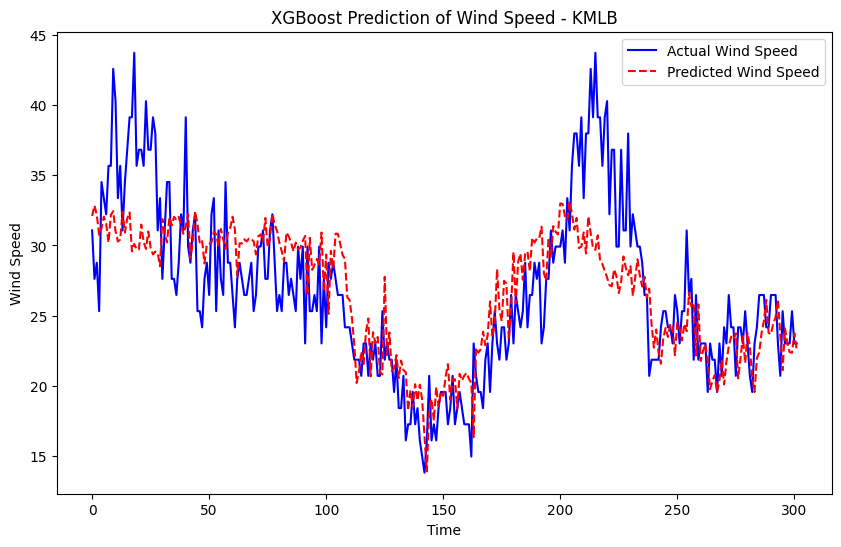

In [31]:
#XGBoost Results with Gridsearch finetuning
# Initialize the XGBRegressor with specified parameters
xgb = XGBRegressor(n_estimators=100, learning_rate=0.05, max_depth=5,
                   min_child_weight=3, subsample=0.7, random_state=42)

# Train the model on the training set
xgb.fit(X_train, y_train)

# Make predictions on the training and test sets
y_pred_train = xgb.predict(X_train)
y_pred_test = xgb.predict(X_test)

# Calculate RMSE for both train and test sets
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

# Print out the RMSE values
print(f'Train RMSE: {train_rmse:.2f}')
print(f'Test RMSE: {test_rmse:.2f}')
print("Cross-validated RMSE:", -scores.mean())

# Optionally, plot the results
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual Wind Speed', color='blue')  # Actual values
plt.plot(y_pred_test, label='Predicted Wind Speed', color='red', linestyle='dashed')  # Predicted values
plt.legend()
plt.title('XGBoost Prediction of Wind Speed - KMLB')
plt.xlabel('Time')
plt.ylabel('Wind Speed')
plt.show()


[I 2024-12-05 05:17:10,660] A new study created in memory with name: no-name-eeb396b2-cea8-4de6-ae13-88998b8400a3
[I 2024-12-05 05:17:11,366] Trial 0 finished with value: 3.2711712503636194 and parameters: {'n_estimators': 72, 'learning_rate': 0.16251794486207263, 'max_depth': 13, 'min_child_weight': 6, 'subsample': 0.8785874016220077}. Best is trial 0 with value: 3.2711712503636194.
[I 2024-12-05 05:17:12,769] Trial 1 finished with value: 3.327315476866302 and parameters: {'n_estimators': 333, 'learning_rate': 0.11541493085734846, 'max_depth': 8, 'min_child_weight': 7, 'subsample': 0.8044965427874199}. Best is trial 0 with value: 3.2711712503636194.
[I 2024-12-05 05:17:16,424] Trial 2 finished with value: 3.6044449111625694 and parameters: {'n_estimators': 319, 'learning_rate': 0.016964372828391607, 'max_depth': 14, 'min_child_weight': 1, 'subsample': 0.6514811583869342}. Best is trial 0 with value: 3.2711712503636194.
[I 2024-12-05 05:17:16,962] Trial 3 finished with value: 3.0320078

Train RMSE: 1.83
Test RMSE: 3.61
Cross-validated RMSE: 2.950203479971121


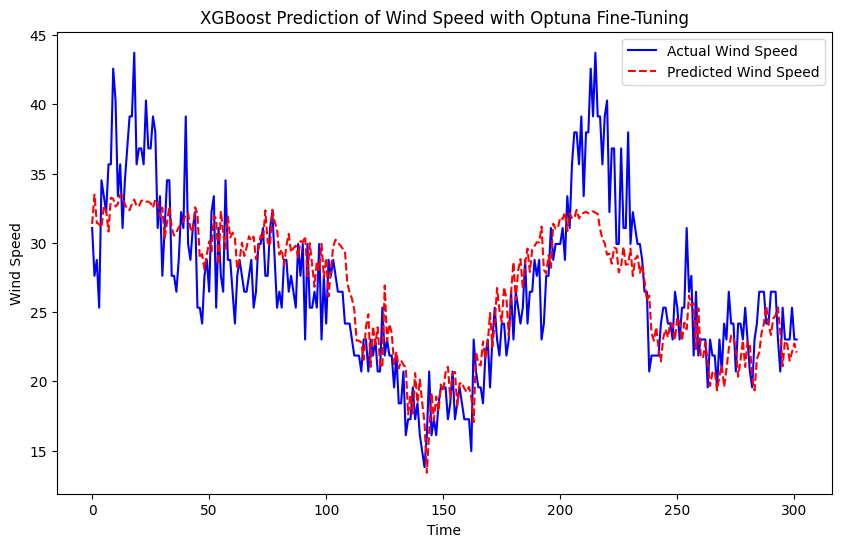

In [32]:
#Optuna based XGBoost

# Optuna objective function
def objective(trial):
    # Define the hyperparameter search space
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'random_state': 42
    }

    # Initialize and train the model
    xgb = XGBRegressor(**params)
    scores = cross_val_score(xgb, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')

    # Return the mean negative RMSE (Optuna minimizes the objective function)
    return -scores.mean()

# Optimize the hyperparameters
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Train the final model with the best parameters
best_params = study.best_params
xgb_optimized = XGBRegressor(**best_params)
xgb_optimized.fit(X_train, y_train)

# Predictions
y_pred_train = xgb_optimized.predict(X_train)
y_pred_test = xgb_optimized.predict(X_test)

# RMSE Calculation
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

# Results
print(f'Train RMSE: {train_rmse:.2f}')
print(f'Test RMSE: {test_rmse:.2f}')
print("Cross-validated RMSE:", -scores.mean())

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual Wind Speed', color='blue')
plt.plot(y_pred_test, label='Predicted Wind Speed', color='red', linestyle='dashed')
plt.legend()
plt.title('XGBoost Prediction of Wind Speed with Optuna Fine-Tuning')
plt.xlabel('Time')
plt.ylabel('Wind Speed')
plt.show()

In [33]:
print(best_params)

{'n_estimators': 209, 'learning_rate': 0.03523871134309237, 'max_depth': 3, 'min_child_weight': 10, 'subsample': 0.5677149671195134}


Train RMSE: 2.30
Test RMSE: 5.26


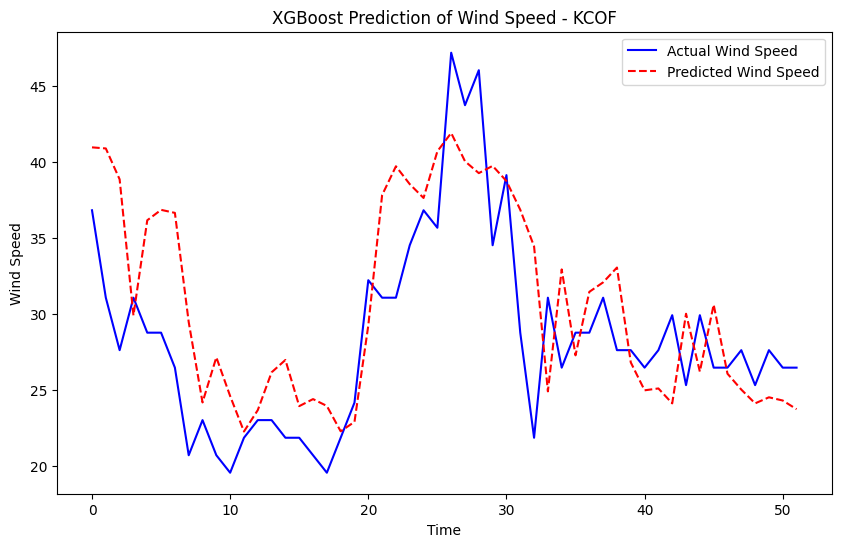

In [34]:
# Prepare the KMLB dataset with lagged features
lagged_kcof = create_lagged_features(KCOF[['Temperature', 'Relative_Humidity', 'Wind_Speed', 'Pressure']], lag=4)

# Prepare the feature matrix (X) and target vector (y)
X = lagged_kcof.drop(columns='Wind_Speed')  # Use all columns except for 'Wind_Speed' as features
y = lagged_kcof['Wind_Speed']  # Target is the 'Wind_Speed' column

# Split the data into training and test sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

# Initialize the XGBRegressor with specified parameters
xgb = XGBRegressor(n_estimators=209, learning_rate=0.03523871134309237, max_depth=3,
                   min_child_weight=10, subsample= 0.5677149671195134, random_state=42)

# Train the model on the training set
xgb.fit(X_train, y_train)

# Make predictions on the training and test sets
y_pred_train = xgb.predict(X_train)
y_pred_test = xgb.predict(X_test)

# Calculate RMSE for both train and test sets
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

# Print out the RMSE values
print(f'Train RMSE: {train_rmse:.2f}')
print(f'Test RMSE: {test_rmse:.2f}')

# Optionally, plot the results
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual Wind Speed', color='blue')  # Actual values
plt.plot(y_pred_test, label='Predicted Wind Speed', color='red', linestyle='dashed')  # Predicted values
plt.legend()
plt.title('XGBoost Prediction of Wind Speed - KCOF')
plt.xlabel('Time')
plt.ylabel('Wind Speed')
plt.show()



Train RMSE: 2.13
Test RMSE: 6.75


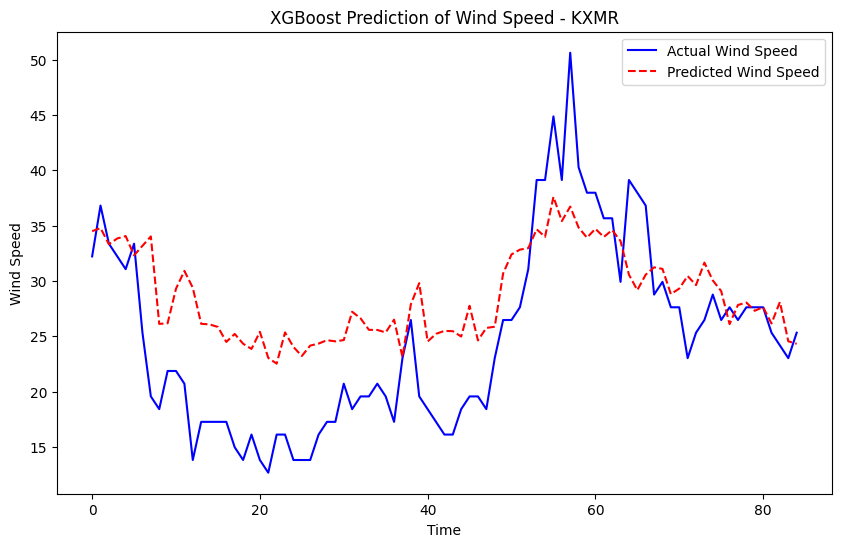

In [35]:
# Prepare the KMLB dataset with lagged features
lagged_kxmr = create_lagged_features(KXMR[['Temperature', 'Relative_Humidity', 'Wind_Speed', 'Pressure']], lag=4)

# Prepare the feature matrix (X) and target vector (y)
X = lagged_kxmr.drop(columns='Wind_Speed')  # Use all columns except for 'Wind_Speed' as features
y = lagged_kxmr['Wind_Speed']  # Target is the 'Wind_Speed' column

# Split the data into training and test sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

# Initialize the XGBRegressor with specified parameters
xgb = XGBRegressor(n_estimators=209, learning_rate=0.03523871134309237, max_depth=3,
                   min_child_weight=10, subsample= 0.5677149671195134, random_state=42)

# Train the model on the training set
xgb.fit(X_train, y_train)

# Make predictions on the training and test sets
y_pred_train = xgb.predict(X_train)
y_pred_test = xgb.predict(X_test)

# Calculate RMSE for both train and test sets
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

# Print out the RMSE values
print(f'Train RMSE: {train_rmse:.2f}')
print(f'Test RMSE: {test_rmse:.2f}')

# Optionally, plot the results
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual Wind Speed', color='blue')  # Actual values
plt.plot(y_pred_test, label='Predicted Wind Speed', color='red', linestyle='dashed')  # Predicted values
plt.legend()
plt.title('XGBoost Prediction of Wind Speed - KXMR')
plt.xlabel('Time')
plt.ylabel('Wind Speed')
plt.show()

Train RMSE: 2.28
Test RMSE: 2.59
Cross-validated RMSE: 3.1005562947783263


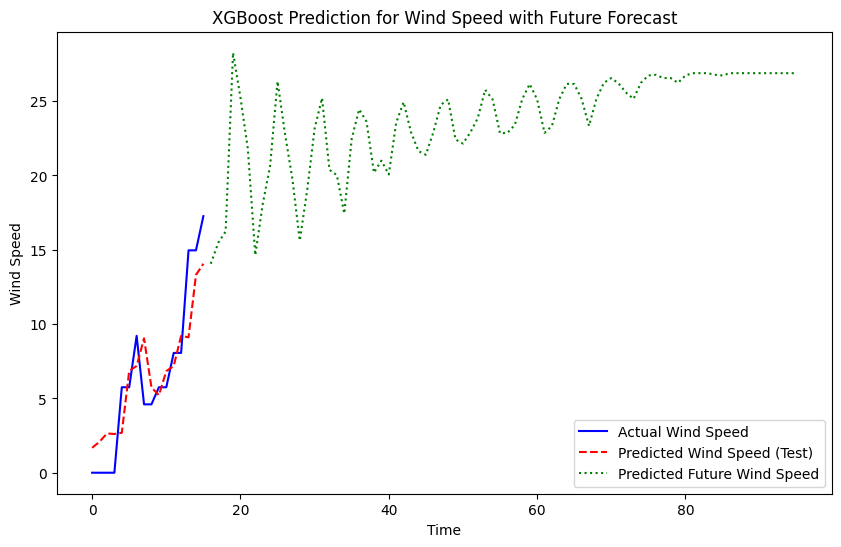

Mean Wind Speed for KTIX:  23.829493


In [37]:
#Predicting KTIX

# Prepare the training datasets
lagged_kmlb = create_lagged_features(KMLB[['Temperature', 'Relative_Humidity', 'Wind_Speed', 'Pressure']], lag=3)
lagged_kcof = create_lagged_features(KCOF[['Temperature', 'Relative_Humidity', 'Wind_Speed', 'Pressure']], lag=3)
#lagged_kxmr = create_lagged_features(KXMR[['Temperature', 'Relative_Humidity', 'Wind_Speed', 'Pressure']], lag=3)

# Combine the training datasets
training_data = pd.concat([lagged_kmlb, lagged_kcof])

# Define training features and target
X_train = training_data.drop(columns=['Wind_Speed'])  # Features
y_train = training_data['Wind_Speed']  # Target

# Prepare the test dataset (KTIX)
lagged_ktix = create_lagged_features(KTIX[['Temperature', 'Relative_Humidity', 'Wind_Speed', 'Pressure']], lag=3)
X_test = lagged_ktix.drop(columns=['Wind_Speed'])  # Features
y_test = lagged_ktix['Wind_Speed']  # Target

# Initialize and train the XGBoost model
xgb = XGBRegressor(n_estimators=209, learning_rate=0.03523871134309237, max_depth=3,
                   min_child_weight=10, subsample= 0.5677149671195134, random_state=42)

xgb.fit(X_train, y_train)

# Make predictions on the training and test sets
y_pred_train = xgb.predict(X_train)
y_pred_test = xgb.predict(X_test)

# Calculate RMSE for both train and test sets
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f'Train RMSE: {train_rmse:.2f}')
print(f'Test RMSE: {test_rmse:.2f}')

# Cross-validated RMSE
scores = cross_val_score(xgb, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
print("Cross-validated RMSE:", -scores.mean())

# Predict future wind speeds
future_steps = 80

# Prepare initial input for prediction (last row of the test dataset)
last_lagged_data = X_test.iloc[-1, :].values.reshape(1, -1)

# Convert to a DataFrame with valid feature names
last_lagged_df = pd.DataFrame(last_lagged_data, columns=X_test.columns)

# Initialize a list to store predictions
future_predictions = []

# Iterative prediction
for _ in range(future_steps):
    # Predict the next time step
    next_prediction = xgb.predict(last_lagged_df)[0]
    future_predictions.append(next_prediction)

    # Update input for the next prediction
    # Shift the lagged features and insert the new prediction
    new_input = np.roll(last_lagged_df.values, shift=-1, axis=1)
    new_input[0, -1] = next_prediction  # Replace the last feature with the new prediction

    # Update the DataFrame with valid feature names
    last_lagged_df = pd.DataFrame(new_input, columns=X_test.columns)

# Create a time axis for plotting future predictions
future_time_axis = np.arange(len(y_test), len(y_test) + future_steps)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual Wind Speed', color='blue')
plt.plot(np.arange(len(y_test)), y_pred_test, label='Predicted Wind Speed (Test)', color='red', linestyle='dashed')
plt.plot(future_time_axis, future_predictions, label='Predicted Future Wind Speed', color='green', linestyle='dotted')
plt.legend()
plt.title('XGBoost Prediction for Wind Speed with Future Forecast')
plt.xlabel('Time')
plt.ylabel('Wind Speed')
plt.show()

# Print the mean predicted wind speed for the future
print('Mean Wind Speed for KTIX: ', statistics.mean(future_predictions))

[I 2024-12-05 06:58:17,622] A new study created in memory with name: no-name-01b2afc3-075f-4258-8309-a24fd1789f1d
[I 2024-12-05 06:58:24,058] Trial 0 finished with value: 3.6647198765592655 and parameters: {'n_estimators': 448, 'learning_rate': 0.061377616536043234, 'max_depth': 12, 'min_child_weight': 3, 'subsample': 0.7276756176430725}. Best is trial 0 with value: 3.6647198765592655.
[I 2024-12-05 06:58:27,570] Trial 1 finished with value: 3.306433542304559 and parameters: {'n_estimators': 309, 'learning_rate': 0.013585306516734565, 'max_depth': 12, 'min_child_weight': 6, 'subsample': 0.622377148587034}. Best is trial 1 with value: 3.306433542304559.
[I 2024-12-05 06:58:28,842] Trial 2 finished with value: 3.8691903118146365 and parameters: {'n_estimators': 476, 'learning_rate': 0.12673694574139568, 'max_depth': 4, 'min_child_weight': 1, 'subsample': 0.7494367766354288}. Best is trial 1 with value: 3.306433542304559.
[I 2024-12-05 06:58:29,451] Trial 3 finished with value: 3.71927317

Best Parameters: {'n_estimators': 319, 'learning_rate': 0.01951518485402088, 'max_depth': 3, 'min_child_weight': 9, 'subsample': 0.8577648309294769}
Train RMSE: 2.34
Test RMSE: 2.69


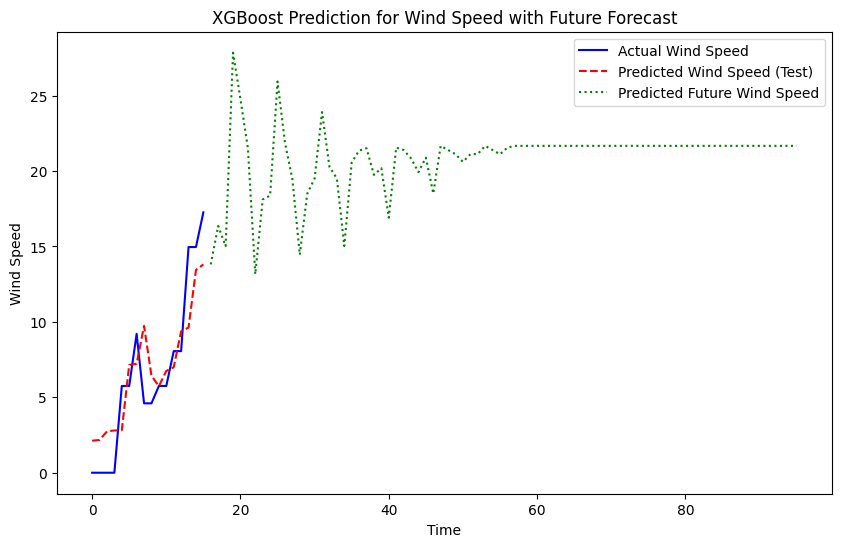

Mean Wind Speed for KTIX: 20.855923


In [24]:
#Optuna Based KTIX prediction + XGBoost

# Function to create lagged features
def create_lagged_features(df, lag=3):
    df_lagged = df.copy()
    for col in df.columns:
        for l in range(1, lag + 1):
            df_lagged[f'{col}_lag_{l}'] = df[col].shift(l)
    return df_lagged.dropna()

# Prepare the training datasets
lagged_kmlb = create_lagged_features(KMLB[['Temperature', 'Relative_Humidity', 'Wind_Speed', 'Pressure']], lag=3)
lagged_kcof = create_lagged_features(KCOF[['Temperature', 'Relative_Humidity', 'Wind_Speed', 'Pressure']], lag=3)

# Combine the training datasets
training_data = pd.concat([lagged_kmlb, lagged_kcof])

# Define training features and target
X_train = training_data.drop(columns=['Wind_Speed'])  # Features
y_train = training_data['Wind_Speed']  # Target

# Prepare the test dataset (KTIX)
lagged_ktix = create_lagged_features(KTIX[['Temperature', 'Relative_Humidity', 'Wind_Speed', 'Pressure']], lag=3)
X_test = lagged_ktix.drop(columns=['Wind_Speed'])  # Features
y_test = lagged_ktix['Wind_Speed']  # Target

# Optuna objective function
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'random_state': 42,
    }

    xgb = XGBRegressor(**params)
    scores = cross_val_score(xgb, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
    return -scores.mean()

# Optimize hyperparameters with Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Best parameters
best_params = study.best_params
print("Best Parameters:", best_params)

# Train the final model with the best parameters
xgb_optimized = XGBRegressor(**best_params)
xgb_optimized.fit(X_train, y_train)

# Make predictions
y_pred_train = xgb_optimized.predict(X_train)
y_pred_test = xgb_optimized.predict(X_test)

# Calculate RMSE
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(f'Train RMSE: {train_rmse:.2f}')
print(f'Test RMSE: {test_rmse:.2f}')

# Predict future wind speeds
future_steps = 80
last_lagged_data = X_test.iloc[-1, :].values.reshape(1, -1)
last_lagged_df = pd.DataFrame(last_lagged_data, columns=X_test.columns)
future_predictions = []

for _ in range(future_steps):
    next_prediction = xgb_optimized.predict(last_lagged_df)[0]
    future_predictions.append(next_prediction)
    new_input = np.roll(last_lagged_df.values, shift=-1, axis=1)
    new_input[0, -1] = next_prediction
    last_lagged_df = pd.DataFrame(new_input, columns=X_test.columns)

# Plot predictions
future_time_axis = np.arange(len(y_test), len(y_test) + future_steps)

plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual Wind Speed', color='blue')
plt.plot(np.arange(len(y_test)), y_pred_test, label='Predicted Wind Speed (Test)', color='red', linestyle='dashed')
plt.plot(future_time_axis, future_predictions, label='Predicted Future Wind Speed', color='green', linestyle='dotted')
plt.legend()
plt.title('XGBoost Prediction for Wind Speed with Future Forecast')
plt.xlabel('Time')
plt.ylabel('Wind Speed')
plt.show()

# Mean predicted wind speed for the future
print('Mean Wind Speed for KTIX:', statistics.mean(future_predictions))

In [29]:
# Cross-validated RMSE
scores = cross_val_score(xgb_optimized, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
print("Cross-validated RMSE:", -scores.mean())
print("Cross-validated RMSE:", -scores.mean())
print(max(future_predictions))
print(statistics.mean(future_predictions))

Cross-validated RMSE: 3.04385348097843
Cross-validated RMSE: 3.04385348097843
27.840242
20.855923


# TabNET

In [13]:
#Optuna Based TabNET Prediction

# features and target
features = ['Temperature', 'Relative_Humidity', 'Wind_Direction', 'Pressure']
target = 'Wind_Speed'
train_data = pd.concat([KMLB, KCOF])
X_train = train_data[features].values.astype(np.float32)
y_train = train_data[target].values.astype(np.float32).reshape(-1, 1)

# Prepare test data (KTIX)
X_test = KTIX[features].values.astype(np.float32)
y_test = KTIX[target].values.astype(np.float32).reshape(-1, 1)

# Define the Optuna objective function
def objective(trial):
    # Define hyperparameters
    params = {
        'n_d': trial.suggest_int('n_d', 8, 64, step=8),
        'n_a': trial.suggest_int('n_a', 8, 64, step=8),
        'n_steps': trial.suggest_int('n_steps', 3, 10),
        'gamma': trial.suggest_float('gamma', 1.0, 2.0),
        'lambda_sparse': trial.suggest_float('lambda_sparse', 0.0001, 0.01, log=True),
        'n_shared': trial.suggest_int('n_shared', 1, 5),
        'n_independent': trial.suggest_int('n_independent', 1, 5)
    }

    # Initialize TabNet with trial hyperparameters
    tabnet = TabNetRegressor(**params)
    tabnet.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        max_epochs=100,
        patience=10,
        batch_size=256,
        virtual_batch_size=128,
        num_workers=0,
        drop_last=False
    )

    # Predict and calculate RMSE
    y_pred = tabnet.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    return rmse

# Perform hyperparameter optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Train the final model with the best parameters
best_params = study.best_params
tabnet = TabNetRegressor(**best_params)
tabnet.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    max_epochs=100,
    patience=10,
    batch_size=256,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)

# Predictions
y_pred_test = tabnet.predict(X_test).squeeze()


[I 2024-12-05 06:10:01,667] A new study created in memory with name: no-name-85175ed1-d31a-4789-8e38-85a270ab8200
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 198.77437| val_0_mse: 157417776.0|  0:00:03s
epoch 1  | loss: 46.41231| val_0_mse: 9230586.0|  0:00:08s
epoch 2  | loss: 36.32633| val_0_mse: 3854053.0|  0:00:10s
epoch 3  | loss: 38.2759 | val_0_mse: 1810710.25|  0:00:12s
epoch 4  | loss: 35.76136| val_0_mse: 159819.296875|  0:00:13s
epoch 5  | loss: 27.51964| val_0_mse: 81954.0078125|  0:00:14s
epoch 6  | loss: 25.55125| val_0_mse: 132944.796875|  0:00:14s
epoch 7  | loss: 23.17702| val_0_mse: 35413.4453125|  0:00:15s
epoch 8  | loss: 25.18751| val_0_mse: 59605.31640625|  0:00:16s
epoch 9  | loss: 18.93258| val_0_mse: 38471.5625|  0:00:17s
epoch 10 | loss: 22.74834| val_0_mse: 34953.28515625|  0:00:18s
epoch 11 | loss: 19.81156| val_0_mse: 42594.16796875|  0:00:19s
epoch 12 | loss: 18.85384| val_0_mse: 39441.99609375|  0:00:20s
epoch 13 | loss: 16.82756| val_0_mse: 48850.12109375|  0:00:21s
epoch 14 | loss: 16.24002| val_0_mse: 16022.3154296875|  0:00:22s
epoch 15 | loss: 16.8274 | val_0_mse: 8034.58154296875|  0:00:

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-12-05 06:10:56,034] Trial 0 finished with value: 18.69209861755371 and parameters: {'n_d': 32, 'n_a': 24, 'n_steps': 10, 'gamma': 1.2431795522304068, 'lambda_sparse': 0.00027910055856864593, 'n_shared': 3, 'n_independent': 5}. Best is trial 0 with value: 18.69209861755371.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 395.54878| val_0_mse: 4610380.0|  0:00:00s
epoch 1  | loss: 96.93594| val_0_mse: 1578781.75|  0:00:01s
epoch 2  | loss: 35.73145| val_0_mse: 1282099.75|  0:00:02s
epoch 3  | loss: 24.96172| val_0_mse: 149989.125|  0:00:03s
epoch 4  | loss: 20.80857| val_0_mse: 77535.359375|  0:00:03s
epoch 5  | loss: 19.76681| val_0_mse: 41150.94140625|  0:00:04s
epoch 6  | loss: 22.20008| val_0_mse: 7854.796875|  0:00:04s
epoch 7  | loss: 18.98256| val_0_mse: 5423.93603515625|  0:00:05s
epoch 8  | loss: 17.75647| val_0_mse: 11038.1953125|  0:00:05s
epoch 9  | loss: 17.4369 | val_0_mse: 11634.162109375|  0:00:06s
epoch 10 | loss: 17.80959| val_0_mse: 26813.822265625|  0:00:06s
epoch 11 | loss: 15.60434| val_0_mse: 14840.0546875|  0:00:07s
epoch 12 | loss: 15.39994| val_0_mse: 34070.73828125|  0:00:07s
epoch 13 | loss: 15.49812| val_0_mse: 12017.984375|  0:00:08s
epoch 14 | loss: 14.03085| val_0_mse: 877.82568359375|  0:00:09s
epoch 15 | loss: 14.43369| val_0_mse: 2023.898193359375|  0:

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-12-05 06:11:14,485] Trial 1 finished with value: 15.581050872802734 and parameters: {'n_d': 16, 'n_a': 24, 'n_steps': 8, 'gamma': 1.0162916059488554, 'lambda_sparse': 0.0002754364822995964, 'n_shared': 5, 'n_independent': 2}. Best is trial 1 with value: 15.581050872802734.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 189.74654| val_0_mse: 5783887.5|  0:00:00s
epoch 1  | loss: 54.05575| val_0_mse: 388897.4375|  0:00:00s
epoch 2  | loss: 40.33379| val_0_mse: 37732.01953125|  0:00:00s
epoch 3  | loss: 25.56589| val_0_mse: 59944.79296875|  0:00:01s
epoch 4  | loss: 28.19954| val_0_mse: 74088.2734375|  0:00:01s
epoch 5  | loss: 28.06558| val_0_mse: 53755.8515625|  0:00:01s
epoch 6  | loss: 24.77406| val_0_mse: 16133.533203125|  0:00:02s
epoch 7  | loss: 21.94565| val_0_mse: 17566.115234375|  0:00:02s
epoch 8  | loss: 19.55464| val_0_mse: 3413.70166015625|  0:00:02s
epoch 9  | loss: 24.06551| val_0_mse: 2869.513671875|  0:00:02s
epoch 10 | loss: 18.68528| val_0_mse: 2042.8759765625|  0:00:03s
epoch 11 | loss: 19.06898| val_0_mse: 1876.1275634765625|  0:00:03s
epoch 12 | loss: 17.631  | val_0_mse: 1740.8782958984375|  0:00:03s
epoch 13 | loss: 18.98581| val_0_mse: 2781.955078125|  0:00:04s
epoch 14 | loss: 18.31919| val_0_mse: 4151.1875|  0:00:04s
epoch 15 | loss: 16.64017| val_0_mse: 812

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-12-05 06:11:24,041] Trial 2 finished with value: 14.931920051574707 and parameters: {'n_d': 64, 'n_a': 32, 'n_steps': 4, 'gamma': 1.6538086694415595, 'lambda_sparse': 0.0004265537081577549, 'n_shared': 1, 'n_independent': 3}. Best is trial 2 with value: 14.931920051574707.


epoch 30 | loss: 15.29248| val_0_mse: 351.03582763671875|  0:00:09s

Early stopping occurred at epoch 30 with best_epoch = 20 and best_val_0_mse = 222.9622344970703


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 297.01258| val_0_mse: 18655622.0|  0:00:00s
epoch 1  | loss: 119.19518| val_0_mse: 6317879.0|  0:00:01s
epoch 2  | loss: 60.72875| val_0_mse: 2461153.5|  0:00:02s
epoch 3  | loss: 49.94261| val_0_mse: 1235214.0|  0:00:03s
epoch 4  | loss: 45.08087| val_0_mse: 188088.15625|  0:00:04s
epoch 5  | loss: 38.12404| val_0_mse: 59027.51171875|  0:00:05s
epoch 6  | loss: 41.16014| val_0_mse: 61109.46484375|  0:00:05s
epoch 7  | loss: 34.1674 | val_0_mse: 13450.455078125|  0:00:06s
epoch 8  | loss: 33.25834| val_0_mse: 20203.353515625|  0:00:06s
epoch 9  | loss: 37.95726| val_0_mse: 38616.01171875|  0:00:07s
epoch 10 | loss: 37.85432| val_0_mse: 9114.1669921875|  0:00:08s
epoch 11 | loss: 37.09794| val_0_mse: 24136.640625|  0:00:08s
epoch 12 | loss: 32.94734| val_0_mse: 26558.61328125|  0:00:09s
epoch 13 | loss: 34.92374| val_0_mse: 36737.25|  0:00:09s
epoch 14 | loss: 34.80004| val_0_mse: 20524.751953125|  0:00:10s
epoch 15 | loss: 40.58015| val_0_mse: 10970.8046875|  0:00:11s


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-12-05 06:11:48,981] Trial 3 finished with value: 7.201554298400879 and parameters: {'n_d': 8, 'n_a': 40, 'n_steps': 8, 'gamma': 1.7087484618151352, 'lambda_sparse': 0.006544817864864055, 'n_shared': 4, 'n_independent': 4}. Best is trial 3 with value: 7.201554298400879.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 291.14962| val_0_mse: 1112159872.0|  0:00:00s
epoch 1  | loss: 74.83947| val_0_mse: 110653848.0|  0:00:01s
epoch 2  | loss: 48.50154| val_0_mse: 9978784.0|  0:00:01s
epoch 3  | loss: 31.53871| val_0_mse: 333224.59375|  0:00:02s
epoch 4  | loss: 27.76064| val_0_mse: 143711.296875|  0:00:03s
epoch 5  | loss: 26.57763| val_0_mse: 61382.96484375|  0:00:03s
epoch 6  | loss: 23.84836| val_0_mse: 179.42605590820312|  0:00:04s
epoch 7  | loss: 21.01554| val_0_mse: 28151.19140625|  0:00:05s
epoch 8  | loss: 15.86349| val_0_mse: 8552.642578125|  0:00:05s
epoch 9  | loss: 20.50344| val_0_mse: 3517.657958984375|  0:00:06s
epoch 10 | loss: 20.93221| val_0_mse: 7801.3828125|  0:00:07s
epoch 11 | loss: 18.94173| val_0_mse: 578.8326416015625|  0:00:08s
epoch 12 | loss: 18.26067| val_0_mse: 2823.584228515625|  0:00:09s
epoch 13 | loss: 19.98702| val_0_mse: 2474.865234375|  0:00:09s
epoch 14 | loss: 16.63886| val_0_mse: 2570.112060546875|  0:00:10s
epoch 15 | loss: 16.30979| val_0_mse: 

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-12-05 06:12:00,911] Trial 4 finished with value: 13.395001411437988 and parameters: {'n_d': 48, 'n_a': 48, 'n_steps': 5, 'gamma': 1.5893259792508219, 'lambda_sparse': 0.009926270962550622, 'n_shared': 5, 'n_independent': 3}. Best is trial 3 with value: 7.201554298400879.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 266.49104| val_0_mse: 65536976.0|  0:00:00s
epoch 1  | loss: 98.7497 | val_0_mse: 5369153.5|  0:00:01s
epoch 2  | loss: 44.99776| val_0_mse: 712848.3125|  0:00:01s
epoch 3  | loss: 37.58747| val_0_mse: 66367.828125|  0:00:02s
epoch 4  | loss: 29.73813| val_0_mse: 14605.10546875|  0:00:03s
epoch 5  | loss: 34.46501| val_0_mse: 60736.17578125|  0:00:03s
epoch 6  | loss: 28.82274| val_0_mse: 18199.291015625|  0:00:04s
epoch 7  | loss: 28.23028| val_0_mse: 22315.279296875|  0:00:04s
epoch 8  | loss: 23.90231| val_0_mse: 43515.88671875|  0:00:05s
epoch 9  | loss: 21.88054| val_0_mse: 29538.462890625|  0:00:05s
epoch 10 | loss: 20.89564| val_0_mse: 6234.2724609375|  0:00:06s
epoch 11 | loss: 18.78756| val_0_mse: 1427.646240234375|  0:00:07s
epoch 12 | loss: 18.22234| val_0_mse: 529.1941528320312|  0:00:07s
epoch 13 | loss: 18.98289| val_0_mse: 6541.646484375|  0:00:08s
epoch 14 | loss: 19.02472| val_0_mse: 1261.99365234375|  0:00:09s
epoch 15 | loss: 15.16835| val_0_mse: 344

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-12-05 06:12:18,750] Trial 5 finished with value: 9.957433700561523 and parameters: {'n_d': 8, 'n_a': 64, 'n_steps': 7, 'gamma': 1.276064005191365, 'lambda_sparse': 0.0010192452819788769, 'n_shared': 3, 'n_independent': 4}. Best is trial 3 with value: 7.201554298400879.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 446.14611| val_0_mse: 52417304.0|  0:00:00s
epoch 1  | loss: 146.80502| val_0_mse: 77342168.0|  0:00:01s
epoch 2  | loss: 67.32984| val_0_mse: 10751895.0|  0:00:01s
epoch 3  | loss: 64.57222| val_0_mse: 2559603.25|  0:00:02s
epoch 4  | loss: 42.46143| val_0_mse: 882810.3125|  0:00:03s
epoch 5  | loss: 39.48608| val_0_mse: 175053.53125|  0:00:03s
epoch 6  | loss: 51.27848| val_0_mse: 32293.947265625|  0:00:04s
epoch 7  | loss: 36.83506| val_0_mse: 7645.3427734375|  0:00:05s
epoch 8  | loss: 32.17864| val_0_mse: 7707.61669921875|  0:00:06s
epoch 9  | loss: 31.02769| val_0_mse: 4249.95166015625|  0:00:07s
epoch 10 | loss: 27.95845| val_0_mse: 3035.055908203125|  0:00:08s
epoch 11 | loss: 30.03028| val_0_mse: 2049.126953125|  0:00:09s
epoch 12 | loss: 32.50218| val_0_mse: 28804.861328125|  0:00:10s
epoch 13 | loss: 32.82632| val_0_mse: 12667.7333984375|  0:00:10s
epoch 14 | loss: 27.04514| val_0_mse: 7100.87744140625|  0:00:11s
epoch 15 | loss: 29.63415| val_0_mse: 8665.76

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-12-05 06:12:39,259] Trial 6 finished with value: 5.636877059936523 and parameters: {'n_d': 32, 'n_a': 16, 'n_steps': 7, 'gamma': 1.6048948406795014, 'lambda_sparse': 0.0011709850588323318, 'n_shared': 5, 'n_independent': 5}. Best is trial 6 with value: 5.636877059936523.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 231.97361| val_0_mse: 1416113024.0|  0:00:01s
epoch 1  | loss: 83.81891| val_0_mse: 150533344.0|  0:00:02s
epoch 2  | loss: 57.93967| val_0_mse: 30175448.0|  0:00:03s
epoch 3  | loss: 44.36132| val_0_mse: 1190210.375|  0:00:04s
epoch 4  | loss: 46.25129| val_0_mse: 1092906.75|  0:00:05s
epoch 5  | loss: 40.92945| val_0_mse: 145806.5|  0:00:06s
epoch 6  | loss: 37.85838| val_0_mse: 385956.25|  0:00:07s
epoch 7  | loss: 34.16784| val_0_mse: 113275.90625|  0:00:08s
epoch 8  | loss: 36.27088| val_0_mse: 54052.11328125|  0:00:08s
epoch 9  | loss: 44.03762| val_0_mse: 217209.453125|  0:00:09s
epoch 10 | loss: 32.46103| val_0_mse: 205291.96875|  0:00:10s
epoch 11 | loss: 30.40939| val_0_mse: 102540.9140625|  0:00:11s
epoch 12 | loss: 32.36146| val_0_mse: 2142.7392578125|  0:00:12s
epoch 13 | loss: 26.28369| val_0_mse: 84421.109375|  0:00:13s
epoch 14 | loss: 29.76785| val_0_mse: 1960.2022705078125|  0:00:13s
epoch 15 | loss: 28.41865| val_0_mse: 86919.7890625|  0:00:14s
epoch

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-12-05 06:13:03,226] Trial 7 finished with value: 44.274169921875 and parameters: {'n_d': 40, 'n_a': 24, 'n_steps': 8, 'gamma': 1.5752132390306839, 'lambda_sparse': 0.0003748786560031006, 'n_shared': 5, 'n_independent': 5}. Best is trial 6 with value: 5.636877059936523.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 302.19118| val_0_mse: 106692992.0|  0:00:00s
epoch 1  | loss: 126.62824| val_0_mse: 60235276.0|  0:00:00s
epoch 2  | loss: 60.022  | val_0_mse: 13753445.0|  0:00:00s
epoch 3  | loss: 46.35395| val_0_mse: 7766412.5|  0:00:01s
epoch 4  | loss: 41.1627 | val_0_mse: 738674.375|  0:00:01s
epoch 5  | loss: 36.99875| val_0_mse: 875649.6875|  0:00:01s
epoch 6  | loss: 28.63099| val_0_mse: 934815.9375|  0:00:02s
epoch 7  | loss: 25.93651| val_0_mse: 62055.4609375|  0:00:02s
epoch 8  | loss: 25.07711| val_0_mse: 17418.130859375|  0:00:02s
epoch 9  | loss: 20.42562| val_0_mse: 1031.5869140625|  0:00:03s
epoch 10 | loss: 17.90282| val_0_mse: 2305.317138671875|  0:00:03s
epoch 11 | loss: 18.99811| val_0_mse: 21383.55078125|  0:00:03s
epoch 12 | loss: 19.46298| val_0_mse: 28958.400390625|  0:00:04s
epoch 13 | loss: 18.12665| val_0_mse: 53190.84375|  0:00:04s
epoch 14 | loss: 17.5766 | val_0_mse: 12034.265625|  0:00:04s
epoch 15 | loss: 16.49162| val_0_mse: 13672.9833984375|  0:00:04

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-12-05 06:13:09,789] Trial 8 finished with value: 32.11832809448242 and parameters: {'n_d': 24, 'n_a': 24, 'n_steps': 3, 'gamma': 1.3178856903006078, 'lambda_sparse': 0.00018596208024938645, 'n_shared': 5, 'n_independent': 4}. Best is trial 6 with value: 5.636877059936523.


epoch 19 | loss: 21.75506| val_0_mse: 41320.72265625|  0:00:06s

Early stopping occurred at epoch 19 with best_epoch = 9 and best_val_0_mse = 1031.5869140625


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 380.80734| val_0_mse: 3157631.0|  0:00:00s
epoch 1  | loss: 65.00381| val_0_mse: 6598355.0|  0:00:00s
epoch 2  | loss: 38.7766 | val_0_mse: 1531327.625|  0:00:01s
epoch 3  | loss: 26.60456| val_0_mse: 143884.21875|  0:00:01s
epoch 4  | loss: 27.88789| val_0_mse: 43028.73046875|  0:00:02s
epoch 5  | loss: 21.62582| val_0_mse: 42184.3515625|  0:00:03s
epoch 6  | loss: 23.84957| val_0_mse: 55322.6171875|  0:00:03s
epoch 7  | loss: 22.79562| val_0_mse: 17180.107421875|  0:00:04s
epoch 8  | loss: 24.1381 | val_0_mse: 3827.880859375|  0:00:04s
epoch 9  | loss: 21.03254| val_0_mse: 19605.41796875|  0:00:04s
epoch 10 | loss: 19.69614| val_0_mse: 13759.9501953125|  0:00:05s
epoch 11 | loss: 19.28975| val_0_mse: 10468.9169921875|  0:00:05s
epoch 12 | loss: 15.94831| val_0_mse: 17651.431640625|  0:00:05s
epoch 13 | loss: 18.31277| val_0_mse: 11689.1669921875|  0:00:06s
epoch 14 | loss: 17.4934 | val_0_mse: 5260.279296875|  0:00:06s
epoch 15 | loss: 15.71198| val_0_mse: 4669.97167

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-12-05 06:13:17,930] Trial 9 finished with value: 61.869873046875 and parameters: {'n_d': 40, 'n_a': 40, 'n_steps': 5, 'gamma': 1.2846364548382785, 'lambda_sparse': 0.0013290568745703156, 'n_shared': 3, 'n_independent': 2}. Best is trial 6 with value: 5.636877059936523.


epoch 18 | loss: 16.80137| val_0_mse: 39474.01953125|  0:00:07s

Early stopping occurred at epoch 18 with best_epoch = 8 and best_val_0_mse = 3827.880859375


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 374.63757| val_0_mse: 763989.1875|  0:00:00s
epoch 1  | loss: 74.97717| val_0_mse: 182018.90625|  0:00:00s
epoch 2  | loss: 52.10205| val_0_mse: 52033.46875|  0:00:00s
epoch 3  | loss: 46.69464| val_0_mse: 7345.6552734375|  0:00:01s
epoch 4  | loss: 35.28001| val_0_mse: 31084.515625|  0:00:01s
epoch 5  | loss: 32.38516| val_0_mse: 39752.81640625|  0:00:01s
epoch 6  | loss: 34.334  | val_0_mse: 6337.083984375|  0:00:02s
epoch 7  | loss: 28.97276| val_0_mse: 11866.158203125|  0:00:02s
epoch 8  | loss: 27.35066| val_0_mse: 13346.9296875|  0:00:02s
epoch 9  | loss: 28.59877| val_0_mse: 25425.40234375|  0:00:03s
epoch 10 | loss: 24.72055| val_0_mse: 28741.80859375|  0:00:03s
epoch 11 | loss: 28.80071| val_0_mse: 57893.078125|  0:00:03s
epoch 12 | loss: 27.90335| val_0_mse: 38684.80859375|  0:00:03s
epoch 13 | loss: 36.5195 | val_0_mse: 32300.28125|  0:00:04s
epoch 14 | loss: 26.86621| val_0_mse: 32898.7109375|  0:00:04s
epoch 15 | loss: 20.15607| val_0_mse: 22133.759765625|

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-12-05 06:13:23,303] Trial 10 finished with value: 79.60580444335938 and parameters: {'n_d': 56, 'n_a': 8, 'n_steps': 10, 'gamma': 1.9932177860948876, 'lambda_sparse': 0.0029941768744540707, 'n_shared': 1, 'n_independent': 1}. Best is trial 6 with value: 5.636877059936523.


epoch 16 | loss: 26.6961 | val_0_mse: 18584.74609375|  0:00:05s

Early stopping occurred at epoch 16 with best_epoch = 6 and best_val_0_mse = 6337.083984375


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 329.32311| val_0_mse: 6161804.0|  0:00:00s
epoch 1  | loss: 211.47132| val_0_mse: 2788096.75|  0:00:00s
epoch 2  | loss: 140.42088| val_0_mse: 1629880.75|  0:00:01s
epoch 3  | loss: 78.64514| val_0_mse: 3629248.0|  0:00:02s
epoch 4  | loss: 61.47952| val_0_mse: 1368273.75|  0:00:02s
epoch 5  | loss: 49.67616| val_0_mse: 1113374.0|  0:00:03s
epoch 6  | loss: 48.46906| val_0_mse: 761218.9375|  0:00:04s
epoch 7  | loss: 49.10785| val_0_mse: 373155.5|  0:00:04s
epoch 8  | loss: 52.29564| val_0_mse: 323108.40625|  0:00:05s
epoch 9  | loss: 53.02876| val_0_mse: 143936.296875|  0:00:05s
epoch 10 | loss: 45.79014| val_0_mse: 74200.7734375|  0:00:06s
epoch 11 | loss: 39.40661| val_0_mse: 74452.921875|  0:00:06s
epoch 12 | loss: 43.55335| val_0_mse: 86216.1171875|  0:00:07s
epoch 13 | loss: 36.62261| val_0_mse: 84450.3125|  0:00:07s
epoch 14 | loss: 40.47693| val_0_mse: 32672.4375|  0:00:07s
epoch 15 | loss: 39.6727 | val_0_mse: 25229.08203125|  0:00:08s
epoch 16 | loss: 34.8003

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-12-05 06:13:48,134] Trial 11 finished with value: 36.315162658691406 and parameters: {'n_d': 8, 'n_a': 8, 'n_steps': 7, 'gamma': 1.825644630954072, 'lambda_sparse': 0.009993993698691313, 'n_shared': 4, 'n_independent': 4}. Best is trial 6 with value: 5.636877059936523.


epoch 50 | loss: 29.87119| val_0_mse: 4661.98291015625|  0:00:24s

Early stopping occurred at epoch 50 with best_epoch = 40 and best_val_0_mse = 1318.7911376953125


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 261.05635| val_0_mse: 407916224.0|  0:00:00s
epoch 1  | loss: 98.44727| val_0_mse: 169401216.0|  0:00:01s
epoch 2  | loss: 55.21419| val_0_mse: 11682538.0|  0:00:02s
epoch 3  | loss: 47.56625| val_0_mse: 623359.9375|  0:00:03s
epoch 4  | loss: 42.37442| val_0_mse: 218960.984375|  0:00:04s
epoch 5  | loss: 39.74188| val_0_mse: 216841.828125|  0:00:05s
epoch 6  | loss: 32.00647| val_0_mse: 62751.41796875|  0:00:07s
epoch 7  | loss: 29.46868| val_0_mse: 14324.9765625|  0:00:08s
epoch 8  | loss: 26.12217| val_0_mse: 46897.53125|  0:00:10s
epoch 9  | loss: 24.48586| val_0_mse: 16454.396484375|  0:00:11s
epoch 10 | loss: 25.58668| val_0_mse: 6299.03759765625|  0:00:12s
epoch 11 | loss: 23.40455| val_0_mse: 9635.5888671875|  0:00:13s
epoch 12 | loss: 26.74366| val_0_mse: 13227.16796875|  0:00:14s
epoch 13 | loss: 20.46633| val_0_mse: 6461.49755859375|  0:00:14s
epoch 14 | loss: 20.38226| val_0_mse: 7252.615234375|  0:00:15s
epoch 15 | loss: 18.1911 | val_0_mse: 23481.74414062

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-12-05 06:14:17,602] Trial 12 finished with value: 26.223060607910156 and parameters: {'n_d': 24, 'n_a': 56, 'n_steps': 9, 'gamma': 1.7656723789278186, 'lambda_sparse': 0.0034584270273171134, 'n_shared': 4, 'n_independent': 5}. Best is trial 6 with value: 5.636877059936523.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 219.64534| val_0_mse: 52054312.0|  0:00:00s
epoch 1  | loss: 65.55707| val_0_mse: 30901844.0|  0:00:01s
epoch 2  | loss: 42.23006| val_0_mse: 1192643.0|  0:00:01s
epoch 3  | loss: 40.93272| val_0_mse: 2155292.25|  0:00:02s
epoch 4  | loss: 42.87853| val_0_mse: 667997.4375|  0:00:02s
epoch 5  | loss: 35.573  | val_0_mse: 416671.5|  0:00:03s
epoch 6  | loss: 33.53649| val_0_mse: 161153.796875|  0:00:03s
epoch 7  | loss: 24.91226| val_0_mse: 56159.953125|  0:00:04s
epoch 8  | loss: 28.33984| val_0_mse: 65342.15234375|  0:00:04s
epoch 9  | loss: 22.68566| val_0_mse: 57582.46875|  0:00:05s
epoch 10 | loss: 19.34847| val_0_mse: 15789.498046875|  0:00:05s
epoch 11 | loss: 20.60629| val_0_mse: 6383.32861328125|  0:00:06s
epoch 12 | loss: 17.38229| val_0_mse: 4800.4765625|  0:00:07s
epoch 13 | loss: 18.66454| val_0_mse: 7816.16259765625|  0:00:07s
epoch 14 | loss: 19.87589| val_0_mse: 3747.58935546875|  0:00:08s
epoch 15 | loss: 16.56199| val_0_mse: 2314.37646484375|  0:00:09s


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-12-05 06:14:33,427] Trial 13 finished with value: 44.012088775634766 and parameters: {'n_d': 24, 'n_a': 40, 'n_steps': 6, 'gamma': 1.4764529420895653, 'lambda_sparse': 0.0031699471535208126, 'n_shared': 4, 'n_independent': 4}. Best is trial 6 with value: 5.636877059936523.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 538.30838| val_0_mse: 10715376.0|  0:00:00s
epoch 1  | loss: 295.89917| val_0_mse: 260507.609375|  0:00:00s
epoch 2  | loss: 165.29141| val_0_mse: 1268097.625|  0:00:01s
epoch 3  | loss: 85.23512| val_0_mse: 1549302.5|  0:00:01s
epoch 4  | loss: 56.2151 | val_0_mse: 645028.8125|  0:00:02s
epoch 5  | loss: 55.22796| val_0_mse: 231578.15625|  0:00:02s
epoch 6  | loss: 43.10508| val_0_mse: 170760.734375|  0:00:03s
epoch 7  | loss: 41.59117| val_0_mse: 33111.453125|  0:00:03s
epoch 8  | loss: 31.83707| val_0_mse: 2198.8076171875|  0:00:04s
epoch 9  | loss: 34.76041| val_0_mse: 25803.23828125|  0:00:04s
epoch 10 | loss: 41.62635| val_0_mse: 96514.0703125|  0:00:05s
epoch 11 | loss: 31.66863| val_0_mse: 141211.328125|  0:00:05s
epoch 12 | loss: 33.44098| val_0_mse: 20730.640625|  0:00:06s
epoch 13 | loss: 30.35367| val_0_mse: 16794.140625|  0:00:07s
epoch 14 | loss: 26.0578 | val_0_mse: 177430.125|  0:00:07s
epoch 15 | loss: 24.18602| val_0_mse: 1327.246337890625|  0:00:08s


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-12-05 06:14:58,699] Trial 14 finished with value: 8.408112525939941 and parameters: {'n_d': 16, 'n_a': 16, 'n_steps': 8, 'gamma': 1.7895680209983003, 'lambda_sparse': 0.0017513279207709853, 'n_shared': 2, 'n_independent': 5}. Best is trial 6 with value: 5.636877059936523.


epoch 46 | loss: 16.75206| val_0_mse: 157.2283477783203|  0:00:24s

Early stopping occurred at epoch 46 with best_epoch = 36 and best_val_0_mse = 70.69635009765625


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 208.49414| val_0_mse: 567283520.0|  0:00:00s
epoch 1  | loss: 55.2498 | val_0_mse: 17056834.0|  0:00:01s
epoch 2  | loss: 36.24703| val_0_mse: 941834.3125|  0:00:01s
epoch 3  | loss: 30.24191| val_0_mse: 803881.6875|  0:00:02s
epoch 4  | loss: 26.38917| val_0_mse: 462471.9375|  0:00:02s
epoch 5  | loss: 27.67262| val_0_mse: 75256.9765625|  0:00:03s
epoch 6  | loss: 24.96996| val_0_mse: 51696.8359375|  0:00:04s
epoch 7  | loss: 24.5469 | val_0_mse: 38903.13671875|  0:00:04s
epoch 8  | loss: 22.63583| val_0_mse: 10581.9462890625|  0:00:05s
epoch 9  | loss: 20.79984| val_0_mse: 2536.166748046875|  0:00:05s
epoch 10 | loss: 21.77757| val_0_mse: 5493.7880859375|  0:00:06s
epoch 11 | loss: 17.23697| val_0_mse: 41846.9453125|  0:00:06s
epoch 12 | loss: 19.92326| val_0_mse: 10296.2001953125|  0:00:07s
epoch 13 | loss: 20.88277| val_0_mse: 11326.1123046875|  0:00:08s
epoch 14 | loss: 20.00484| val_0_mse: 1572.5457763671875|  0:00:08s
epoch 15 | loss: 23.19983| val_0_mse: 587.42

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-12-05 06:15:15,517] Trial 15 finished with value: 24.236846923828125 and parameters: {'n_d': 32, 'n_a': 48, 'n_steps': 6, 'gamma': 1.4412984981261665, 'lambda_sparse': 0.00011308420369254803, 'n_shared': 4, 'n_independent': 4}. Best is trial 6 with value: 5.636877059936523.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 222.66393| val_0_mse: 285706304.0|  0:00:00s
epoch 1  | loss: 59.87208| val_0_mse: 51344332.0|  0:00:01s
epoch 2  | loss: 56.27303| val_0_mse: 13642029.0|  0:00:02s
epoch 3  | loss: 48.32343| val_0_mse: 890485.25|  0:00:03s
epoch 4  | loss: 48.78316| val_0_mse: 373546.75|  0:00:04s
epoch 5  | loss: 39.67178| val_0_mse: 196940.796875|  0:00:05s
epoch 6  | loss: 42.22532| val_0_mse: 163956.609375|  0:00:06s
epoch 7  | loss: 43.357  | val_0_mse: 255054.421875|  0:00:07s
epoch 8  | loss: 39.7831 | val_0_mse: 46220.90234375|  0:00:08s
epoch 9  | loss: 34.55909| val_0_mse: 59127.40234375|  0:00:10s
epoch 10 | loss: 43.89795| val_0_mse: 32903.38671875|  0:00:11s
epoch 11 | loss: 35.70794| val_0_mse: 6989.9326171875|  0:00:12s
epoch 12 | loss: 42.30721| val_0_mse: 40528.46875|  0:00:13s
epoch 13 | loss: 29.62286| val_0_mse: 17868.216796875|  0:00:14s
epoch 14 | loss: 27.98129| val_0_mse: 5728.00634765625|  0:00:15s
epoch 15 | loss: 27.81587| val_0_mse: 8193.283203125|  0:00:16

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-12-05 06:15:45,452] Trial 16 finished with value: 24.02651596069336 and parameters: {'n_d': 48, 'n_a': 32, 'n_steps': 9, 'gamma': 1.9682346226646747, 'lambda_sparse': 0.005314129760793497, 'n_shared': 4, 'n_independent': 5}. Best is trial 6 with value: 5.636877059936523.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 308.90914| val_0_mse: 1508979.125|  0:00:00s
epoch 1  | loss: 130.80457| val_0_mse: 1188560.0|  0:00:00s
epoch 2  | loss: 56.75334| val_0_mse: 904768.125|  0:00:00s
epoch 3  | loss: 50.45875| val_0_mse: 291871.21875|  0:00:01s
epoch 4  | loss: 43.69257| val_0_mse: 80859.3515625|  0:00:01s
epoch 5  | loss: 30.83837| val_0_mse: 71690.7578125|  0:00:01s
epoch 6  | loss: 29.91695| val_0_mse: 44188.60546875|  0:00:02s
epoch 7  | loss: 28.41233| val_0_mse: 5649.2705078125|  0:00:02s
epoch 8  | loss: 28.05291| val_0_mse: 9082.962890625|  0:00:02s
epoch 9  | loss: 33.08534| val_0_mse: 35913.9140625|  0:00:03s
epoch 10 | loss: 27.08466| val_0_mse: 13575.67578125|  0:00:03s
epoch 11 | loss: 26.16498| val_0_mse: 3025.79638671875|  0:00:03s
epoch 12 | loss: 24.81354| val_0_mse: 1783.653076171875|  0:00:04s
epoch 13 | loss: 21.2272 | val_0_mse: 2559.62646484375|  0:00:04s
epoch 14 | loss: 18.99892| val_0_mse: 2769.7294921875|  0:00:04s
epoch 15 | loss: 19.17286| val_0_mse: 6635.859

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-12-05 06:15:53,278] Trial 17 finished with value: 42.23331832885742 and parameters: {'n_d': 16, 'n_a': 16, 'n_steps': 7, 'gamma': 1.665411316570283, 'lambda_sparse': 0.0006341605184127694, 'n_shared': 2, 'n_independent': 3}. Best is trial 6 with value: 5.636877059936523.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 246.64153| val_0_mse: 41839440.0|  0:00:00s
epoch 1  | loss: 86.51421| val_0_mse: 14306405.0|  0:00:01s
epoch 2  | loss: 56.93451| val_0_mse: 7109245.5|  0:00:02s
epoch 3  | loss: 44.28706| val_0_mse: 2219406.0|  0:00:03s
epoch 4  | loss: 28.73802| val_0_mse: 384646.71875|  0:00:05s
epoch 5  | loss: 34.22202| val_0_mse: 197372.21875|  0:00:06s
epoch 6  | loss: 34.0732 | val_0_mse: 67730.5625|  0:00:07s
epoch 7  | loss: 30.14932| val_0_mse: 22820.49609375|  0:00:08s
epoch 8  | loss: 43.46434| val_0_mse: 34699.84765625|  0:00:09s
epoch 9  | loss: 29.7733 | val_0_mse: 11737.6533203125|  0:00:09s
epoch 10 | loss: 29.79542| val_0_mse: 38054.34765625|  0:00:10s
epoch 11 | loss: 27.13753| val_0_mse: 8746.3564453125|  0:00:11s
epoch 12 | loss: 25.55211| val_0_mse: 440.720947265625|  0:00:12s
epoch 13 | loss: 32.83675| val_0_mse: 6716.49072265625|  0:00:12s
epoch 14 | loss: 30.8022 | val_0_mse: 8547.9501953125|  0:00:13s
epoch 15 | loss: 31.87153| val_0_mse: 10744.9091796875|  

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-12-05 06:16:19,761] Trial 18 finished with value: 18.394596099853516 and parameters: {'n_d': 8, 'n_a': 48, 'n_steps': 9, 'gamma': 1.8306416174642792, 'lambda_sparse': 0.0020961125350426324, 'n_shared': 5, 'n_independent': 3}. Best is trial 6 with value: 5.636877059936523.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 229.02413| val_0_mse: 19034182.0|  0:00:00s
epoch 1  | loss: 53.77159| val_0_mse: 33079518.0|  0:00:01s
epoch 2  | loss: 51.93753| val_0_mse: 41168420.0|  0:00:02s
epoch 3  | loss: 38.32568| val_0_mse: 567110.5625|  0:00:02s
epoch 4  | loss: 35.15551| val_0_mse: 20970.109375|  0:00:03s
epoch 5  | loss: 43.56701| val_0_mse: 474634.59375|  0:00:04s
epoch 6  | loss: 32.72872| val_0_mse: 259756.40625|  0:00:05s
epoch 7  | loss: 28.81685| val_0_mse: 18176.66796875|  0:00:06s
epoch 8  | loss: 28.37633| val_0_mse: 28301.052734375|  0:00:07s
epoch 9  | loss: 21.51233| val_0_mse: 30595.982421875|  0:00:08s
epoch 10 | loss: 22.68707| val_0_mse: 34947.45703125|  0:00:08s
epoch 11 | loss: 21.78221| val_0_mse: 21452.10546875|  0:00:09s
epoch 12 | loss: 23.00217| val_0_mse: 146031.234375|  0:00:10s
epoch 13 | loss: 18.71309| val_0_mse: 66014.84375|  0:00:10s
epoch 14 | loss: 20.00089| val_0_mse: 50903.1640625|  0:00:11s
epoch 15 | loss: 20.07115| val_0_mse: 29604.875|  0:00:12s
epoc

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-12-05 06:16:42,429] Trial 19 finished with value: 33.77054214477539 and parameters: {'n_d': 64, 'n_a': 64, 'n_steps': 5, 'gamma': 1.7024323001438944, 'lambda_sparse': 0.0057238123979189955, 'n_shared': 4, 'n_independent': 4}. Best is trial 6 with value: 5.636877059936523.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 247.25084| val_0_mse: 11667774.0|  0:00:00s
epoch 1  | loss: 78.20331| val_0_mse: 1859402.75|  0:00:00s
epoch 2  | loss: 44.01882| val_0_mse: 948630.0|  0:00:01s
epoch 3  | loss: 34.83192| val_0_mse: 139039.359375|  0:00:01s
epoch 4  | loss: 33.74768| val_0_mse: 260449.15625|  0:00:01s
epoch 5  | loss: 29.22759| val_0_mse: 78723.84375|  0:00:02s
epoch 6  | loss: 33.15622| val_0_mse: 23792.796875|  0:00:02s
epoch 7  | loss: 31.19433| val_0_mse: 4436.49267578125|  0:00:02s
epoch 8  | loss: 25.28733| val_0_mse: 23326.845703125|  0:00:03s
epoch 9  | loss: 22.91911| val_0_mse: 1805.4066162109375|  0:00:03s
epoch 10 | loss: 22.12853| val_0_mse: 1258.386962890625|  0:00:03s
epoch 11 | loss: 18.54214| val_0_mse: 7090.462890625|  0:00:04s
epoch 12 | loss: 19.95659| val_0_mse: 1533.72900390625|  0:00:04s
epoch 13 | loss: 22.70112| val_0_mse: 1652.0087890625|  0:00:04s
epoch 14 | loss: 29.05991| val_0_mse: 869.0422973632812|  0:00:05s
epoch 15 | loss: 21.56718| val_0_mse: 1151.91

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-12-05 06:16:51,986] Trial 20 finished with value: 28.234363555908203 and parameters: {'n_d': 48, 'n_a': 16, 'n_steps': 6, 'gamma': 1.889486710001191, 'lambda_sparse': 0.0007897209955008949, 'n_shared': 3, 'n_independent': 2}. Best is trial 6 with value: 5.636877059936523.


epoch 26 | loss: 21.2518 | val_0_mse: 1162.5355224609375|  0:00:09s

Early stopping occurred at epoch 26 with best_epoch = 16 and best_val_0_mse = 797.1793823242188


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 532.71829| val_0_mse: 1884081.625|  0:00:00s
epoch 1  | loss: 304.15629| val_0_mse: 201462.0|  0:00:01s
epoch 2  | loss: 170.48275| val_0_mse: 548669.1875|  0:00:01s
epoch 3  | loss: 74.11201| val_0_mse: 1115594.25|  0:00:02s
epoch 4  | loss: 58.0086 | val_0_mse: 593297.25|  0:00:03s
epoch 5  | loss: 51.8413 | val_0_mse: 716702.0|  0:00:03s
epoch 6  | loss: 46.04357| val_0_mse: 438139.46875|  0:00:04s
epoch 7  | loss: 41.56308| val_0_mse: 122213.015625|  0:00:05s
epoch 8  | loss: 36.76789| val_0_mse: 140425.546875|  0:00:05s
epoch 9  | loss: 48.08202| val_0_mse: 72701.6796875|  0:00:06s
epoch 10 | loss: 43.89241| val_0_mse: 14047.970703125|  0:00:06s
epoch 11 | loss: 30.95098| val_0_mse: 11370.1953125|  0:00:06s
epoch 12 | loss: 30.6152 | val_0_mse: 7740.4853515625|  0:00:07s
epoch 13 | loss: 30.71512| val_0_mse: 8435.2265625|  0:00:07s
epoch 14 | loss: 32.06916| val_0_mse: 3638.170166015625|  0:00:08s
epoch 15 | loss: 35.2611 | val_0_mse: 5888.67529296875|  0:00:08s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-12-05 06:17:11,721] Trial 21 finished with value: 11.458121299743652 and parameters: {'n_d': 16, 'n_a': 16, 'n_steps': 8, 'gamma': 1.7575280794133041, 'lambda_sparse': 0.0019783791729583266, 'n_shared': 2, 'n_independent': 5}. Best is trial 6 with value: 5.636877059936523.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 414.41686| val_0_mse: 3550113.25|  0:00:00s
epoch 1  | loss: 236.93092| val_0_mse: 5991802.0|  0:00:00s
epoch 2  | loss: 99.25027| val_0_mse: 7822397.5|  0:00:01s
epoch 3  | loss: 60.2203 | val_0_mse: 8436669.0|  0:00:01s
epoch 4  | loss: 55.41149| val_0_mse: 3167522.0|  0:00:02s
epoch 5  | loss: 53.05246| val_0_mse: 775167.8125|  0:00:02s
epoch 6  | loss: 63.71847| val_0_mse: 765951.125|  0:00:03s
epoch 7  | loss: 50.0308 | val_0_mse: 588566.625|  0:00:03s
epoch 8  | loss: 46.02315| val_0_mse: 159840.578125|  0:00:03s
epoch 9  | loss: 46.72701| val_0_mse: 23565.052734375|  0:00:04s
epoch 10 | loss: 48.88246| val_0_mse: 13670.3671875|  0:00:04s
epoch 11 | loss: 39.88918| val_0_mse: 39699.1015625|  0:00:05s
epoch 12 | loss: 35.33543| val_0_mse: 28119.025390625|  0:00:05s
epoch 13 | loss: 37.64181| val_0_mse: 35892.078125|  0:00:06s
epoch 14 | loss: 31.45035| val_0_mse: 21936.962890625|  0:00:06s
epoch 15 | loss: 35.16613| val_0_mse: 12064.27734375|  0:00:06s
epoch 16 | 

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-12-05 06:17:31,469] Trial 22 finished with value: 8.188283920288086 and parameters: {'n_d': 16, 'n_a': 8, 'n_steps': 8, 'gamma': 1.5579865951093903, 'lambda_sparse': 0.0015741383120845577, 'n_shared': 2, 'n_independent': 5}. Best is trial 6 with value: 5.636877059936523.


epoch 41 | loss: 24.76464| val_0_mse: 135.7240753173828|  0:00:19s

Early stopping occurred at epoch 41 with best_epoch = 31 and best_val_0_mse = 67.04798889160156


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 384.6313| val_0_mse: 659752.625|  0:00:00s
epoch 1  | loss: 285.85688| val_0_mse: 135791.0625|  0:00:00s
epoch 2  | loss: 190.93281| val_0_mse: 578700.5625|  0:00:01s
epoch 3  | loss: 89.14209| val_0_mse: 480343.40625|  0:00:01s
epoch 4  | loss: 45.26071| val_0_mse: 775546.25|  0:00:01s
epoch 5  | loss: 45.58865| val_0_mse: 374766.75|  0:00:02s
epoch 6  | loss: 42.22481| val_0_mse: 162786.671875|  0:00:02s
epoch 7  | loss: 40.72348| val_0_mse: 195810.625|  0:00:02s
epoch 8  | loss: 37.40546| val_0_mse: 9712.24609375|  0:00:03s
epoch 9  | loss: 28.7725 | val_0_mse: 9252.5625|  0:00:03s
epoch 10 | loss: 29.94335| val_0_mse: 12702.41015625|  0:00:03s
epoch 11 | loss: 31.7504 | val_0_mse: 8321.3466796875|  0:00:04s
epoch 12 | loss: 30.48327| val_0_mse: 3888.94775390625|  0:00:04s
epoch 13 | loss: 34.44074| val_0_mse: 23329.712890625|  0:00:05s
epoch 14 | loss: 32.93801| val_0_mse: 4349.73583984375|  0:00:05s
epoch 15 | loss: 35.93108| val_0_mse: 890.9513549804688|  0:00:05

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-12-05 06:17:44,866] Trial 23 finished with value: 17.90095329284668 and parameters: {'n_d': 8, 'n_a': 8, 'n_steps': 7, 'gamma': 1.401628405413831, 'lambda_sparse': 0.0011615561683572329, 'n_shared': 2, 'n_independent': 5}. Best is trial 6 with value: 5.636877059936523.


epoch 32 | loss: 25.38382| val_0_mse: 10069.8505859375|  0:00:13s

Early stopping occurred at epoch 32 with best_epoch = 22 and best_val_0_mse = 320.4441223144531


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 543.22695| val_0_mse: 3064462.0|  0:00:00s
epoch 1  | loss: 120.83639| val_0_mse: 10309840.0|  0:00:01s
epoch 2  | loss: 51.9839 | val_0_mse: 749998.875|  0:00:01s
epoch 3  | loss: 50.7786 | val_0_mse: 1284451.625|  0:00:02s
epoch 4  | loss: 41.86182| val_0_mse: 725840.6875|  0:00:02s
epoch 5  | loss: 31.65216| val_0_mse: 489831.84375|  0:00:03s
epoch 6  | loss: 27.74101| val_0_mse: 287764.53125|  0:00:04s
epoch 7  | loss: 28.54846| val_0_mse: 193626.453125|  0:00:04s
epoch 8  | loss: 31.78208| val_0_mse: 163627.765625|  0:00:05s
epoch 9  | loss: 34.6522 | val_0_mse: 133575.296875|  0:00:05s
epoch 10 | loss: 28.94215| val_0_mse: 78977.171875|  0:00:06s
epoch 11 | loss: 24.41486| val_0_mse: 12013.7685546875|  0:00:07s
epoch 12 | loss: 27.78741| val_0_mse: 617.9530029296875|  0:00:08s
epoch 13 | loss: 25.84633| val_0_mse: 1986.7684326171875|  0:00:09s
epoch 14 | loss: 23.21523| val_0_mse: 1585.2301025390625|  0:00:10s
epoch 15 | loss: 22.30544| val_0_mse: 1244.1656494140

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-12-05 06:18:00,760] Trial 24 finished with value: 24.858659744262695 and parameters: {'n_d': 24, 'n_a': 32, 'n_steps': 9, 'gamma': 1.5681003824327249, 'lambda_sparse': 0.004790887913433354, 'n_shared': 3, 'n_independent': 4}. Best is trial 6 with value: 5.636877059936523.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 320.692 | val_0_mse: 21882566.0|  0:00:00s
epoch 1  | loss: 77.39352| val_0_mse: 3677783.75|  0:00:00s
epoch 2  | loss: 47.48876| val_0_mse: 1073669.625|  0:00:01s
epoch 3  | loss: 39.60608| val_0_mse: 825558.4375|  0:00:01s
epoch 4  | loss: 34.38654| val_0_mse: 202223.53125|  0:00:02s
epoch 5  | loss: 37.65771| val_0_mse: 207106.546875|  0:00:02s
epoch 6  | loss: 32.69204| val_0_mse: 152042.953125|  0:00:03s
epoch 7  | loss: 31.34447| val_0_mse: 124236.25|  0:00:03s
epoch 8  | loss: 28.87361| val_0_mse: 84227.9609375|  0:00:03s
epoch 9  | loss: 34.33006| val_0_mse: 45677.89453125|  0:00:04s
epoch 10 | loss: 29.18805| val_0_mse: 59441.07421875|  0:00:04s
epoch 11 | loss: 26.11995| val_0_mse: 40817.33203125|  0:00:05s
epoch 12 | loss: 22.35864| val_0_mse: 17549.236328125|  0:00:05s
epoch 13 | loss: 24.02497| val_0_mse: 20917.275390625|  0:00:06s
epoch 14 | loss: 21.3624 | val_0_mse: 12468.8212890625|  0:00:07s
epoch 15 | loss: 23.44529| val_0_mse: 24207.087890625|  0:00

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-12-05 06:18:26,625] Trial 25 finished with value: 16.057971954345703 and parameters: {'n_d': 32, 'n_a': 8, 'n_steps': 8, 'gamma': 1.5371923673176542, 'lambda_sparse': 0.0006652050356247462, 'n_shared': 1, 'n_independent': 5}. Best is trial 6 with value: 5.636877059936523.


epoch 51 | loss: 14.70337| val_0_mse: 992.64208984375|  0:00:25s

Early stopping occurred at epoch 51 with best_epoch = 41 and best_val_0_mse = 257.8584899902344


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 373.68524| val_0_mse: 86809304.0|  0:00:00s
epoch 1  | loss: 154.58135| val_0_mse: 29282086.0|  0:00:01s
epoch 2  | loss: 48.82467| val_0_mse: 25380636.0|  0:00:01s
epoch 3  | loss: 39.48988| val_0_mse: 391579.0|  0:00:02s
epoch 4  | loss: 51.15331| val_0_mse: 160008.578125|  0:00:02s
epoch 5  | loss: 35.55017| val_0_mse: 288927.09375|  0:00:03s
epoch 6  | loss: 33.78371| val_0_mse: 140901.953125|  0:00:04s
epoch 7  | loss: 31.13251| val_0_mse: 341789.84375|  0:00:04s
epoch 8  | loss: 34.79281| val_0_mse: 122503.3125|  0:00:05s
epoch 9  | loss: 28.2064 | val_0_mse: 189959.578125|  0:00:05s
epoch 10 | loss: 28.9603 | val_0_mse: 40483.7421875|  0:00:06s
epoch 11 | loss: 24.51703| val_0_mse: 31000.173828125|  0:00:07s
epoch 12 | loss: 22.9645 | val_0_mse: 22359.794921875|  0:00:07s
epoch 13 | loss: 20.76761| val_0_mse: 13411.48828125|  0:00:08s
epoch 14 | loss: 22.08808| val_0_mse: 3326.447021484375|  0:00:08s
epoch 15 | loss: 21.23114| val_0_mse: 1818.8626708984375|  0:0

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-12-05 06:18:48,779] Trial 26 finished with value: 15.383971214294434 and parameters: {'n_d': 16, 'n_a': 40, 'n_steps': 7, 'gamma': 1.6487725568880602, 'lambda_sparse': 0.0016594002333416799, 'n_shared': 5, 'n_independent': 4}. Best is trial 6 with value: 5.636877059936523.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 214.11075| val_0_mse: 10948950.0|  0:00:00s
epoch 1  | loss: 80.0337 | val_0_mse: 3557863.5|  0:00:00s
epoch 2  | loss: 51.06973| val_0_mse: 1610624.25|  0:00:01s
epoch 3  | loss: 45.29764| val_0_mse: 1046162.5|  0:00:01s
epoch 4  | loss: 32.03745| val_0_mse: 248653.53125|  0:00:02s
epoch 5  | loss: 32.90694| val_0_mse: 560540.8125|  0:00:03s
epoch 6  | loss: 28.07522| val_0_mse: 255308.3125|  0:00:04s
epoch 7  | loss: 29.3756 | val_0_mse: 78563.9921875|  0:00:04s
epoch 8  | loss: 24.49994| val_0_mse: 44882.796875|  0:00:05s
epoch 9  | loss: 20.97957| val_0_mse: 10485.0576171875|  0:00:06s
epoch 10 | loss: 19.97453| val_0_mse: 17879.9609375|  0:00:06s
epoch 11 | loss: 21.30774| val_0_mse: 9940.3603515625|  0:00:07s
epoch 12 | loss: 18.74857| val_0_mse: 2144.22119140625|  0:00:07s
epoch 13 | loss: 20.21126| val_0_mse: 12658.5654296875|  0:00:08s
epoch 14 | loss: 19.29411| val_0_mse: 3836.89892578125|  0:00:08s
epoch 15 | loss: 18.30458| val_0_mse: 1329.1231689453125|  0

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-12-05 06:19:07,264] Trial 27 finished with value: 24.134498596191406 and parameters: {'n_d': 8, 'n_a': 16, 'n_steps': 9, 'gamma': 1.15340636529471, 'lambda_sparse': 0.0025594356457507386, 'n_shared': 2, 'n_independent': 5}. Best is trial 6 with value: 5.636877059936523.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 189.10632| val_0_mse: 1459229952.0|  0:00:01s
epoch 1  | loss: 54.13458| val_0_mse: 113071344.0|  0:00:02s
epoch 2  | loss: 46.40607| val_0_mse: 1478801.375|  0:00:03s
epoch 3  | loss: 35.56986| val_0_mse: 413322.5|  0:00:03s
epoch 4  | loss: 34.98233| val_0_mse: 189369.125|  0:00:04s
epoch 5  | loss: 29.44112| val_0_mse: 470033.15625|  0:00:05s
epoch 6  | loss: 27.28886| val_0_mse: 474508.90625|  0:00:06s
epoch 7  | loss: 30.25927| val_0_mse: 50306.03125|  0:00:07s
epoch 8  | loss: 41.02704| val_0_mse: 57210.51171875|  0:00:07s
epoch 9  | loss: 29.69869| val_0_mse: 41623.73046875|  0:00:08s
epoch 10 | loss: 26.51197| val_0_mse: 7890.4833984375|  0:00:09s
epoch 11 | loss: 29.55611| val_0_mse: 15192.8994140625|  0:00:10s
epoch 12 | loss: 30.13877| val_0_mse: 7503.7412109375|  0:00:11s
epoch 13 | loss: 33.24739| val_0_mse: 1052.433349609375|  0:00:12s
epoch 14 | loss: 27.59858| val_0_mse: 22557.685546875|  0:00:12s
epoch 15 | loss: 27.40296| val_0_mse: 15928.134765625|  

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-12-05 06:19:35,704] Trial 28 finished with value: 23.187007904052734 and parameters: {'n_d': 24, 'n_a': 56, 'n_steps': 8, 'gamma': 1.3732507778667242, 'lambda_sparse': 0.006632594672718918, 'n_shared': 4, 'n_independent': 5}. Best is trial 6 with value: 5.636877059936523.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 377.54165| val_0_mse: 51140640.0|  0:00:01s
epoch 1  | loss: 84.82925| val_0_mse: 8633124.0|  0:00:01s
epoch 2  | loss: 49.28474| val_0_mse: 2276163.25|  0:00:03s
epoch 3  | loss: 48.62579| val_0_mse: 640072.4375|  0:00:04s
epoch 4  | loss: 39.84571| val_0_mse: 356370.46875|  0:00:04s
epoch 5  | loss: 32.0094 | val_0_mse: 126480.015625|  0:00:05s
epoch 6  | loss: 32.76397| val_0_mse: 117109.9921875|  0:00:06s
epoch 7  | loss: 34.17921| val_0_mse: 134670.453125|  0:00:06s
epoch 8  | loss: 39.58983| val_0_mse: 37171.2109375|  0:00:07s
epoch 9  | loss: 34.56077| val_0_mse: 13235.5166015625|  0:00:08s
epoch 10 | loss: 28.663  | val_0_mse: 5951.23095703125|  0:00:08s
epoch 11 | loss: 35.21905| val_0_mse: 8665.5908203125|  0:00:09s
epoch 12 | loss: 32.17269| val_0_mse: 997.5538940429688|  0:00:10s
epoch 13 | loss: 29.71703| val_0_mse: 1646.0758056640625|  0:00:10s
epoch 14 | loss: 23.87394| val_0_mse: 11400.77734375|  0:00:11s
epoch 15 | loss: 26.46377| val_0_mse: 27753.9863

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-12-05 06:20:00,602] Trial 29 finished with value: 31.00440788269043 and parameters: {'n_d': 32, 'n_a': 32, 'n_steps': 10, 'gamma': 1.7109852692650327, 'lambda_sparse': 0.0008050977891512249, 'n_shared': 3, 'n_independent': 4}. Best is trial 6 with value: 5.636877059936523.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 198.32678| val_0_mse: 1278644480.0|  0:00:00s
epoch 1  | loss: 55.36682| val_0_mse: 83157912.0|  0:00:01s
epoch 2  | loss: 50.91976| val_0_mse: 9262141.0|  0:00:01s
epoch 3  | loss: 41.95909| val_0_mse: 3964993.0|  0:00:02s
epoch 4  | loss: 43.07133| val_0_mse: 440047.75|  0:00:02s
epoch 5  | loss: 37.36989| val_0_mse: 172328.78125|  0:00:03s
epoch 6  | loss: 30.62992| val_0_mse: 400805.59375|  0:00:04s
epoch 7  | loss: 29.88328| val_0_mse: 14522.3330078125|  0:00:04s
epoch 8  | loss: 31.98931| val_0_mse: 311345.90625|  0:00:05s
epoch 9  | loss: 30.51684| val_0_mse: 177198.75|  0:00:06s
epoch 10 | loss: 28.05684| val_0_mse: 153091.796875|  0:00:07s
epoch 11 | loss: 34.75082| val_0_mse: 2932.19189453125|  0:00:08s
epoch 12 | loss: 32.49503| val_0_mse: 35273.80078125|  0:00:09s
epoch 13 | loss: 27.83721| val_0_mse: 63481.7578125|  0:00:09s
epoch 14 | loss: 24.47038| val_0_mse: 57691.07421875|  0:00:10s
epoch 15 | loss: 21.15012| val_0_mse: 11530.3076171875|  0:00:10s
epo

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-12-05 06:20:26,134] Trial 30 finished with value: 18.678241729736328 and parameters: {'n_d': 40, 'n_a': 24, 'n_steps': 6, 'gamma': 1.5085896299818389, 'lambda_sparse': 0.0005273476569621505, 'n_shared': 5, 'n_independent': 5}. Best is trial 6 with value: 5.636877059936523.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 537.92981| val_0_mse: 3449496.25|  0:00:00s
epoch 1  | loss: 311.18168| val_0_mse: 27343.6484375|  0:00:00s
epoch 2  | loss: 156.46928| val_0_mse: 977540.625|  0:00:01s
epoch 3  | loss: 65.66925| val_0_mse: 504031.0|  0:00:01s
epoch 4  | loss: 64.42925| val_0_mse: 709695.875|  0:00:02s
epoch 5  | loss: 50.69645| val_0_mse: 79481.4296875|  0:00:02s
epoch 6  | loss: 39.94421| val_0_mse: 22075.83984375|  0:00:03s
epoch 7  | loss: 33.90869| val_0_mse: 3140.69384765625|  0:00:03s
epoch 8  | loss: 25.91094| val_0_mse: 2246.97509765625|  0:00:04s
epoch 9  | loss: 29.45668| val_0_mse: 3290.653076171875|  0:00:04s
epoch 10 | loss: 28.19064| val_0_mse: 19739.009765625|  0:00:04s
epoch 11 | loss: 29.61368| val_0_mse: 17289.3671875|  0:00:05s
epoch 12 | loss: 27.54957| val_0_mse: 13649.30859375|  0:00:05s
epoch 13 | loss: 25.22426| val_0_mse: 6451.07568359375|  0:00:06s
epoch 14 | loss: 20.89363| val_0_mse: 10378.8505859375|  0:00:06s
epoch 15 | loss: 20.62205| val_0_mse: 23699.82

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-12-05 06:20:58,951] Trial 31 finished with value: 3.423285722732544 and parameters: {'n_d': 16, 'n_a': 16, 'n_steps': 8, 'gamma': 1.896971379670503, 'lambda_sparse': 0.0015611671487641555, 'n_shared': 2, 'n_independent': 5}. Best is trial 31 with value: 3.423285722732544.


epoch 65 | loss: 14.2026 | val_0_mse: 65.99475860595703|  0:00:32s

Early stopping occurred at epoch 65 with best_epoch = 55 and best_val_0_mse = 11.718879699707031


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 409.14536| val_0_mse: 2844518.0|  0:00:00s
epoch 1  | loss: 239.51176| val_0_mse: 2466066.5|  0:00:00s
epoch 2  | loss: 135.63869| val_0_mse: 2610457.0|  0:00:01s
epoch 3  | loss: 65.99995| val_0_mse: 2898665.75|  0:00:01s
epoch 4  | loss: 51.80332| val_0_mse: 1038820.9375|  0:00:02s
epoch 5  | loss: 40.81694| val_0_mse: 20649.5390625|  0:00:02s
epoch 6  | loss: 35.86048| val_0_mse: 132405.296875|  0:00:03s
epoch 7  | loss: 39.75716| val_0_mse: 84829.0234375|  0:00:03s
epoch 8  | loss: 41.85157| val_0_mse: 100360.0859375|  0:00:03s
epoch 9  | loss: 33.75094| val_0_mse: 39919.5234375|  0:00:04s
epoch 10 | loss: 37.46672| val_0_mse: 13592.490234375|  0:00:04s
epoch 11 | loss: 41.44492| val_0_mse: 20825.109375|  0:00:05s
epoch 12 | loss: 43.4985 | val_0_mse: 55041.61328125|  0:00:05s
epoch 13 | loss: 38.63372| val_0_mse: 85973.921875|  0:00:06s
epoch 14 | loss: 31.97839| val_0_mse: 194904.796875|  0:00:07s
epoch 15 | loss: 31.27912| val_0_mse: 333017.59375|  0:00:07s
epoc

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-12-05 06:21:10,025] Trial 32 finished with value: 116.58683776855469 and parameters: {'n_d': 16, 'n_a': 8, 'n_steps': 8, 'gamma': 1.903549566347835, 'lambda_sparse': 0.0013111525462792038, 'n_shared': 2, 'n_independent': 5}. Best is trial 31 with value: 3.423285722732544.


epoch 20 | loss: 26.11843| val_0_mse: 301624.375|  0:00:10s

Early stopping occurred at epoch 20 with best_epoch = 10 and best_val_0_mse = 13592.490234375


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 515.80945| val_0_mse: 331626.9375|  0:00:00s
epoch 1  | loss: 345.60113| val_0_mse: 89244.9296875|  0:00:01s
epoch 2  | loss: 238.21146| val_0_mse: 51849.28125|  0:00:01s
epoch 3  | loss: 153.51589| val_0_mse: 68686.1875|  0:00:01s
epoch 4  | loss: 87.42924| val_0_mse: 915439.5625|  0:00:02s
epoch 5  | loss: 53.11618| val_0_mse: 124839.578125|  0:00:02s
epoch 6  | loss: 41.7816 | val_0_mse: 109147.2421875|  0:00:02s
epoch 7  | loss: 36.08153| val_0_mse: 90742.1015625|  0:00:03s
epoch 8  | loss: 32.25061| val_0_mse: 147422.796875|  0:00:03s
epoch 9  | loss: 31.23597| val_0_mse: 76202.4375|  0:00:03s
epoch 10 | loss: 27.7443 | val_0_mse: 19910.669921875|  0:00:04s
epoch 11 | loss: 29.90907| val_0_mse: 12390.7841796875|  0:00:04s
epoch 12 | loss: 26.60054| val_0_mse: 12321.2802734375|  0:00:05s
epoch 13 | loss: 25.01069| val_0_mse: 7297.30419921875|  0:00:05s
epoch 14 | loss: 23.50575| val_0_mse: 6796.3291015625|  0:00:05s
epoch 15 | loss: 21.41889| val_0_mse: 4610.599121

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-12-05 06:21:20,070] Trial 33 finished with value: 67.9013900756836 and parameters: {'n_d': 8, 'n_a': 16, 'n_steps': 7, 'gamma': 1.6319637681582937, 'lambda_sparse': 0.00382327523038076, 'n_shared': 1, 'n_independent': 5}. Best is trial 31 with value: 3.423285722732544.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 342.46411| val_0_mse: 1237111.375|  0:00:00s
epoch 1  | loss: 152.05646| val_0_mse: 1859071.625|  0:00:01s
epoch 2  | loss: 74.29918| val_0_mse: 1223068.125|  0:00:01s
epoch 3  | loss: 45.32097| val_0_mse: 185724.125|  0:00:02s
epoch 4  | loss: 33.34472| val_0_mse: 22667.0703125|  0:00:03s
epoch 5  | loss: 30.95833| val_0_mse: 11741.3310546875|  0:00:03s
epoch 6  | loss: 26.97057| val_0_mse: 5762.12158203125|  0:00:04s
epoch 7  | loss: 31.63824| val_0_mse: 23358.76171875|  0:00:04s
epoch 8  | loss: 30.14482| val_0_mse: 20093.611328125|  0:00:05s
epoch 9  | loss: 23.8259 | val_0_mse: 7211.81103515625|  0:00:05s
epoch 10 | loss: 25.69767| val_0_mse: 6029.92919921875|  0:00:06s
epoch 11 | loss: 30.61911| val_0_mse: 5295.26611328125|  0:00:06s
epoch 12 | loss: 29.52686| val_0_mse: 10633.95703125|  0:00:07s
epoch 13 | loss: 24.18031| val_0_mse: 5114.46923828125|  0:00:07s
epoch 14 | loss: 23.59438| val_0_mse: 457.3116760253906|  0:00:07s
epoch 15 | loss: 25.45089| val_0_mse

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-12-05 06:21:32,739] Trial 34 finished with value: 21.38484764099121 and parameters: {'n_d': 16, 'n_a': 24, 'n_steps': 8, 'gamma': 1.7154817211957165, 'lambda_sparse': 0.0002762499477883095, 'n_shared': 3, 'n_independent': 3}. Best is trial 31 with value: 3.423285722732544.


epoch 24 | loss: 25.67476| val_0_mse: 1654.7738037109375|  0:00:12s

Early stopping occurred at epoch 24 with best_epoch = 14 and best_val_0_mse = 457.3116760253906


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 258.42395| val_0_mse: 12935459.0|  0:00:00s
epoch 1  | loss: 85.09647| val_0_mse: 3836176.75|  0:00:00s
epoch 2  | loss: 55.06064| val_0_mse: 2627614.0|  0:00:01s
epoch 3  | loss: 44.59654| val_0_mse: 261047.78125|  0:00:02s
epoch 4  | loss: 35.16453| val_0_mse: 75107.421875|  0:00:02s
epoch 5  | loss: 31.81062| val_0_mse: 22294.025390625|  0:00:03s
epoch 6  | loss: 31.25887| val_0_mse: 14182.123046875|  0:00:04s
epoch 7  | loss: 23.4406 | val_0_mse: 16338.4375|  0:00:05s
epoch 8  | loss: 23.74498| val_0_mse: 14630.8095703125|  0:00:05s
epoch 9  | loss: 27.10208| val_0_mse: 5494.8193359375|  0:00:06s
epoch 10 | loss: 26.00575| val_0_mse: 5526.3310546875|  0:00:06s
epoch 11 | loss: 24.02681| val_0_mse: 579.3968505859375|  0:00:07s
epoch 12 | loss: 21.62148| val_0_mse: 7241.8427734375|  0:00:07s
epoch 13 | loss: 19.33233| val_0_mse: 2089.046630859375|  0:00:08s
epoch 14 | loss: 18.58854| val_0_mse: 1924.620849609375|  0:00:08s
epoch 15 | loss: 20.98401| val_0_mse: 3188.5

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-12-05 06:21:45,175] Trial 35 finished with value: 24.070663452148438 and parameters: {'n_d': 16, 'n_a': 24, 'n_steps': 9, 'gamma': 1.910864342815622, 'lambda_sparse': 0.0023963269239048305, 'n_shared': 2, 'n_independent': 4}. Best is trial 31 with value: 3.423285722732544.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 148.4545| val_0_mse: 24604036.0|  0:00:00s
epoch 1  | loss: 48.24609| val_0_mse: 7737901.5|  0:00:01s
epoch 2  | loss: 38.02111| val_0_mse: 2263162.5|  0:00:01s
epoch 3  | loss: 35.54145| val_0_mse: 422410.25|  0:00:02s
epoch 4  | loss: 32.05178| val_0_mse: 208633.984375|  0:00:03s
epoch 5  | loss: 39.58488| val_0_mse: 133624.5625|  0:00:03s
epoch 6  | loss: 36.06451| val_0_mse: 176885.28125|  0:00:04s
epoch 7  | loss: 32.41655| val_0_mse: 136931.515625|  0:00:05s
epoch 8  | loss: 40.39625| val_0_mse: 33429.31640625|  0:00:06s
epoch 9  | loss: 45.57814| val_0_mse: 13915.861328125|  0:00:07s
epoch 10 | loss: 35.28676| val_0_mse: 8909.5546875|  0:00:08s
epoch 11 | loss: 28.61037| val_0_mse: 5622.552734375|  0:00:09s
epoch 12 | loss: 24.07108| val_0_mse: 4774.2099609375|  0:00:09s
epoch 13 | loss: 21.93015| val_0_mse: 6305.701171875|  0:00:10s
epoch 14 | loss: 25.70014| val_0_mse: 5988.28466796875|  0:00:11s
epoch 15 | loss: 24.45469| val_0_mse: 5459.02734375|  0:00:11s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-12-05 06:22:27,950] Trial 36 finished with value: 4.988089084625244 and parameters: {'n_d': 32, 'n_a': 32, 'n_steps': 10, 'gamma': 1.6140186714961708, 'lambda_sparse': 0.0009031247300272364, 'n_shared': 1, 'n_independent': 5}. Best is trial 31 with value: 3.423285722732544.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 163.54787| val_0_mse: 36585932.0|  0:00:00s
epoch 1  | loss: 52.11915| val_0_mse: 2694362.75|  0:00:01s
epoch 2  | loss: 45.50437| val_0_mse: 993649.875|  0:00:01s
epoch 3  | loss: 37.99963| val_0_mse: 36570.328125|  0:00:02s
epoch 4  | loss: 29.68981| val_0_mse: 285237.46875|  0:00:03s
epoch 5  | loss: 36.43139| val_0_mse: 89349.0859375|  0:00:03s
epoch 6  | loss: 30.02751| val_0_mse: 30249.365234375|  0:00:04s
epoch 7  | loss: 27.30078| val_0_mse: 21399.46875|  0:00:04s
epoch 8  | loss: 27.72044| val_0_mse: 6360.08056640625|  0:00:05s
epoch 9  | loss: 26.39272| val_0_mse: 947.8585815429688|  0:00:06s
epoch 10 | loss: 23.32805| val_0_mse: 15854.76953125|  0:00:07s
epoch 11 | loss: 26.72273| val_0_mse: 11448.45703125|  0:00:08s
epoch 12 | loss: 22.94044| val_0_mse: 2710.885986328125|  0:00:08s
epoch 13 | loss: 24.16956| val_0_mse: 1205.2386474609375|  0:00:09s
epoch 14 | loss: 22.99061| val_0_mse: 1154.381103515625|  0:00:10s
epoch 15 | loss: 21.40521| val_0_mse: 6536.

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-12-05 06:22:57,850] Trial 37 finished with value: 6.099268913269043 and parameters: {'n_d': 32, 'n_a': 32, 'n_steps': 10, 'gamma': 1.6218934366633442, 'lambda_sparse': 0.00043707659925568186, 'n_shared': 1, 'n_independent': 5}. Best is trial 31 with value: 3.423285722732544.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 248.32996| val_0_mse: 1008757.5|  0:00:00s
epoch 1  | loss: 50.99674| val_0_mse: 48061.58984375|  0:00:00s
epoch 2  | loss: 35.35388| val_0_mse: 29714.80859375|  0:00:00s
epoch 3  | loss: 29.65858| val_0_mse: 26206.56640625|  0:00:01s
epoch 4  | loss: 22.72958| val_0_mse: 21390.26953125|  0:00:01s
epoch 5  | loss: 22.13308| val_0_mse: 7451.1923828125|  0:00:01s
epoch 6  | loss: 20.33249| val_0_mse: 22465.91796875|  0:00:02s
epoch 7  | loss: 17.69903| val_0_mse: 1524.931640625|  0:00:02s
epoch 8  | loss: 17.6714 | val_0_mse: 3660.861083984375|  0:00:02s
epoch 9  | loss: 16.88147| val_0_mse: 2872.47412109375|  0:00:02s
epoch 10 | loss: 17.36425| val_0_mse: 4472.5908203125|  0:00:03s
epoch 11 | loss: 16.64135| val_0_mse: 4487.98974609375|  0:00:03s
epoch 12 | loss: 15.12126| val_0_mse: 2207.706298828125|  0:00:03s
epoch 13 | loss: 13.92475| val_0_mse: 2911.13623046875|  0:00:03s
epoch 14 | loss: 13.98366| val_0_mse: 4080.082763671875|  0:00:04s
epoch 15 | loss: 12.83829| 

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-12-05 06:23:03,127] Trial 38 finished with value: 39.05037307739258 and parameters: {'n_d': 32, 'n_a': 32, 'n_steps': 10, 'gamma': 1.1056672733614978, 'lambda_sparse': 0.0003328615928660972, 'n_shared': 1, 'n_independent': 1}. Best is trial 31 with value: 3.423285722732544.


epoch 17 | loss: 15.0163 | val_0_mse: 5424.32177734375|  0:00:05s

Early stopping occurred at epoch 17 with best_epoch = 7 and best_val_0_mse = 1524.931640625


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 164.24579| val_0_mse: 44825404.0|  0:00:00s
epoch 1  | loss: 52.50608| val_0_mse: 8341626.0|  0:00:01s
epoch 2  | loss: 39.84003| val_0_mse: 791738.75|  0:00:02s
epoch 3  | loss: 42.88511| val_0_mse: 170862.171875|  0:00:03s
epoch 4  | loss: 40.43941| val_0_mse: 2915.00244140625|  0:00:04s
epoch 5  | loss: 31.74915| val_0_mse: 10561.69921875|  0:00:05s
epoch 6  | loss: 33.20901| val_0_mse: 218293.28125|  0:00:05s
epoch 7  | loss: 26.79373| val_0_mse: 29750.10546875|  0:00:06s
epoch 8  | loss: 30.05457| val_0_mse: 4588.56640625|  0:00:07s
epoch 9  | loss: 28.34217| val_0_mse: 26811.556640625|  0:00:07s
epoch 10 | loss: 30.06408| val_0_mse: 9348.6845703125|  0:00:08s
epoch 11 | loss: 26.56696| val_0_mse: 10604.3076171875|  0:00:09s
epoch 12 | loss: 21.6861 | val_0_mse: 13148.689453125|  0:00:09s
epoch 13 | loss: 24.10296| val_0_mse: 11664.7080078125|  0:00:10s
epoch 14 | loss: 25.35372| val_0_mse: 295.7243957519531|  0:00:10s
epoch 15 | loss: 28.41637| val_0_mse: 1005.55

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-12-05 06:23:28,648] Trial 39 finished with value: 15.192011833190918 and parameters: {'n_d': 40, 'n_a': 32, 'n_steps': 10, 'gamma': 1.6090862337860938, 'lambda_sparse': 0.0004817555026269999, 'n_shared': 1, 'n_independent': 5}. Best is trial 31 with value: 3.423285722732544.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 288.34674| val_0_mse: 41620428.0|  0:00:00s
epoch 1  | loss: 50.77396| val_0_mse: 4423612.5|  0:00:01s
epoch 2  | loss: 35.18259| val_0_mse: 577763.125|  0:00:01s
epoch 3  | loss: 28.89889| val_0_mse: 47757.2265625|  0:00:02s
epoch 4  | loss: 29.48794| val_0_mse: 30072.95703125|  0:00:03s
epoch 5  | loss: 28.0272 | val_0_mse: 16726.244140625|  0:00:03s
epoch 6  | loss: 25.07316| val_0_mse: 82894.5703125|  0:00:04s
epoch 7  | loss: 22.99695| val_0_mse: 19652.873046875|  0:00:05s
epoch 8  | loss: 27.22716| val_0_mse: 21349.67578125|  0:00:06s
epoch 9  | loss: 25.76697| val_0_mse: 4591.9365234375|  0:00:07s
epoch 10 | loss: 20.26074| val_0_mse: 5448.87744140625|  0:00:08s
epoch 11 | loss: 19.3565 | val_0_mse: 8687.681640625|  0:00:09s
epoch 12 | loss: 21.8869 | val_0_mse: 6511.88916015625|  0:00:09s
epoch 13 | loss: 23.70996| val_0_mse: 5503.53466796875|  0:00:10s
epoch 14 | loss: 23.247  | val_0_mse: 4755.25390625|  0:00:11s
epoch 15 | loss: 28.29544| val_0_mse: 1692.261

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-12-05 06:23:51,179] Trial 40 finished with value: 31.762359619140625 and parameters: {'n_d': 48, 'n_a': 24, 'n_steps': 10, 'gamma': 1.4805766672435803, 'lambda_sparse': 0.0002139790341631026, 'n_shared': 1, 'n_independent': 5}. Best is trial 31 with value: 3.423285722732544.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 477.81744| val_0_mse: 18487720.0|  0:00:00s
epoch 1  | loss: 107.21978| val_0_mse: 8850402.0|  0:00:01s
epoch 2  | loss: 57.69376| val_0_mse: 98519.2734375|  0:00:02s
epoch 3  | loss: 54.76029| val_0_mse: 1626570.375|  0:00:02s
epoch 4  | loss: 37.57769| val_0_mse: 45383.4453125|  0:00:03s
epoch 5  | loss: 31.58626| val_0_mse: 55410.7890625|  0:00:04s
epoch 6  | loss: 29.60245| val_0_mse: 51458.87890625|  0:00:04s
epoch 7  | loss: 30.81773| val_0_mse: 35695.42578125|  0:00:05s
epoch 8  | loss: 27.0698 | val_0_mse: 29146.6875|  0:00:05s
epoch 9  | loss: 22.10254| val_0_mse: 25114.810546875|  0:00:06s
epoch 10 | loss: 26.40475| val_0_mse: 2819.095703125|  0:00:07s
epoch 11 | loss: 32.33579| val_0_mse: 12915.3369140625|  0:00:07s
epoch 12 | loss: 24.28005| val_0_mse: 2435.8193359375|  0:00:08s
epoch 13 | loss: 25.46213| val_0_mse: 2408.1064453125|  0:00:08s
epoch 14 | loss: 29.7465 | val_0_mse: 3096.938232421875|  0:00:09s
epoch 15 | loss: 23.70634| val_0_mse: 7294.980957

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-12-05 06:24:07,889] Trial 41 finished with value: 49.07246017456055 and parameters: {'n_d': 24, 'n_a': 40, 'n_steps': 10, 'gamma': 1.6712337291772863, 'lambda_sparse': 0.0009761010162636587, 'n_shared': 1, 'n_independent': 5}. Best is trial 31 with value: 3.423285722732544.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 251.73613| val_0_mse: 31109042.0|  0:00:00s
epoch 1  | loss: 47.82116| val_0_mse: 4390586.0|  0:00:00s
epoch 2  | loss: 27.50453| val_0_mse: 166598.265625|  0:00:00s
epoch 3  | loss: 26.24446| val_0_mse: 44150.48828125|  0:00:01s
epoch 4  | loss: 22.15599| val_0_mse: 270619.71875|  0:00:01s
epoch 5  | loss: 22.72104| val_0_mse: 32001.62890625|  0:00:01s
epoch 6  | loss: 17.83572| val_0_mse: 3973.5966796875|  0:00:02s
epoch 7  | loss: 17.05369| val_0_mse: 9125.0478515625|  0:00:02s
epoch 8  | loss: 17.15868| val_0_mse: 7833.43603515625|  0:00:02s
epoch 9  | loss: 15.61353| val_0_mse: 5780.31884765625|  0:00:02s
epoch 10 | loss: 16.11027| val_0_mse: 2738.073974609375|  0:00:03s
epoch 11 | loss: 19.549  | val_0_mse: 1623.8629150390625|  0:00:03s
epoch 12 | loss: 18.2724 | val_0_mse: 1238.197021484375|  0:00:03s
epoch 13 | loss: 18.15792| val_0_mse: 740.4226684570312|  0:00:04s
epoch 14 | loss: 19.00946| val_0_mse: 678.6483154296875|  0:00:04s
epoch 15 | loss: 15.33377| va

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-12-05 06:24:22,850] Trial 42 finished with value: 6.685653209686279 and parameters: {'n_d': 40, 'n_a': 48, 'n_steps': 4, 'gamma': 1.5993222036277441, 'lambda_sparse': 0.000974443492935289, 'n_shared': 1, 'n_independent': 4}. Best is trial 31 with value: 3.423285722732544.


epoch 45 | loss: 12.54602| val_0_mse: 205.94784545898438|  0:00:14s

Early stopping occurred at epoch 45 with best_epoch = 35 and best_val_0_mse = 44.697959899902344


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 272.79637| val_0_mse: 10818130.0|  0:00:00s
epoch 1  | loss: 59.27177| val_0_mse: 3146361.75|  0:00:00s
epoch 2  | loss: 41.45475| val_0_mse: 242161.03125|  0:00:00s
epoch 3  | loss: 31.8738 | val_0_mse: 131906.25|  0:00:01s
epoch 4  | loss: 29.22364| val_0_mse: 156742.359375|  0:00:01s
epoch 5  | loss: 23.8482 | val_0_mse: 81987.4765625|  0:00:01s
epoch 6  | loss: 25.03181| val_0_mse: 138035.421875|  0:00:01s
epoch 7  | loss: 24.13154| val_0_mse: 32399.05859375|  0:00:02s
epoch 8  | loss: 21.80102| val_0_mse: 10521.78515625|  0:00:02s
epoch 9  | loss: 18.03499| val_0_mse: 2618.09033203125|  0:00:02s
epoch 10 | loss: 21.3372 | val_0_mse: 1874.0482177734375|  0:00:02s
epoch 11 | loss: 21.59724| val_0_mse: 2638.629150390625|  0:00:03s
epoch 12 | loss: 20.1431 | val_0_mse: 3111.53076171875|  0:00:03s
epoch 13 | loss: 17.90915| val_0_mse: 1261.3427734375|  0:00:03s
epoch 14 | loss: 19.37467| val_0_mse: 790.27001953125|  0:00:03s
epoch 15 | loss: 18.61575| val_0_mse: 888.83

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-12-05 06:24:30,306] Trial 43 finished with value: 19.45492935180664 and parameters: {'n_d': 40, 'n_a': 56, 'n_steps': 3, 'gamma': 1.6104463274457657, 'lambda_sparse': 0.0009291715155284545, 'n_shared': 1, 'n_independent': 4}. Best is trial 31 with value: 3.423285722732544.


epoch 28 | loss: 14.57748| val_0_mse: 651.3338012695312|  0:00:07s

Early stopping occurred at epoch 28 with best_epoch = 18 and best_val_0_mse = 378.4942932128906


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 296.79537| val_0_mse: 7842550.5|  0:00:00s
epoch 1  | loss: 65.06067| val_0_mse: 211543.96875|  0:00:00s
epoch 2  | loss: 44.76091| val_0_mse: 130917.1953125|  0:00:00s
epoch 3  | loss: 32.88633| val_0_mse: 4273.50341796875|  0:00:01s
epoch 4  | loss: 30.23092| val_0_mse: 9419.375|  0:00:01s
epoch 5  | loss: 38.46756| val_0_mse: 2918.29541015625|  0:00:02s
epoch 6  | loss: 33.54708| val_0_mse: 85682.6953125|  0:00:02s
epoch 7  | loss: 31.6641 | val_0_mse: 2970.205078125|  0:00:03s
epoch 8  | loss: 24.06318| val_0_mse: 6059.482421875|  0:00:03s
epoch 9  | loss: 24.13468| val_0_mse: 21672.09765625|  0:00:03s
epoch 10 | loss: 22.07539| val_0_mse: 11597.4501953125|  0:00:04s
epoch 11 | loss: 20.08115| val_0_mse: 4167.599609375|  0:00:04s
epoch 12 | loss: 19.72681| val_0_mse: 1782.784423828125|  0:00:05s
epoch 13 | loss: 18.24219| val_0_mse: 2925.42236328125|  0:00:06s
epoch 14 | loss: 18.09808| val_0_mse: 951.2857666015625|  0:00:06s
epoch 15 | loss: 19.31497| val_0_mse: 6

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-12-05 06:24:42,989] Trial 44 finished with value: 9.324883460998535 and parameters: {'n_d': 32, 'n_a': 48, 'n_steps': 4, 'gamma': 1.3910442331464183, 'lambda_sparse': 0.0012402288501954662, 'n_shared': 1, 'n_independent': 5}. Best is trial 31 with value: 3.423285722732544.


epoch 32 | loss: 16.04313| val_0_mse: 223.11216735839844|  0:00:12s

Early stopping occurred at epoch 32 with best_epoch = 22 and best_val_0_mse = 86.95345306396484


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 243.52179| val_0_mse: 14262334.0|  0:00:00s
epoch 1  | loss: 59.06572| val_0_mse: 5346429.5|  0:00:00s
epoch 2  | loss: 32.84669| val_0_mse: 554522.0625|  0:00:01s
epoch 3  | loss: 28.90496| val_0_mse: 65146.46875|  0:00:01s
epoch 4  | loss: 26.67662| val_0_mse: 130496.3671875|  0:00:01s
epoch 5  | loss: 31.56356| val_0_mse: 105795.171875|  0:00:02s
epoch 6  | loss: 27.80569| val_0_mse: 197780.71875|  0:00:02s
epoch 7  | loss: 28.78572| val_0_mse: 1262.0098876953125|  0:00:02s
epoch 8  | loss: 22.05736| val_0_mse: 4265.06884765625|  0:00:03s
epoch 9  | loss: 20.23903| val_0_mse: 6515.95703125|  0:00:03s
epoch 10 | loss: 21.42094| val_0_mse: 8107.3896484375|  0:00:03s
epoch 11 | loss: 20.55041| val_0_mse: 4727.62451171875|  0:00:04s
epoch 12 | loss: 16.1309 | val_0_mse: 6637.220703125|  0:00:04s
epoch 13 | loss: 19.50217| val_0_mse: 4260.98486328125|  0:00:05s
epoch 14 | loss: 18.1662 | val_0_mse: 5764.69873046875|  0:00:05s
epoch 15 | loss: 18.18199| val_0_mse: 3958.40

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-12-05 06:24:50,315] Trial 45 finished with value: 35.5247802734375 and parameters: {'n_d': 40, 'n_a': 40, 'n_steps': 5, 'gamma': 1.5219410357986047, 'lambda_sparse': 0.0006884015062020339, 'n_shared': 1, 'n_independent': 4}. Best is trial 31 with value: 3.423285722732544.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 240.91412| val_0_mse: 377373440.0|  0:00:00s
epoch 1  | loss: 62.59971| val_0_mse: 9212901.0|  0:00:00s
epoch 2  | loss: 56.97644| val_0_mse: 2138920.75|  0:00:01s
epoch 3  | loss: 38.88246| val_0_mse: 496240.46875|  0:00:01s
epoch 4  | loss: 36.16301| val_0_mse: 158410.625|  0:00:01s
epoch 5  | loss: 36.11238| val_0_mse: 210755.734375|  0:00:02s
epoch 6  | loss: 39.17803| val_0_mse: 87314.0703125|  0:00:02s
epoch 7  | loss: 28.7047 | val_0_mse: 23448.150390625|  0:00:02s
epoch 8  | loss: 24.743  | val_0_mse: 78534.0078125|  0:00:03s
epoch 9  | loss: 24.24513| val_0_mse: 9213.7939453125|  0:00:03s
epoch 10 | loss: 31.22766| val_0_mse: 12814.6533203125|  0:00:03s
epoch 11 | loss: 25.45669| val_0_mse: 13659.529296875|  0:00:04s
epoch 12 | loss: 21.84923| val_0_mse: 28883.947265625|  0:00:04s
epoch 13 | loss: 22.33326| val_0_mse: 18915.240234375|  0:00:04s
epoch 14 | loss: 20.89436| val_0_mse: 14215.1181640625|  0:00:05s
epoch 15 | loss: 17.56483| val_0_mse: 13419.2041015

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-12-05 06:25:14,328] Trial 46 finished with value: 7.005367279052734 and parameters: {'n_d': 56, 'n_a': 24, 'n_steps': 4, 'gamma': 1.8308547948519724, 'lambda_sparse': 0.00040146665353008, 'n_shared': 1, 'n_independent': 5}. Best is trial 31 with value: 3.423285722732544.


epoch 67 | loss: 13.51369| val_0_mse: 54.51642990112305|  0:00:23s

Early stopping occurred at epoch 67 with best_epoch = 57 and best_val_0_mse = 49.07516860961914


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 157.44731| val_0_mse: 38825236.0|  0:00:00s
epoch 1  | loss: 71.1467 | val_0_mse: 2887140.75|  0:00:00s
epoch 2  | loss: 46.02597| val_0_mse: 1007180.8125|  0:00:01s
epoch 3  | loss: 42.02631| val_0_mse: 8516.466796875|  0:00:01s
epoch 4  | loss: 31.55847| val_0_mse: 4082.3408203125|  0:00:02s
epoch 5  | loss: 27.11908| val_0_mse: 13306.6201171875|  0:00:02s
epoch 6  | loss: 24.46742| val_0_mse: 25169.513671875|  0:00:03s
epoch 7  | loss: 19.19741| val_0_mse: 32948.78515625|  0:00:03s
epoch 8  | loss: 24.63228| val_0_mse: 14538.71875|  0:00:04s
epoch 9  | loss: 21.7845 | val_0_mse: 37945.2109375|  0:00:05s
epoch 10 | loss: 23.7257 | val_0_mse: 69675.890625|  0:00:05s
epoch 11 | loss: 25.56747| val_0_mse: 18512.60546875|  0:00:06s
epoch 12 | loss: 25.01086| val_0_mse: 1782.0609130859375|  0:00:06s
epoch 13 | loss: 23.86896| val_0_mse: 11570.3330078125|  0:00:06s
epoch 14 | loss: 20.3682 | val_0_mse: 9588.4453125|  0:00:07s
epoch 15 | loss: 23.56148| val_0_mse: 26154.869

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-12-05 06:25:31,169] Trial 47 finished with value: 6.4815568923950195 and parameters: {'n_d': 32, 'n_a': 48, 'n_steps': 5, 'gamma': 1.5880003955230728, 'lambda_sparse': 0.0005268978916451642, 'n_shared': 1, 'n_independent': 5}. Best is trial 31 with value: 3.423285722732544.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 206.92968| val_0_mse: 73468224.0|  0:00:00s
epoch 1  | loss: 61.30522| val_0_mse: 31742650.0|  0:00:01s
epoch 2  | loss: 33.99174| val_0_mse: 13071337.0|  0:00:01s
epoch 3  | loss: 32.03404| val_0_mse: 2585512.75|  0:00:02s
epoch 4  | loss: 31.18556| val_0_mse: 809221.0625|  0:00:02s
epoch 5  | loss: 28.56882| val_0_mse: 217747.296875|  0:00:03s
epoch 6  | loss: 24.8611 | val_0_mse: 375138.875|  0:00:03s
epoch 7  | loss: 23.51992| val_0_mse: 142168.609375|  0:00:04s
epoch 8  | loss: 23.513  | val_0_mse: 35459.07421875|  0:00:04s
epoch 9  | loss: 23.80706| val_0_mse: 2999.850341796875|  0:00:05s
epoch 10 | loss: 21.11874| val_0_mse: 8391.7685546875|  0:00:05s
epoch 11 | loss: 20.81266| val_0_mse: 6725.05322265625|  0:00:05s
epoch 12 | loss: 17.17115| val_0_mse: 5953.48291015625|  0:00:06s
epoch 13 | loss: 19.83341| val_0_mse: 10362.513671875|  0:00:06s
epoch 14 | loss: 18.73769| val_0_mse: 1478.0089111328125|  0:00:06s
epoch 15 | loss: 19.73466| val_0_mse: 2855.74365234

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-12-05 06:25:48,207] Trial 48 finished with value: 22.237550735473633 and parameters: {'n_d': 32, 'n_a': 32, 'n_steps': 5, 'gamma': 1.4454993465113264, 'lambda_sparse': 0.0005485055030153175, 'n_shared': 2, 'n_independent': 5}. Best is trial 31 with value: 3.423285722732544.
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 404.263 | val_0_mse: 4892257.5|  0:00:00s
epoch 1  | loss: 89.65746| val_0_mse: 7050085.5|  0:00:01s
epoch 2  | loss: 42.85217| val_0_mse: 395099.875|  0:00:01s
epoch 3  | loss: 33.15763| val_0_mse: 41093.578125|  0:00:02s
epoch 4  | loss: 29.5587 | val_0_mse: 211601.640625|  0:00:02s
epoch 5  | loss: 29.57571| val_0_mse: 11359.76171875|  0:00:02s
epoch 6  | loss: 25.32352| val_0_mse: 22931.775390625|  0:00:03s
epoch 7  | loss: 24.35434| val_0_mse: 20042.484375|  0:00:03s
epoch 8  | loss: 21.83786| val_0_mse: 21049.25390625|  0:00:04s
epoch 9  | loss: 21.64382| val_0_mse: 20207.314453125|  0:00:04s
epoch 10 | loss: 20.84702| val_0_mse: 5236.32861328125|  0:00:04s
epoch 11 | loss: 18.83703| val_0_mse: 21891.037109375|  0:00:05s
epoch 12 | loss: 22.50029| val_0_mse: 9999.005859375|  0:00:05s
epoch 13 | loss: 20.6805 | val_0_mse: 10331.2578125|  0:00:05s
epoch 14 | loss: 19.75267| val_0_mse: 11125.5029296875|  0:00:06s
epoch 15 | loss: 21.47019| val_0_mse: 14756.248046875

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-12-05 06:25:57,203] Trial 49 finished with value: 72.36248016357422 and parameters: {'n_d': 24, 'n_a': 40, 'n_steps': 6, 'gamma': 1.339451637559681, 'lambda_sparse': 0.00018057362555986054, 'n_shared': 1, 'n_independent': 5}. Best is trial 31 with value: 3.423285722732544.


epoch 20 | loss: 18.29511| val_0_mse: 7058.3291015625|  0:00:08s

Early stopping occurred at epoch 20 with best_epoch = 10 and best_val_0_mse = 5236.32861328125


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 537.92981| val_0_mse: 3449496.25|  0:00:00s
epoch 1  | loss: 311.18168| val_0_mse: 27343.6484375|  0:00:00s
epoch 2  | loss: 156.46928| val_0_mse: 977540.625|  0:00:01s
epoch 3  | loss: 65.66925| val_0_mse: 504031.0|  0:00:01s
epoch 4  | loss: 64.42925| val_0_mse: 709695.875|  0:00:02s
epoch 5  | loss: 50.69645| val_0_mse: 79481.4296875|  0:00:02s
epoch 6  | loss: 39.94421| val_0_mse: 22075.83984375|  0:00:03s
epoch 7  | loss: 33.90869| val_0_mse: 3140.69384765625|  0:00:03s
epoch 8  | loss: 25.91094| val_0_mse: 2246.97509765625|  0:00:04s
epoch 9  | loss: 29.45668| val_0_mse: 3290.653076171875|  0:00:05s
epoch 10 | loss: 28.19064| val_0_mse: 19739.009765625|  0:00:05s
epoch 11 | loss: 29.61368| val_0_mse: 17289.3671875|  0:00:06s
epoch 12 | loss: 27.54957| val_0_mse: 13649.30859375|  0:00:07s
epoch 13 | loss: 25.22426| val_0_mse: 6451.07568359375|  0:00:07s
epoch 14 | loss: 20.89363| val_0_mse: 10378.8505859375|  0:00:08s
epoch 15 | loss: 20.62205| val_0_mse: 23699.82

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


RuntimeError: index -1 is out of bounds for dimension 1 with size 4

In [18]:
# Forecast future values
future_steps = 80
# Ensure last_input is initialized correctly
last_input = X_test[-1, :].reshape(1, -1).astype(np.float32)
future_predictions = []

for step in range(future_steps):
    try:
        # Predict the next step
        next_prediction = tabnet.predict(last_input).squeeze()
        future_predictions.append(next_prediction)

        # Debug: Check prediction output
        print(f"Step {step}: Prediction = {next_prediction}")

        # Update input for the next prediction
        new_input = np.roll(last_input, shift=-1, axis=1)  # Shift features
        new_input[0, -1] = next_prediction  # Replace last feature with prediction

        # Ensure new_input is valid
        if new_input is None or not isinstance(new_input, np.ndarray):
            raise ValueError(f"Invalid new_input at step {step}: {new_input}")

        last_input = new_input.reshape(1, -1).astype(np.float32)  # Ensure shape and type consistency
    except Exception as e:
        print(f"Error at step {step}: {e}")
        break


Step 0: Prediction = 24.53839683532715
Step 1: Prediction = 287.78680419921875
Step 2: Prediction = -391.8870849609375
Step 3: Prediction = 12646.9287109375
Step 4: Prediction = -10272.9658203125
Step 5: Prediction = 352041.46875
Step 6: Prediction = -288867.59375
Step 7: Prediction = 9868992.0
Step 8: Prediction = -8104953.5
Step 9: Prediction = 276916928.0
Step 10: Prediction = -227423008.0
Step 11: Prediction = 7770195968.0
Step 12: Prediction = -6381417984.0
Step 13: Prediction = 218029244416.0
Step 14: Prediction = -179060588544.0
Step 15: Prediction = 6117832261632.0
Step 16: Prediction = -5024385073152.0
Step 17: Prediction = 171664474112000.0
Step 18: Prediction = -140982704144384.0
Step 19: Prediction = 4816852530233344.0
Step 20: Prediction = -3955930093846528.0
Step 21: Prediction = 1.3515934804004045e+17
Step 22: Prediction = -1.1100216704473498e+17
Step 23: Prediction = 3.792530064524968e+18
Step 24: Prediction = -3.1146871933150167e+18
Step 25: Prediction = 1.064172356489

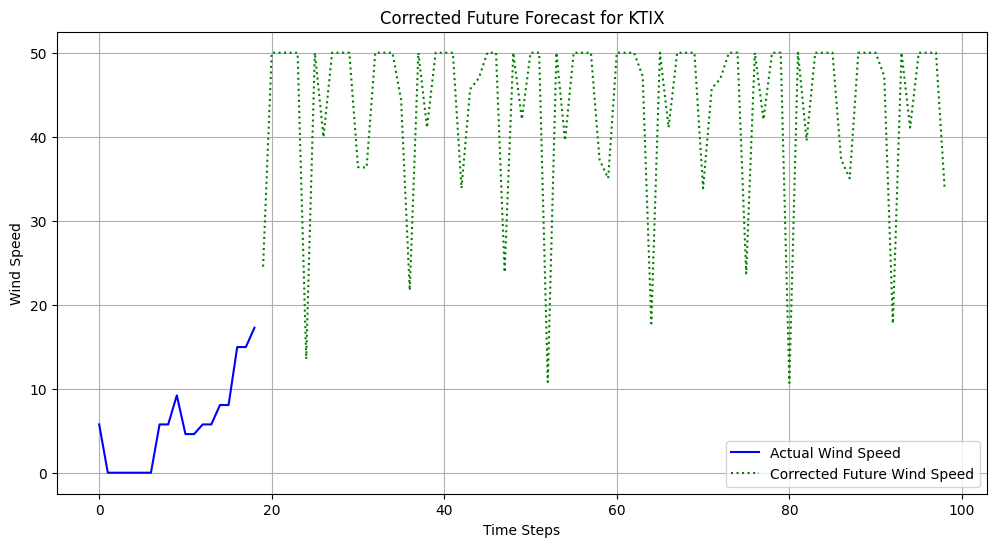

In [21]:
# Define realistic wind speed range (adjust as needed)
MIN_WIND_SPEED = 0
MAX_WIND_SPEED = 50

# Initialize last_input with valid shape and type
last_input = X_test[-1, :].reshape(1, -1).astype(np.float32)
future_predictions = []

for step in range(future_steps):
    try:
        # Predict the next step
        next_prediction = tabnet.predict(last_input).squeeze()

        # Clamp the prediction to a realistic range
        next_prediction = max(MIN_WIND_SPEED, min(next_prediction, MAX_WIND_SPEED))
        future_predictions.append(next_prediction)

        # Update input with a moving window approach
        new_input = np.roll(last_input, shift=-1, axis=1)  # Shift features
        new_input[0, -1] = next_prediction  # Replace last feature with prediction
        last_input = new_input.reshape(1, -1).astype(np.float32)  # Ensure correct shape and type
    except Exception as e:
        print(f"Error at step {step}: {e}")
        break

# Plot the corrected predictions
future_time_axis = np.arange(len(y_test), len(y_test) + future_steps)

plt.figure(figsize=(12, 6))
plt.plot(y_test.flatten(), label="Actual Wind Speed", color="blue")
plt.plot(range(len(y_test), len(y_test) + len(future_predictions)), future_predictions, label="Corrected Future Wind Speed", color="green", linestyle="dotted")
plt.title("Corrected Future Forecast for KTIX")
plt.xlabel("Time Steps")
plt.ylabel("Wind Speed")
plt.legend()
plt.grid(True)
plt.show()

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.0     |  0:00:00s
epoch 1  | loss: 0.0     |  0:00:00s
epoch 2  | loss: 0.0     |  0:00:00s
epoch 3  | loss: 0.0     |  0:00:00s
epoch 4  | loss: 0.0     |  0:00:00s
epoch 5  | loss: 0.0     |  0:00:00s
epoch 6  | loss: 0.0     |  0:00:00s
epoch 7  | loss: 0.0     |  0:00:00s
epoch 8  | loss: 0.0     |  0:00:00s
epoch 9  | loss: 0.0     |  0:00:00s
epoch 10 | loss: 0.0     |  0:00:00s
epoch 11 | loss: 0.0     |  0:00:00s
epoch 12 | loss: 0.0     |  0:00:00s
epoch 13 | loss: 0.0     |  0:00:00s
epoch 14 | loss: 0.0     |  0:00:00s
epoch 15 | loss: 0.0     |  0:00:00s
epoch 16 | loss: 0.0     |  0:00:00s
epoch 17 | loss: 0.0     |  0:00:00s
epoch 18 | loss: 0.0     |  0:00:00s
epoch 19 | loss: 0.0     |  0:00:00s
epoch 20 | loss: 0.0     |  0:00:00s
epoch 21 | loss: 0.0     |  0:00:00s
epoch 22 | loss: 0.0     |  0:00:00s
epoch 23 | loss: 0.0     |  0:00:00s
epoch 24 | loss: 0.0     |  0:00:00s
epoch 25 | loss: 0.0     |  0:00:00s
epoch 26 | loss: 0.0     |  0:00:00s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.0     |  0:00:00s
epoch 1  | loss: 0.0     |  0:00:00s
epoch 2  | loss: 0.0     |  0:00:00s
epoch 3  | loss: 0.0     |  0:00:00s
epoch 4  | loss: 0.0     |  0:00:00s
epoch 5  | loss: 0.0     |  0:00:00s
epoch 6  | loss: 0.0     |  0:00:00s
epoch 7  | loss: 0.0     |  0:00:00s
epoch 8  | loss: 0.0     |  0:00:00s
epoch 9  | loss: 0.0     |  0:00:00s
epoch 10 | loss: 0.0     |  0:00:00s
epoch 11 | loss: 0.0     |  0:00:00s
epoch 12 | loss: 0.0     |  0:00:00s
epoch 13 | loss: 0.0     |  0:00:00s
epoch 14 | loss: 0.0     |  0:00:00s
epoch 15 | loss: 0.0     |  0:00:00s
epoch 16 | loss: 0.0     |  0:00:00s
epoch 17 | loss: 0.0     |  0:00:00s
epoch 18 | loss: 0.0     |  0:00:00s
epoch 19 | loss: 0.0     |  0:00:00s
epoch 20 | loss: 0.0     |  0:00:00s
epoch 21 | loss: 0.0     |  0:00:00s
epoch 22 | loss: 0.0     |  0:00:00s
epoch 23 | loss: 0.0     |  0:00:00s
epoch 24 | loss: 0.0     |  0:00:00s
epoch 25 | loss: 0.0     |  0:00:00s
epoch 26 | loss: 0.0     |  0:00:00s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.0     |  0:00:00s
epoch 1  | loss: 0.0     |  0:00:00s
epoch 2  | loss: 0.0     |  0:00:00s
epoch 3  | loss: 0.0     |  0:00:00s
epoch 4  | loss: 0.0     |  0:00:00s
epoch 5  | loss: 0.0     |  0:00:00s
epoch 6  | loss: 0.0     |  0:00:00s
epoch 7  | loss: 0.0     |  0:00:00s
epoch 8  | loss: 0.0     |  0:00:00s
epoch 9  | loss: 0.0     |  0:00:00s
epoch 10 | loss: 0.0     |  0:00:00s
epoch 11 | loss: 0.0     |  0:00:00s
epoch 12 | loss: 0.0     |  0:00:00s
epoch 13 | loss: 0.0     |  0:00:00s
epoch 14 | loss: 0.0     |  0:00:00s
epoch 15 | loss: 0.0     |  0:00:00s
epoch 16 | loss: 0.0     |  0:00:00s
epoch 17 | loss: 0.0     |  0:00:00s
epoch 18 | loss: 0.0     |  0:00:00s
epoch 19 | loss: 0.0     |  0:00:00s
epoch 20 | loss: 0.0     |  0:00:00s
epoch 21 | loss: 0.0     |  0:00:00s
epoch 22 | loss: 0.0     |  0:00:00s
epoch 23 | loss: 0.0     |  0:00:00s
epoch 24 | loss: 0.0     |  0:00:00s
epoch 25 | loss: 0.0     |  0:00:00s
epoch 26 | loss: 0.0     |  0:00:00s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.0     |  0:00:00s
epoch 1  | loss: 0.0     |  0:00:00s
epoch 2  | loss: 0.0     |  0:00:00s
epoch 3  | loss: 0.0     |  0:00:00s
epoch 4  | loss: 0.0     |  0:00:00s
epoch 5  | loss: 0.0     |  0:00:00s
epoch 6  | loss: 0.0     |  0:00:00s
epoch 7  | loss: 0.0     |  0:00:00s
epoch 8  | loss: 0.0     |  0:00:00s
epoch 9  | loss: 0.0     |  0:00:00s
epoch 10 | loss: 0.0     |  0:00:00s
epoch 11 | loss: 0.0     |  0:00:00s
epoch 12 | loss: 0.0     |  0:00:00s
epoch 13 | loss: 0.0     |  0:00:00s
epoch 14 | loss: 0.0     |  0:00:00s
epoch 15 | loss: 0.0     |  0:00:00s
epoch 16 | loss: 0.0     |  0:00:00s
epoch 17 | loss: 0.0     |  0:00:00s
epoch 18 | loss: 0.0     |  0:00:00s
epoch 19 | loss: 0.0     |  0:00:00s
epoch 20 | loss: 0.0     |  0:00:00s
epoch 21 | loss: 0.0     |  0:00:00s
epoch 22 | loss: 0.0     |  0:00:00s
epoch 23 | loss: 0.0     |  0:00:00s
epoch 24 | loss: 0.0     |  0:00:00s
epoch 25 | loss: 0.0     |  0:00:00s
epoch 26 | loss: 0.0     |  0:00:00s
e

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.0     |  0:00:00s
epoch 1  | loss: 0.0     |  0:00:00s
epoch 2  | loss: 0.0     |  0:00:00s
epoch 3  | loss: 0.0     |  0:00:00s
epoch 4  | loss: 0.0     |  0:00:00s
epoch 5  | loss: 0.0     |  0:00:00s
epoch 6  | loss: 0.0     |  0:00:00s
epoch 7  | loss: 0.0     |  0:00:00s
epoch 8  | loss: 0.0     |  0:00:00s
epoch 9  | loss: 0.0     |  0:00:00s
epoch 10 | loss: 0.0     |  0:00:00s
epoch 11 | loss: 0.0     |  0:00:00s
epoch 12 | loss: 0.0     |  0:00:00s
epoch 13 | loss: 0.0     |  0:00:00s
epoch 14 | loss: 0.0     |  0:00:00s
epoch 15 | loss: 0.0     |  0:00:00s
epoch 16 | loss: 0.0     |  0:00:00s
epoch 17 | loss: 0.0     |  0:00:00s
epoch 18 | loss: 0.0     |  0:00:00s
epoch 19 | loss: 0.0     |  0:00:00s
epoch 20 | loss: 0.0     |  0:00:00s
epoch 21 | loss: 0.0     |  0:00:00s
epoch 22 | loss: 0.0     |  0:00:00s
epoch 23 | loss: 0.0     |  0:00:00s
epoch 24 | loss: 0.0     |  0:00:00s
epoch 25 | loss: 0.0     |  0:00:00s
epoch 26 | loss: 0.0     |  0:00:00s
e

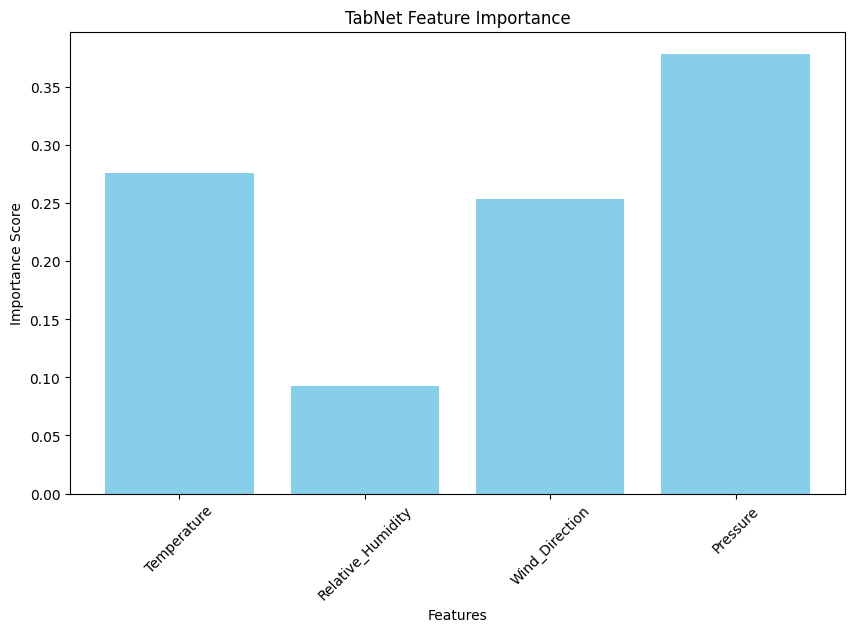

In [23]:
# Calculate metrics for the test set
y_pred_test = tabnet.predict(X_test).squeeze()

test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
test_r2 = r2_score(y_test, y_pred_test)
max_wind_speed = np.max(future_predictions)
mean_wind_speed = np.mean(future_predictions)

# Cross-validated RMSE
cv_scores = cross_val_score(
    tabnet,
    X_train,
    y_train,
    cv=5,
    scoring="neg_root_mean_squared_error"
)
cv_rmse = -np.mean(cv_scores)

# Print metrics
print(f"Test RMSE: {test_rmse:.2f}")
print(f"R-squared (Test): {test_r2:.2f}")
print(f"Maximum Future Wind Speed: {max_wind_speed:.2f}")
print(f"Mean Future Wind Speed: {mean_wind_speed:.2f}")
print(f"Cross-validated RMSE: {cv_rmse:.2f}")

# Plot Feature Importance
feature_importances = tabnet.feature_importances_
plt.figure(figsize=(10, 6))
plt.bar(range(len(features)), feature_importances, color='skyblue')
plt.xticks(range(len(features)), features, rotation=45)
plt.title("TabNet Feature Importance")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.show()